# Start

Estimating the pareto distribution parameter  of right tail of house prices

Zahra Shamloo, Mohamad Hoseini, Djavad Salehi-Isfahani

In [1]:
# !py -m pip install seaborn
# !py -m pip install polyfit
# !py -m pip install statsmodels
# !py -m pip install pyodbc
# !py -m pip install re
# !py -m pip install econtools
# !py -m pip install scipy

# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from numpy.polynomial.polynomial import polyfit
import statsmodels.api as sm
import pyodbc
import os
import seaborn as sns
import re

import econtools
import econtools.metrics as mt
pd.options.display.float_format = '{:.3f}'.format


from scipy.stats import norm, gaussian_kde
from sklearn.neighbors import KernelDensity

markerShape = ["x","s","o","d","D"]

from scipy.stats import pareto

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 70

In [2]:
provinceCode= { "مرکزی":"00" 
              , "گیلان":"01" 
              , "مازندران":"02" 
              , "آذربایجان شرقی":"03" 
              , "آذربایجان غربی":"04" 
              , "كرمانشاه":"05" 
              , "خوزستان":"06" 
              , "فارس":"07" 
              , "كرمان":"08" 
              , "خراسان رضوی":"09" 
              , "اصفهان":"10" 
              , "سيستان وبلوچستان":"11" 
              , "كردستان":"12" 
              , "همدان":"13" 
              , "چهارمحال وبختياري":"14" 
              , "لرستان":"15" 
              , "ایلام":"16" 
              , "كهگيلويه وبويراحمد":"17" 
              , "بوشهر":"18" 
              , "زنجان":"19" 
              , "سمنان":"20" 
              , "یزد":"21"
              , "هرمزگان":"22" 
              , "تهران":"23" 
              , "اردبیل":"24" 
              , "قم":"25" 
              , "قزوین":"26" 
              , "گلستان":"27" 
              , "خراسان شمالی":"28" 
              , "خراسان جنوبی":"29" 
              , "البرز":"30" 
                            }

provinceCodeEng= { "Markazi":"00" 
              , "Gilan":"01" 
              , "Mazandaran":"02" 
              , "Azerbaijan East":"03" 
              , "Azerbaijan West":"04" 
              , "Kermanshah":"05" 
              , "Khuzestan":"06" 
              , "Fars":"07" 
              , "Kerman":"08" 
              , "Khorasan Razavi":"09" 
              , "Isfahan":"10" 
              , "Sistan and Balochestan":"11" 
              , "Kordestan":"12" 
              , "Hamedan":"13" 
              , "Chaharmahaal and Bakhtiari":"14" 
              , "Lorestan":"15" 
              , "Ilam":"16" 
              , "Kohgiluyeh and Boyer-Ahmad":"17" 
              , "Bushehr":"18" 
              , "Zanjan":"19" 
              , "Semnan":"20" 
              , "Yazd":"21"
              , "Hormozgan":"22" 
              , "Tehran":"23" 
              , "Ardabil":"24" 
              , "qom":"25" 
              , "qazvin":"26" 
              , "Golestan":"27" 
              , "Khorasan North":"28" 
              , "Khorasan South":"29" 
              , "Alborz":"30" 
                            }

code_to_ostan = {value : key for (key, value) in provinceCodeEng.items()}

code_to_ostan

province_set=["23"]                                                   

# Top House Price


In [3]:
#SBR
# ##### read dta data file from directory
# Path= r"C:\Users\claudioq\Dropbox\project\data\IranHousingData2009-18.dta"
# data_row = pd.read_stata(Path ,convert_categoricals=False)
# coded = data_row.loc[:,["city","prov"]].rename(columns={"city":"cityCode","prov":"provCode"})
# data_row = pd.read_stata(Path)
# data_row = pd.concat([data_row,coded],axis=1)
Path= r"Iran Inequality Measure, Zahra Shamlou\Data\Real-state Transaction\IranHousePrice.dta"
data_row = pd.read_stata("..\Data\Real estate Transaction\IranHousePrice.dta")

#ZHR
# data_row = pd.read_stata("/Users/ZShamloo/Dropbox/project/data/IranHousePrice.dta") 
# data_row.head()
# data_row.info(memory_usage="deep")
data_row["provinceCode"] =data_row.prov.map(provinceCode)
data_row=data_row.loc[data_row.usingType.isin(["مسکوني","مسکونی"]),:]
# data_row.to_feather("data//housePriceFeather.file")
# data_row= pd.read_feather("data//housePriceFeather.file")

In [4]:

# make year culomn
# year that want to calculate the pareto dist paramater
data=data_row[['id','prov','city','dateShamsi','totalPrice','price','area',
               'age','district','provinceCode']]
data.drop_duplicates(inplace=True) # deleting repeated rows in data(duplicated id)
data['totalPrice']=data['totalPrice']/10000
data['price']= data['price']/10000
data=data[(data['area']>15) & (data['area']<1000)]
data=data[data['age']<100]

data = data.loc[(data['provinceCode'].isin(province_set)),:]

data['year']= data.dateShamsi.astype(str).str[0:4]
data['year'] = pd.to_numeric(data['year'])

data['month']= data.dateShamsi.astype(str).str[5:7]
data['month']= pd.to_numeric(data['month'])

houseIndex = data.groupby(['year','month']).agg({"totalPrice":"mean"}).reset_index()
houseIndex["shakhes"] = houseIndex.totalPrice / houseIndex.loc[
                                                (houseIndex.year==1398)
                                               &(houseIndex.month==1),"totalPrice"].values[0]
# houseIndex
data = pd.merge(data,houseIndex[["year","month","shakhes"]],how="left",on=["year","month"])
data["realTotalPrice"] = data.totalPrice / data.shakhes
data["realPrice"] = data.price / data.shakhes

# # drop outlier based on price per squre meter of houses
data=data[(data['realPrice']>0.05) & (data['realPrice']<100)]
data=data[(data['realTotalPrice'] >= 15)]
# data=data[(data['realTotalPrice'] <= 15000)]
data= data.loc[(data.realTotalPrice<40000),:]
data= data.loc[((data.area*data.price) >= 0.99*data.totalPrice)&
        ((data.area*data.price) <= 1.01*data.totalPrice),:]


##################################################################################

# sorting data based of house prices in each porv
# to calculate empirical cumulative distribution function of prices in each prov
data.sort_values(['prov', 'totalPrice'],inplace=True)
data.reset_index(inplace=True,drop=True)

##################################
# Making new variables
##################################

# creating a column for ln of total prices
data['LnPrice']= np.log(data['totalPrice']) # not that it take natural logarithm
data=data.loc[data.provinceCode.notna(),:]

data["weight"]=1


In [5]:
###############################
# input parameters value
###############################
year= 1395          # year that want to calculate the pareto dist paramater

#############
# defining columns to draw graph
new=data[(data['provinceCode'].isin(province_set)) & 
         (data['dateShamsi']>=f'{year}/00/00') & 
         (data['dateShamsi']<=f'{year+1}/00/00')]

new.sort_values(by=["provinceCode","totalPrice"],inplace=True)
new['Gy'] = new.groupby('provinceCode')['weight'].transform(pd.Series.cumsum)

new['countProv']=new.groupby('provinceCode')['weight'].transform(pd.Series.sum)

new['Gy'] = new.Gy/new.countProv

# we sort the data base on totalPrice, then use the new ordered index to creat Fy column
# new.sort_values('totalPrice',inplace=True)
# new.reset_index(drop=True, inplace=True)

# new['Gy']=(new.index+1) / (new['price'].count())  # empirical cumulative distribution of totalPrice
# new['Xvariable']= -np.log(1-new['Gy'])               # Xvariable is -ln(1-Fy) used in regression



# dropping nan, inf from data to avoid error in regression
# new.replace(np.inf, np.nan,inplace=True)
# new.dropna(subset=['LnPrice', 'Xvariable'],inplace=True)


new.head()


,id,prov,city,dateShamsi,totalPrice,price,area,age,district,provinceCode,year,month,shakhes,realTotalPrice,realPrice,LnPrice,weight,Gy,countProv
1510,13420914,تهران,تهران,1395/02/05,6.000,0.091,65.920,8.000,18.000,23,1395,2,0.393,15.259,0.231,1.792,1,0.000,180762
1646,13357921,تهران,باقرشهر,1395/01/19,6.000,0.098,61.390,4.000,20.000,23,1395,1,0.391,15.360,0.250,1.792,1,0.000,180762
2052,13506667,تهران,شهريار,1395/02/24,7.000,0.080,87.000,2.000,4.000,23,1395,2,0.393,17.802,0.205,1.946,1,0.000,180762
2290,13608656,تهران,ورامين,1395/03/13,7.200,0.111,65.000,1.000,NaN,23,1395,3,0.422,17.045,0.262,1.974,1,0.000,180762
3029,14088449,تهران,فيروزكوه,1395/06/24,8.200,0.115,71.110,1.000,NaN,23,1395,6,0.444,18.455,0.260,2.104,1,0.000,180762


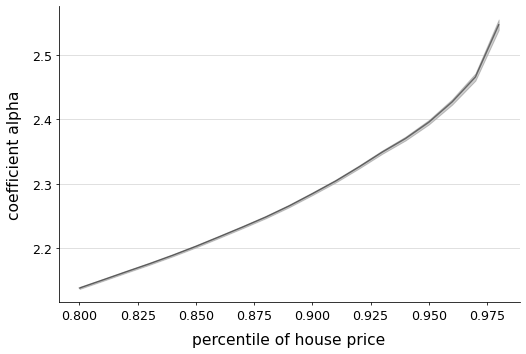

In [6]:

space=np.arange(0.8, 0.99, 0.01)
alpha=np.zeros(shape=(19,5))

for index,topPercentile in enumerate(space):

    N=new[new.Gy>topPercentile]
    N.sort_values('totalPrice',inplace=True)
    N.reset_index(drop=True, inplace=True)

    N['G2y']=(N.index+1) / (N['totalPrice'].count())  
    N.drop(N.tail(1).index,inplace=True)
    N['Xvariable']= -np.log(1-N['G2y'])     
    # dropping nan, inf from data to avoid error in regression
    N.replace(np.inf , np.nan,inplace=True)
    N.dropna(subset=['LnPrice', 'Xvariable'], how="all",inplace=True)
    
    x=N['Xvariable']
    y=N['LnPrice']

    results = sm.OLS(y,sm.add_constant(x),missing='drop').fit()
    alpha[index,0]=topPercentile
    alpha[index,1]= 1/results.params[1]
    
    se=results.bse[1]
    alpha[index,4]=se
    
    alpha[index,2]= 1/(results.params[1]+ 1.6*se)
    alpha[index,3]= 1/(results.params[1]- 1.6*se)

    
fig=plt.figure(figsize=(8.5,5.5))

ax1=fig.add_subplot(1,1,1)

ax1.plot(alpha[:,0], alpha[:,1], color=(0,0,0,0.5))
# ax1.hlines(alpha[:,1].mean(), space[0], space[-1] , linestyles='--', color=(0, 0.4 ,1, 0.9))

ax1.fill_between(alpha[:,0], alpha[:,2],alpha[:,3], color=(0,0,0,0.192) )


ax1.grid(axis='y',alpha=0.5)
# ax1.set_title(f'Figure 4:   Pareto tail index estimates for Tehran house prices in {year}')
ax1.set_xlabel('percentile of house price', fontsize=16,labelpad=10)
ax1.set_ylabel('coefficient alpha', fontsize=16,labelpad=10)
ax1.tick_params(labelsize=13)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.show()
# fig.savefig('figures/alpha_Tehran.pdf',transparent=True,bbox_inches="tight")

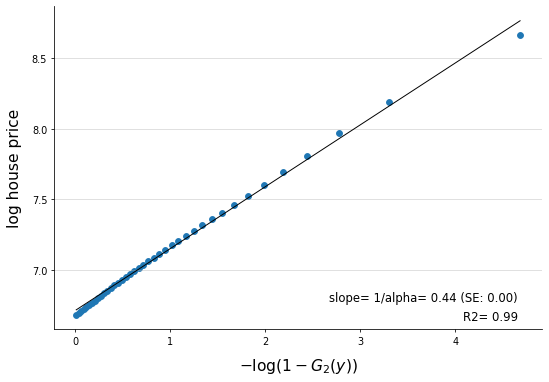

In [7]:
topPercentile= 0.90
# --------------------------------------------------------------
# replicating Figure 3 in the paper with Iran house prices data
    
N=new[new.Gy>topPercentile]
N.sort_values('totalPrice',inplace=True)
N.reset_index(drop=True, inplace=True)

N['G2y']=(N.index+1) / (N['totalPrice'].count())  
N.drop(N.tail(1).index,inplace=True)
N['Xvariable']= -np.log(1-N['G2y'])     
# dropping nan, inf from data to avoid error in regression
N.replace(np.inf , np.nan,inplace=True)
N.dropna(subset=['LnPrice', 'Xvariable'], how="all",inplace=True)

x=N['Xvariable']
y=N['LnPrice']

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,1,1)
# ax1.scatter(x,y)

results = sm.OLS(y,sm.add_constant(x),missing='drop').fit()
slope = results.params[1]
slope_se = results.bse[1]
r_squared = results.rsquared

x,y=econtools.binscatter(x,y,n=40)
x=x['Xvariable']
y=y['LnPrice']
ax1.scatter(x,y)

x_plot=np.linspace(x.min(), x.max(),3)
ax1.plot(x_plot, x_plot*results.params[1]+results.params[0],linewidth=1,color='black')

# ax1.set_title('Figure 3: Pareto quantile plot for house prices')
ax1.set_xlabel('$-\log(1-G_2(y))$', fontsize=16,labelpad=10)
ax1.set_ylabel('log house price', fontsize=16,labelpad=10)
# ax1.set_xticks(np.arange(3,13,1))
# ax1.tick_params(labelsize=13)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(axis='y',alpha=0.5)
# ax1.legend(loc='center left')
# Write the estimated slope and slope_se in the parenthesis on the graph
ax1.text(0.95, 0.08, f'slope= 1/alpha= {slope:.2f} (SE: {slope_se:.2f})', transform=ax1.transAxes,
         verticalalignment='bottom', horizontalalignment='right', fontsize=12)
ax1.text(0.95, 0.02, f'R2= {r_squared:.2f}', transform=ax1.transAxes,
         verticalalignment='bottom', horizontalalignment='right', fontsize=12)
plt.show()
# fig.savefig('../Figures/Python/alpha_Tehran_fit_95.pdf',transparent=True,bbox_inches="tight")

In [8]:
N.shape[0]/40

451.9

In [249]:
# alpha90= 1/results.params[1]
# tau90= np.exp(results.params[0])

# fig = plt.figure(figsize=(10,6))
# ax1 = fig.add_subplot(1,1,1)

# housePrice = np.linspace(tau90, N.totalPrice.max(), num=1000)
# G2_hat = alpha90 * (tau90**alpha90) / (housePrice**(alpha90+1))

# ax1.plot(housePrice, G2_hat, label='Pareto distribution fitted to data', linewidth=2)

# ax1.hist(N.totalPrice, bins=120, density=True,
#                  label='Empirical probability distribution', alpha=0.5)

# ax1.set_xlabel('house price (in million Toman)', fontsize=16, labelpad=10)
# ax1.set_ylabel('probability density', fontsize=16, labelpad=10)
# ax1.tick_params(labelsize=13)
# ax1.set_xlim(740, 4200)
# ax1.spines['right'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# ax1.legend(loc='best', edgecolor='gray', prop={'size':14}, handlelength=2.2)
# ax1.grid(alpha=0.5)
# plt.show()
# # fig.savefig('../Figures/Python/house_tail_distribution_fit_pdf_1395.pdf',transparent=True,bbox_inches="tight")

2.120908434514024


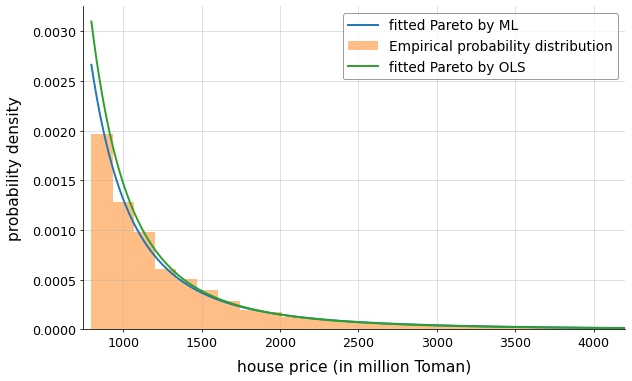

In [ ]:
# Fit Pareto distribution to the variable
loc = N.totalPrice.min()
n = N.shape[0]
mianeAlpha = (n) / (N.LnPrice.sum() - n*np.log(loc))
print(mianeAlpha) 

alpha90= mianeAlpha
tau90= loc

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,1,1)

housePrice = np.linspace(tau90, N.totalPrice.max(), num=1000)
G2_hat = alpha90 * (tau90**alpha90) / (housePrice**(alpha90+1))
ax1.plot(housePrice, G2_hat, label='fitted Pareto by ML', linewidth=2)

ax1.hist(N.totalPrice, bins=120, density=True,
                 label='Empirical probability distribution', alpha=0.5)

alpha90= 1/results.params[1]
tau90= np.exp(results.params[0])
G2_hat = alpha90 * (tau90**alpha90) / (housePrice**(alpha90+1))
ax1.plot(housePrice, G2_hat, label='fitted Pareto by OLS', linewidth=2)

ax1.set_xlabel('house price (in million Toman)', fontsize=16, labelpad=10)
ax1.set_ylabel('probability density', fontsize=16, labelpad=10)
ax1.tick_params(labelsize=13)
ax1.set_xlim(740, 4200)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(loc='best', edgecolor='gray', prop={'size':14}, handlelength=2.2)
ax1.grid(alpha=0.5)
plt.show()


In [11]:
tau90, alpha90

(np.float64(823.9246013292435), np.float64(2.2843519557448353))

In [12]:
N.totalPrice.min()

np.float64(796.5)

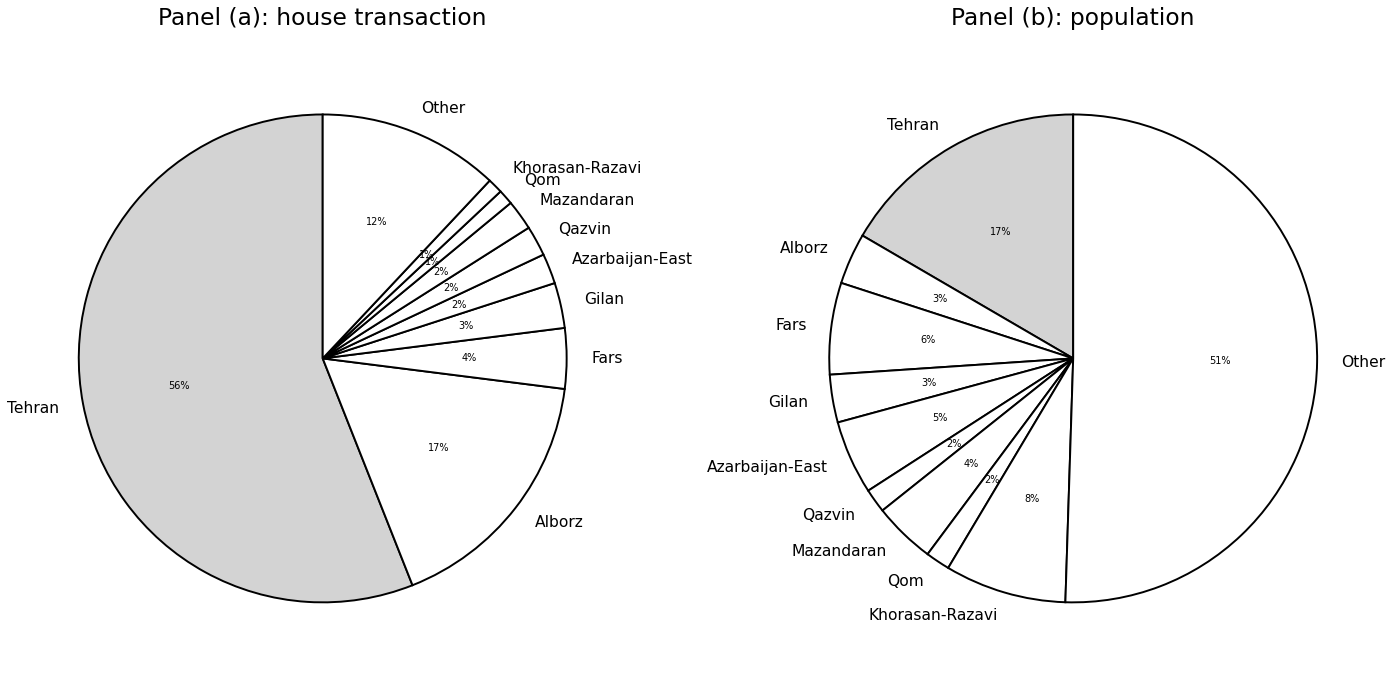

In [13]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(20, 10))

# First graph
labels_a = ['Tehran', 'Alborz','Fars',
          'Gilan','Azarbaijan-East','Qazvin',
          'Mazandaran','Qom','Khorasan-Razavi', 'Other']
sizes_a = [56,17,4,3,2,2,2,1,1,12]
colors_a = ['lightgray'] + ['white'] * (len(labels_a) - 1)  # Set the first element to light gray

# Plot the pie chart with white portions and thick lines
patches_a, texts_a, autotexts_a = axs[0].pie(sizes_a, labels=labels_a, colors=colors_a, shadow=False, startangle=90, autopct='%1.0f%%', wedgeprops={'linewidth': 2, 'edgecolor': 'black'})

# Increase the font size of the labels
for text_a in texts_a:
    text_a.set_fontsize(16)
axs[0].set_title("Panel (a): house transaction", fontsize=24)  # Add the title "panel (b)"
axs[0].axis('equal')

# Second graph
labels_b = ['Tehran', 'Alborz','Fars',
          'Gilan','Azarbaijan-East','Qazvin',
          'Mazandaran','Qom','Khorasan-Razavi', 'Other']
sizes_b = [13267637,2712400,4851274,2530696,3909652,1273761,3283582,1292283,6434501]
sizes_b.append(79926270- sum(sizes_b))

colors_b = ['lightgray'] + ['white'] * (len(labels_b) - 1)  # Set the first element to light gray

# Plot the pie chart with white portions and thick lines
patches_b, texts_b, autotexts_b = axs[1].pie(sizes_b, labels=labels_b, colors=colors_b, shadow=False, startangle=90, autopct='%1.0f%%', wedgeprops={'linewidth': 2, 'edgecolor': 'black'})

# Increase the font size of the labels
for text_b in texts_b:
    text_b.set_fontsize(16)

axs[1].set_title("Panel (b): population", fontsize=24)  # Add the title "panel (b)"
axs[1].axis('equal')

plt.tight_layout()
plt.show()

# fig.savefig('../Figures/Python/province_share_population_transaction_new.pdf',transparent=True,bbox_inches="tight")



# Income-House Value

In [11]:
#SBR
# Reading Data from SAS file in the data folder 
# conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};'+
#                       'DBQ= E:\This_Term\Thesis other things\Data\HIES data\data\Outfile-95.mdb')

conn = pyodbc.connect(r'Driver={Microsoft Access Driver (*.mdb, *.accdb)};'+
                      'DBQ= C:\\Users\ehsa7798\Box Sync\Academic\Data\HIES\Outfile-95.mdb')

query='select * from U95p3s04'
rent= pd.read_sql(query, conn)
rent=rent.apply(pd.to_numeric,errors='coerce') 

# #ZHR
# rent = pd.read_csv("../../rentU95.csv") 

rent= rent.loc[(rent.DYCOL01 < 43000) , ['Address','DYCOL01' ,'DYCOL04']]
rent.columns=['household','ownership' ,'rent']

rent = rent.groupby(by=["household"]).agg({"rent":"sum"}).reset_index()

# rent.head()

In [12]:
# data cleaning
rent['rent']= rent['rent'] * 12
rent['LnRent']= np.log(rent.rent)
# merge two data set by household number :
rent = pd.merge(rent, expenditure, on=['household'], how='inner')
# convert data to stata :
# rent.to_stata(r"C:\Users\claudioq\Dropbox\project\data\real_rent_made.dta")
rent.sort_values(by=["province","rent"],inplace=True)
rent['Fy'] = rent.groupby('province')['weight'].transform(pd.Series.cumsum)

rent['countProv']=rent.groupby('province')['weight'].transform(pd.Series.sum)

rent['Fy'] = rent.Fy/rent.countProv
# Extracting Tehran :
rentTehran= rent[rent.province.isin(province_set)]


**Estimating beta with considering weight of household**

In [13]:
# results = mt.reg(
#      rentTehran[rentTehran['Fy']>=0.9],                     # DataFrame
#      'LnHazineh',                      # Dependent var (string)
#      'LnRent',                      # Independent var(s) (string or list of strings)
#      addcons=True
#      ,awt_name='weight'    # Sample weights
# )
# results

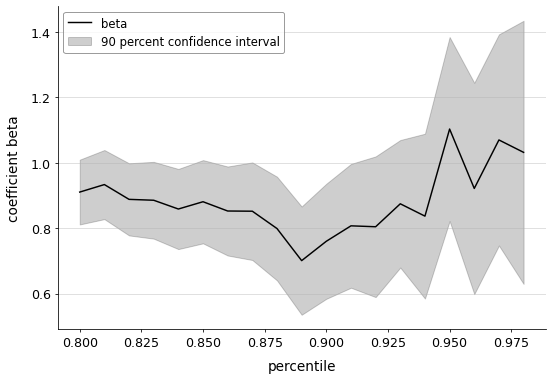

In [14]:
space=np.arange(0.8, 0.99, 0.01)
beta=np.zeros(shape=(19,5))

for index,topPercentile in enumerate(space):

    x=rentTehran[rentTehran['Fy']>=topPercentile]['LnRent']
    y=rentTehran[rentTehran['Fy']>=topPercentile]['LnHazineh']
    
    results = mt.reg(
    rentTehran[(rentTehran['Fy']>=topPercentile)
              ],                     # DataFrame
    'LnHazineh',                      # Dependent var (string)
    'LnRent',                      # Independent var(s) (string or list of strings)
    addcons=True
    ,awt_name='weight'    # Sample weights
    )
    
    
#     results = sm.OLS(y,sm.add_constant(x),missing='drop').fit()
    beta[index,0]=topPercentile
    beta[index,1]= results.beta['LnRent']
    
    se= results.se['LnRent']
    beta[index,4]=se
    
    beta[index,2]= (results.beta['LnRent']+ 1.6*se)
    beta[index,3]= (results.beta['LnRent']- 1.6*se)
    
    
fig=plt.figure(figsize=(9,6))

ax1=fig.add_subplot(1,1,1)

ax1.plot(beta[:,0], beta[:,1], color=(0,0,0,1),label="beta")
# hline=ax1.hlines(beta[:,1].mean(), space[0], space[-1] , linestyles='--', color=(0, 0.4 ,1, 0.9))

ax1.fill_between(beta[:,0], beta[:,2],beta[:,3], color=(0,0,0,0.192)
                ,linewidth= 1, label="90 percent confidence interval")

ax1.grid(axis='y',alpha=0.5)
# ax1.set_title(f'Figure 6:  Estimates of beta1 estimated using increasingly smaller number of top'
#               +'observations (household survey)')
ax1.set_xlabel('percentile', fontsize=14,labelpad=10)
ax1.set_ylabel('coefficient beta' , fontsize=14,labelpad=10)
ax1.tick_params(labelsize=13)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
plt.legend(loc=2,edgecolor='gray',prop={'size':12}, handlelength=2)
plt.show()
# fig.savefig('figures/beta_Tehran.pdf',transparent=True,bbox_inches="tight")

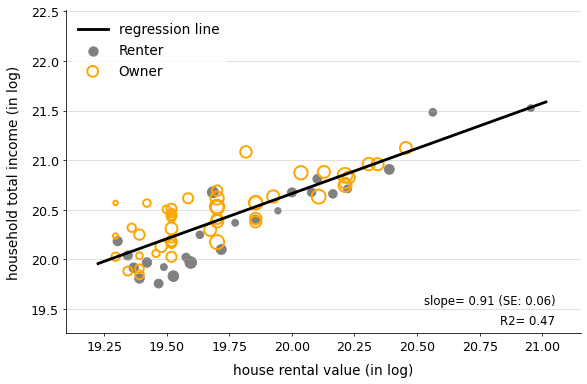

In [15]:
# groph: relation between household expenditure and their house values
topPercentile= 0.8

fig= plt.figure(figsize=(9.5,6))
ax1 = fig.add_subplot(1,1,1)

x=rentTehran[rentTehran['Fy']>=topPercentile]['LnRent']
y=rentTehran[rentTehran['Fy']>=topPercentile]['LnHazineh']


# results = mt.reg(
# rentTehran[(rentTehran['Fy']>=topPercentile)],                     # DataFrame
# 'LnHazineh',                      # Dependent var (string)
# 'LnRent',                      # Independent var(s) (string or list of strings)
# addcons=True
# ,awt_name='weight'    # Sample weights
# )

# Define the dependent variable
y = rentTehran.loc[(rentTehran['Fy']>=topPercentile), 'LnHazineh']

# Define the independent variable
X = rentTehran.loc[(rentTehran['Fy']>=topPercentile), 'LnRent']

# Define the weights
weights = rentTehran.loc[(rentTehran['Fy']>=topPercentile), 'weight']

# Add a constant to the independent variable
X = sm.add_constant(X)

# Create the weighted OLS model
model = sm.WLS(y, X, weights=weights)

# Fit the model
results = model.fit()

# Get the slope, constant, and R-squared
slope = results.params['LnRent']
slope_se = results.bse['LnRent']
constant = results.params['const']
r_squared = results.rsquared

x_plot=np.linspace(x.min()-0.07, x.max()+0.06,3)
ax1.plot(x_plot, x_plot*results.params['LnRent']+results.params['const'],linewidth=2.9,label="regression line",color="black")

flag = rentTehran[rentTehran.Fy>topPercentile]

# flag['homeowner'] = flag['ownership'].isin([1, 2, 5, 6, 7]).astype(int)
flag.loc[flag['ownership'].isin([1, 2, 5, 6, 7]), 'homeowner'] = 1
flag.loc[flag['ownership'].isin([3, 4]), 'homeowner'] = 0


flag = flag.sort_values(by=['homeowner', 'LnRent'])
flag['group'] = pd.qcut(flag.groupby('homeowner').cumcount(), q=50, labels=False)

flag = flag.groupby(['homeowner', 'group']).agg({'LnRent': 'mean', 'LnHazineh': 'mean', 'weight': 'sum'}).reset_index()

ax1.scatter(flag[flag.homeowner.isin([0])].LnRent , flag[flag.homeowner.isin([0])].LnHazineh
           , flag[flag.homeowner.isin([0])].weight/100
           , color="gray"
           , label= "Renter")

ax1.scatter(flag[flag.homeowner.isin([1])].LnRent , flag[flag.homeowner.isin([1])].LnHazineh
           , flag[flag.homeowner.isin([1])].weight/100
           , facecolor= "none"
           , edgecolor="orange"
           , linewidth= 2
           , label= "Owner")


ax1.set_xlabel('house rental value (in log)', fontsize=14,labelpad=10)
ax1.set_ylabel('household total income (in log)', fontsize=14,labelpad=10)
ax1.grid(axis= 'y',alpha=0.5)
ax1.tick_params(labelsize=13)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlim(x.min()-0.2, x.max()+0.2)
ax1.set_ylim(y.min()-0.3, y.max()+0.1)
# ax1.set_ylim(19.,22.8)
ax1.legend(loc='upper left', edgecolor='white', prop={'size':14}, handlelength=2.2)


# Write the estimated slope and slope_se in the parenthesis on the graph
ax1.text(0.95, 0.08, f'slope= {slope:.2f} (SE: {slope_se:.2f})', transform=ax1.transAxes,
         verticalalignment='bottom', horizontalalignment='right', fontsize=12)
ax1.text(0.95, 0.02, f'R2= {r_squared:.2f}', transform=ax1.transAxes,
         verticalalignment='bottom', horizontalalignment='right', fontsize=12)

plt.show()

# fig.savefig('../Figures/Python/beta_Tehran_fit_95_binnscatter.pdf',transparent=True,bbox_inches="tight")


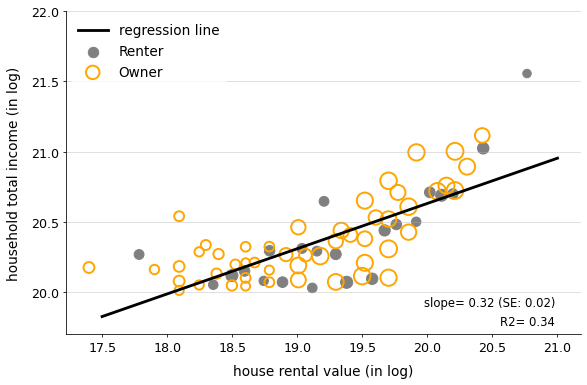

In [16]:
rentTehran.sort_values(by=["province","Daramad"],inplace=True)
rentTehran['FI'] = rentTehran.groupby('province')['weight'].transform(pd.Series.cumsum)

rentTehran['countProv']=rentTehran.groupby('province')['weight'].transform(pd.Series.sum)

rentTehran['FI'] = rentTehran.FI/rentTehran.countProv
# rentTehran= rent[rent.province.isin(province_set)]


# groph: relation between household expenditure and their house values
topPercentile= 0.7

fig= plt.figure(figsize=(9.5,6))
ax1 = fig.add_subplot(1,1,1)

x=rentTehran[rentTehran['FI']>=topPercentile]['LnRent']
y=rentTehran[rentTehran['FI']>=topPercentile]['LnHazineh']


# Define the dependent variable
y = rentTehran.loc[(rentTehran['FI']>=topPercentile), 'LnHazineh']

# Define the independent variable
X = rentTehran.loc[(rentTehran['FI']>=topPercentile), 'LnRent']

# Define the weights
weights = rentTehran.loc[(rentTehran['FI']>=topPercentile), 'weight']

# Add a constant to the independent variable
X = sm.add_constant(X)

# Create the weighted OLS model
model = sm.WLS(y, X, weights=weights)

# Fit the model
results = model.fit()

# Get the slope, constant, and R-squared
slope = results.params['LnRent']
slope_se = results.bse['LnRent']
constant = results.params['const']
r_squared = results.rsquared

x_plot=np.linspace(17.5, 21,3)
ax1.plot(x_plot, x_plot*results.params['LnRent']+results.params['const'],linewidth=2.9,label="regression line",color="black")

flag = rentTehran[rentTehran.FI>topPercentile]

# flag['homeowner'] = flag['ownership'].isin([1, 2, 5, 6, 7]).astype(int)
flag.loc[flag['ownership'].isin([1, 2, 5, 6, 7]), 'homeowner'] = 1
flag.loc[flag['ownership'].isin([3, 4]), 'homeowner'] = 0


flag = flag.sort_values(by=['homeowner', 'LnRent'])
flag['group'] = pd.qcut(flag.groupby('homeowner').cumcount(), q=50, labels=False)

flag = flag.groupby(['homeowner', 'group']).agg({'LnRent': 'mean', 'LnHazineh': 'mean', 'weight': 'sum'}).reset_index()

ax1.scatter(flag[flag.homeowner.isin([0])].LnRent , flag[flag.homeowner.isin([0])].LnHazineh
           , flag[flag.homeowner.isin([0])].weight/100
           , color="gray"
           , label= "Renter")

ax1.scatter(flag[flag.homeowner.isin([1])].LnRent , flag[flag.homeowner.isin([1])].LnHazineh
           , flag[flag.homeowner.isin([1])].weight/100
           , facecolor= "none"
           , edgecolor="orange"
           , linewidth= 2
           , label= "Owner")


ax1.set_xlabel('house rental value (in log)', fontsize=14,labelpad=10)
ax1.set_ylabel('household total income (in log)', fontsize=14,labelpad=10)
ax1.grid(axis= 'y',alpha=0.5)
ax1.tick_params(labelsize=13)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xlim(x.min()-0.2, x.max()+0.2)
# ax1.set_ylim(y.min()-0.3, y.max()+0.0)
ax1.set_ylim(19.7,22.0)
ax1.legend(loc='upper left', edgecolor='white', prop={'size':14}, handlelength=2.2)


# Write the estimated slope and slope_se in the parenthesis on the graph
ax1.text(0.95, 0.08, f'slope= {slope:.2f} (SE: {slope_se:.2f})', transform=ax1.transAxes,
         verticalalignment='bottom', horizontalalignment='right', fontsize=12)
ax1.text(0.95, 0.02, f'R2= {r_squared:.2f}', transform=ax1.transAxes,
         verticalalignment='bottom', horizontalalignment='right', fontsize=12)

plt.show()

# fig.savefig('../Figures/Python/.pdf',transparent=True,bbox_inches="tight")


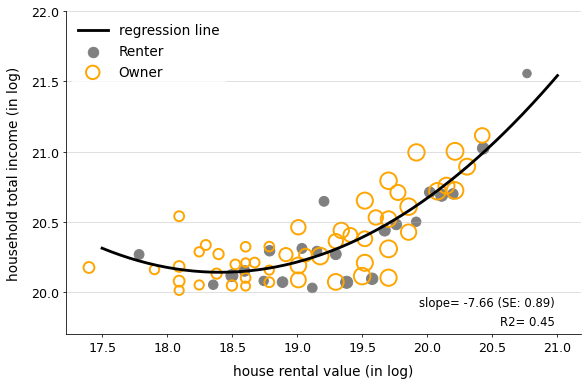

In [17]:
rentTehran.sort_values(by=["province","Daramad"],inplace=True)
rentTehran['FI'] = rentTehran.groupby('province')['weight'].transform(pd.Series.cumsum)

rentTehran['countProv']=rentTehran.groupby('province')['weight'].transform(pd.Series.sum)

rentTehran['FI'] = rentTehran.FI/rentTehran.countProv
# rentTehran= rent[rent.province.isin(province_set)]

rentTehran['LnRentSquared'] = rentTehran.LnRent**2
rentTehran['LnRent3'] = rentTehran.LnRent**3

# groph: relation between household expenditure and their house values
topPercentile= 0.7

fig= plt.figure(figsize=(9.5,6))
ax1 = fig.add_subplot(1,1,1)

x=rentTehran[rentTehran['FI']>=topPercentile]['LnRent']
y = rentTehran[rentTehran['FI']>=topPercentile]['LnHazineh']


# Define the dependent variable
y = rentTehran.loc[(rentTehran['FI']>=topPercentile), 'LnHazineh']

# Define the independent variable
X = rentTehran.loc[(rentTehran['FI']>=topPercentile), ['LnRent', 'LnRentSquared']]


# Define the weights
weights = rentTehran.loc[(rentTehran['FI']>=topPercentile), 'weight']

# Add a constant to the independent variable
X = sm.add_constant(X)

# Create the weighted OLS model
model = sm.WLS(y, X, weights=weights)

# Fit the model
results = model.fit()

# Get the slope, constant, and R-squared
slope = results.params['LnRent']
slope_se = results.bse['LnRent']
constant = results.params['const']
r_squared = results.rsquared
slope_2 = results.params['LnRentSquared']

x_plot=np.linspace(17.5, 21, 200)
ax1.plot(x_plot, x_plot*x_plot*slope_2 + x_plot*results.params['LnRent']+results.params['const'],linewidth=2.9,label="regression line",color="black")

flag = rentTehran[rentTehran.FI>topPercentile]

# flag['homeowner'] = flag['ownership'].isin([1, 2, 5, 6, 7]).astype(int)
flag.loc[flag['ownership'].isin([1, 2, 5, 6, 7]), 'homeowner'] = 1
flag.loc[flag['ownership'].isin([3, 4]), 'homeowner'] = 0


flag = flag.sort_values(by=['homeowner', 'LnRent'])
flag['group'] = pd.qcut(flag.groupby('homeowner').cumcount(), q=50, labels=False)

flag = flag.groupby(['homeowner', 'group']).agg({'LnRent': 'mean', 'LnHazineh': 'mean', 'weight': 'sum'}).reset_index()

ax1.scatter(flag[flag.homeowner.isin([0])].LnRent , flag[flag.homeowner.isin([0])].LnHazineh
           , flag[flag.homeowner.isin([0])].weight/100
           , color="gray"
           , label= "Renter")

ax1.scatter(flag[flag.homeowner.isin([1])].LnRent , flag[flag.homeowner.isin([1])].LnHazineh
           , flag[flag.homeowner.isin([1])].weight/100
           , facecolor= "none"
           , edgecolor="orange"
           , linewidth= 2
           , label= "Owner")


ax1.set_xlabel('house rental value (in log)', fontsize=14,labelpad=10)
ax1.set_ylabel('household total income (in log)', fontsize=14,labelpad=10)
ax1.grid(axis= 'y',alpha=0.5)
ax1.tick_params(labelsize=13)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xlim(x.min()-0.2, x.max()+0.2)
# ax1.set_ylim(y.min()-0.3, y.max()+0.0)
ax1.set_ylim(19.7,22.0)
ax1.legend(loc='upper left', edgecolor='white', prop={'size':14}, handlelength=2.2)


# Write the estimated slope and slope_se in the parenthesis on the graph
ax1.text(0.95, 0.08, f'slope= {slope:.2f} (SE: {slope_se:.2f})', transform=ax1.transAxes,
         verticalalignment='bottom', horizontalalignment='right', fontsize=12)
ax1.text(0.95, 0.02, f'R2= {r_squared:.2f}', transform=ax1.transAxes,
         verticalalignment='bottom', horizontalalignment='right', fontsize=12)

plt.show()

# fig.savefig('../Figures/Python/.pdf',transparent=True,bbox_inches="tight")


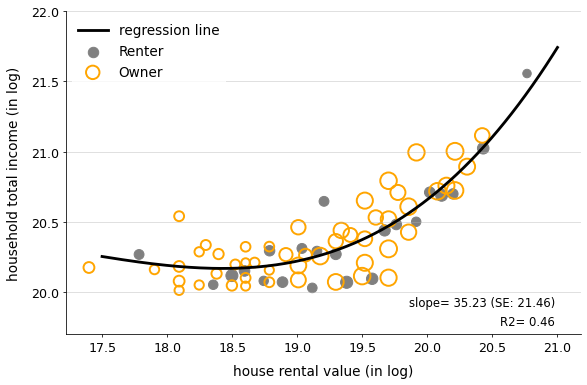

In [18]:
rentTehran.sort_values(by=["province","Daramad"],inplace=True)
rentTehran['FI'] = rentTehran.groupby('province')['weight'].transform(pd.Series.cumsum)

rentTehran['countProv']=rentTehran.groupby('province')['weight'].transform(pd.Series.sum)

rentTehran['FI'] = rentTehran.FI/rentTehran.countProv
# rentTehran= rent[rent.province.isin(province_set)]

rentTehran['LnRentSquared'] = rentTehran.LnRent**2
rentTehran['LnRent3'] = rentTehran.LnRent**3

# groph: relation between household expenditure and their house values
topPercentile= 0.7

fig= plt.figure(figsize=(9.5,6))
ax1 = fig.add_subplot(1,1,1)

x=rentTehran[rentTehran['FI']>=topPercentile]['LnRent']
y = rentTehran[rentTehran['FI']>=topPercentile]['LnHazineh']


# Define the dependent variable
y = rentTehran.loc[(rentTehran['FI']>=topPercentile), 'LnHazineh']

# Define the independent variable
X = rentTehran.loc[(rentTehran['FI']>=topPercentile), ['LnRent', 'LnRentSquared', 'LnRent3']]


# Define the weights
weights = rentTehran.loc[(rentTehran['FI']>=topPercentile), 'weight']

# Add a constant to the independent variable
X = sm.add_constant(X)

# Create the weighted OLS model
model = sm.WLS(y, X, weights=weights)

# Fit the model
results = model.fit()

# Get the slope, constant, and R-squared
slope = results.params['LnRent']
slope_se = results.bse['LnRent']
constant = results.params['const']
r_squared = results.rsquared
slope_2 = results.params['LnRentSquared']
slope_3 = results.params['LnRent3']

x_plot=np.linspace(17.5, 21, 200)
ax1.plot(x_plot, x_plot**3*slope_3 + x_plot*x_plot*slope_2 + x_plot*results.params['LnRent']+results.params['const'],linewidth=2.9,label="regression line",color="black")

flag = rentTehran[rentTehran.FI>topPercentile]

# flag['homeowner'] = flag['ownership'].isin([1, 2, 5, 6, 7]).astype(int)
flag.loc[flag['ownership'].isin([1, 2, 5, 6, 7]), 'homeowner'] = 1
flag.loc[flag['ownership'].isin([3, 4]), 'homeowner'] = 0


flag = flag.sort_values(by=['homeowner', 'LnRent'])
flag['group'] = pd.qcut(flag.groupby('homeowner').cumcount(), q=50, labels=False)

flag = flag.groupby(['homeowner', 'group']).agg({'LnRent': 'mean', 'LnHazineh': 'mean', 'weight': 'sum'}).reset_index()

ax1.scatter(flag[flag.homeowner.isin([0])].LnRent , flag[flag.homeowner.isin([0])].LnHazineh
           , flag[flag.homeowner.isin([0])].weight/100
           , color="gray"
           , label= "Renter")

ax1.scatter(flag[flag.homeowner.isin([1])].LnRent , flag[flag.homeowner.isin([1])].LnHazineh
           , flag[flag.homeowner.isin([1])].weight/100
           , facecolor= "none"
           , edgecolor="orange"
           , linewidth= 2
           , label= "Owner")


ax1.set_xlabel('house rental value (in log)', fontsize=14,labelpad=10)
ax1.set_ylabel('household total income (in log)', fontsize=14,labelpad=10)
ax1.grid(axis= 'y',alpha=0.5)
ax1.tick_params(labelsize=13)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
# ax1.set_xlim(x.min()-0.2, x.max()+0.2)
# ax1.set_ylim(y.min()-0.3, y.max()+0.0)
ax1.set_ylim(19.7,22.0)
ax1.legend(loc='upper left', edgecolor='white', prop={'size':14}, handlelength=2.2)


# Write the estimated slope and slope_se in the parenthesis on the graph
ax1.text(0.95, 0.08, f'slope= {slope:.2f} (SE: {slope_se:.2f})', transform=ax1.transAxes,
         verticalalignment='bottom', horizontalalignment='right', fontsize=12)
ax1.text(0.95, 0.02, f'R2= {r_squared:.2f}', transform=ax1.transAxes,
         verticalalignment='bottom', horizontalalignment='right', fontsize=12)

plt.show()

# fig.savefig('../Figures/Python/.pdf',transparent=True,bbox_inches="tight")


## Estimating beta for all provinces

In [19]:
# betaProv = np.zeros(shape=(30,4))
# betaProv = pd.DataFrame(rentedShare,
#                            columns=["province","beta","tedad","code"])

# for index,prov in enumerate(provinceCodeEng):
#     koofteProvince= provinceCodeEng[prov]
#     rentTehran= rent[rent.province==koofteProvince]

#     # sort by rent and define Fy based on it:
#     rentTehran= rentTehran.sort_values(by= ['rent'])
#     rentTehran.reset_index(inplace=True, drop=True)

#     rentTehran['Fy']= rentTehran.weight.cumsum() 
#     rentTehran['Fy']= rentTehran.Fy/ rentTehran.weight.sum()

#     results = mt.reg(
#          rentTehran[rentTehran['Fy']>=0.9],                     # DataFrame
#          'LnHazineh',                      # Dependent var (string)
#          'LnRent',                      # Independent var(s) (string or list of strings)
#          addcons=True
#          ,awt_name='weight'    # Sample weights
#     )
#     results
    
#     beta=results.beta['LnRent']
#     size= len(rentTehran[rentTehran['Fy']>=0.9])
    
#     betaProv.loc[index,"province"]= prov
#     betaProv.loc[index,"beta"]= beta
#     betaProv.loc[index,"tedad"]= size

#     betaProv.loc[index,"code"]= koofteProvince

    
    
# #     print("beta=",round(beta,2),"sample size=",size,"province=",prov)


# Conclosion: theta

In [93]:
beta=pd.DataFrame(data=beta,columns=['percentile','beta','beta_lower','beta_upper','beta_se'])
alpha=pd.DataFrame(data=alpha,columns=['percentile','alpha','alpha_lower','alpha_upper','alpha_se'])

theta_hat=pd.merge(beta,alpha,on=['percentile'])
theta_hat['theta_hat']=theta_hat.alpha/ theta_hat.beta

In [95]:
for i in np.arange(0,len(theta_hat)):
    a=np.random.normal(loc=1/theta_hat.loc[i,'alpha'],scale=theta_hat.loc[i,'alpha_se'],size=1000000)

    b=np.random.normal(loc=theta_hat.loc[i,'beta'],scale=theta_hat.loc[i,'beta_se'],size=1000000)
    d=1/(a*b)
    d=pd.DataFrame(d)
    
    theta_hat.loc[i,'thetahat_lower']= d.quantile(q=0.05)[0]
    theta_hat.loc[i,'thetahat_upper']= d.quantile(q=0.95)[0]   
    
    theta_hat.loc[i,'thetahat__']= d.mean()[0]

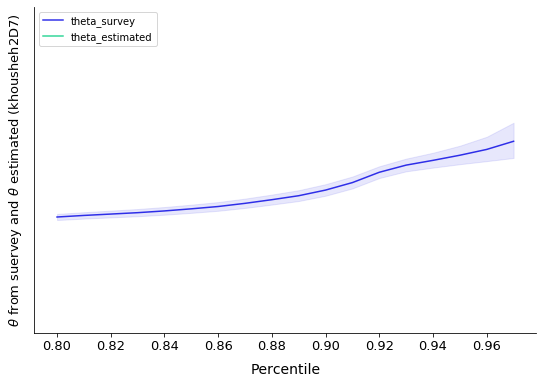

In [97]:
fig=plt.figure(figsize=(9,6))

ax1=fig.add_subplot(1,1,1)

ax1.plot(theta[0:18,0], theta[0:18,1], color=(0.1,0.1,0.9,0.9)
        ,label='theta_survey')
# hline=ax1.hlines(theta[:,1].mean(), space[0], space[-1] , linestyles='--', color=(0, 0.4 ,1, 0.9))

ax1.fill_between(theta[0:18,0], theta[0:18,2],theta[0:18,3], color=(0.1,0.1,0.9,0.1)
                ,linewidth= 1)


ax1.plot('percentile', 'theta_hat',
        data=theta_hat[theta_hat.percentile<=0.98],
        color=(0,0.8,0.5,0.8),
        label='theta_estimated')

ax1.fill_between('percentile', 'thetahat_lower', 'thetahat_upper'
                 ,data=theta_hat[theta_hat.percentile<=0.98]
                 ,color=(0,0.8,0.5,0.15)
                 ,linewidth= 1)

ax1.grid(axis='y',alpha=0.5)
# ax1.set_title(f'Figure 2:  Pareto tail index estimates for household expenditure per capita in Tehran')
ax1.set_xlabel('Percentile', fontsize=14, labelpad=10)
ax1.set_ylabel(r'$\theta$ from suervey and $\theta$ estimated (khousheh2D7)' , fontsize=13, labelpad=10)
ax1.legend(loc='best')
ax1.set_ylim(1.5,5)
ax1.set_xticks(np.arange(0.8,0.98,0.02))
ax1.tick_params(labelsize=13)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(loc='upper left')
plt.show()
#fig.savefig('figures/khousheh/theta_thetahat_khousheh2D7.pdf',transparent=True)

# All Year 89-98

In [3]:
year_list = [
    "2010",
    "2011",
    "2012",
    "2013",
    "2014",
    "2015",
    "2016",
    "2017",
    "2018",
    "2019",
]

In [4]:
"""
 define a function that calculated the Gini coefficient (also weighted)
"""

def gini(x, w=None):
    """ The rest of the code requires numpy arrays. """
    x = np.asarray(x)
    if w is not None:
        w = np.asarray(w)
        sorted_indices = np.argsort(x)
        sorted_x = x[sorted_indices]
        sorted_w = w[sorted_indices]
        """ Force float dtype to avoid overflows """ 
        cumw = np.cumsum(sorted_w, dtype=float)
        cumxw = np.cumsum(sorted_x * sorted_w, dtype=float)
        return (np.sum(cumxw[1:] * cumw[:-1] - cumxw[:-1] * cumw[1:]) / 
                (cumxw[-1] * cumw[-1]))
    else:
        sorted_x = np.sort(x)
        n = len(x)
        cumx = np.cumsum(sorted_x, dtype=float)
        """ The above formula, with all weights equal to 1 simplifies to: """
        return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n
    
"""
    CPI index of whole contry from 1376 to 1399
"""
cpi= pd.DataFrame(data={'year':np.arange(76,99),
                       'cpi':[5.298 , 6.258 , 7.516 , 8.463 , 9.427 , 10.915,
                              12.624, 14.544, 16.048, 17.955, 21.265, 26.66 ,
                              29.527, 33.188, 40.321, 52.635, 70.916, 81.948,
                              91.714, 100.0 , 109.6 , 137.3 , 185.3          ]})
cpi["cpi"] = cpi.cpi/100

## HIES

In [5]:
""" Household Income and Expenditure Data """

expenditureTotal = pd.read_csv(
    r"../Data/HIES/HIES(89-98)AggregateNEW.csv")

expenditureTotal['province']= expenditureTotal.household.astype(str).str[1:3]

""" merge the CPI to HIES to compute the real icnome and expenditure """
expenditureTotal = pd.merge(expenditureTotal,cpi,on=["year"],how="left")
expenditureTotal["realDaramad"] = expenditureTotal.Daramad/expenditureTotal.cpi
expenditureTotal["realGHazineh"] = expenditureTotal.GHazineh/expenditureTotal.cpi
expenditureTotal.drop(columns=["cpi"],inplace=True)
 
# print(expenditureTotal.info(memory_usage="deep"))


In [6]:
expenditureTotal.weight

0        699.329
1        699.329
2        699.329
3        699.329
4        699.329
           ...  
383224    80.000
383225    80.000
383226    80.000
383227   254.373
383228   467.000
Name: weight, Length: 383229, dtype: float64

In [7]:
""" welfare criterion considered for measuring inequality indices """
criterion = 0
"""
    If 0 : Daramad
    If 1 : GHazineh / np.sqrt(tedad)
    If 2 : GHazineh
"""

""" Define new vaiables: """ 
expenditureTotal['hazinehPerCapita'] = expenditureTotal.realDaramad #/ expenditureTotal.tedad
# expenditureTotal["weight"] = expenditureTotal.weight * expenditureTotal.tedad

figuresFolder = "Daramad"
expenditureTotal['LnHazineh']= np.log(expenditureTotal.hazinehPerCapita)

# expenditureTotal['rent']= expenditureTotal['rent'] * 12
expenditureTotal['LnRent']= np.log(expenditureTotal.rent) #/expenditureTotal.area)
# expenditureTotal["weight"] = expenditureTotal.weight * expenditureTotal.tedad

#* construct the empirical CDF that collapse observations with similar values into one and weights them.

# expenditureTotal.sort_values(by=["year","province","rent"],inplace=True)
# hh = expenditureTotal.groupby(by=['year','province','rent']).agg({"weight":"sum"}).reset_index()
# hh.sort_values(by=["year","province","rent"],inplace=True)

# hh['FRent'] = hh.groupby(by=['year','province'])['weight'].transform(pd.Series.cumsum)
# hh['countProv']=hh.groupby(by=['year','province'])['weight'].transform(pd.Series.sum)
# hh['FRent'] = hh.FRent/hh.countProv
# hh.drop(columns=["countProv","weight"], inplace=True)

# expenditureTotal.drop(columns=["FRent"], inplace=True, errors="ignore")

# expenditureTotal = pd.merge(expenditureTotal, hh, on=["year","province","rent"], how="left")

# del hh

#* construct the empirical CDF that randomly sort observations wiht same values
np.random.seed(1234)  # Set the seed number for replicability

expenditureTotal['rand'] = np.random.rand(len(expenditureTotal))

expenditureTotal.sort_values(by=["year","province","hazinehPerCapita","rand"],inplace=True)
# expenditureTotal['Fy'] = expenditureTotal.groupby(['year','province'])['weight'].apply(lambda x: x.cumsum() / x.sum())
expenditureTotal['Fy'] = expenditureTotal.groupby(['year','province'])['weight'].apply(lambda x: x.cumsum() / x.sum()).reset_index(level=['year', 'province'], drop=True)

expenditureTotal.sort_values(by=["year","province","rent","rand"], inplace=True)
expenditureTotal['FRent'] = expenditureTotal.groupby(['year','province'])['weight'].apply(lambda x: x.cumsum() / x.sum()).reset_index(level=['year', 'province'], drop=True)


In [8]:
"""
    'wm' is a function that calculate weighted average of the HIES data
"""
wm = lambda x: np.ma.average(np.ma.masked_array(
                             x.to_numpy(dtype="float64", na_value=np.nan),x.isna()), 
                             weights=expenditureTotal.loc[x.index, "weight"])

"""
    summary statistics of the HIES data set
"""
HIES_summary_Iran = expenditureTotal.loc[:,:].groupby(
    by=["year"]).agg({
    "weight":"count"
    }).reset_index().rename(columns={"weight":"Iran_HH_number"})

HIES_summary = expenditureTotal.loc[(expenditureTotal['province']=="23"),:].groupby(
    by=["year"]).agg({
    "weight":"count","tedad":wm,"realDaramad":wm,"realGHazineh":wm
    }).reset_index().rename(columns={"weight":"Tehran_HH_number"})

HIES_summary = pd.merge(HIES_summary_Iran,HIES_summary,on=["year"])
HIES_summary["realDaramad"] = HIES_summary.realDaramad/1e7
HIES_summary["realGHazineh"] = HIES_summary.realGHazineh/1e7

HIES_summary

,year,Iran_HH_number,Tehran_HH_number,tedad,realDaramad,realGHazineh
0,89,38285,2101,3.418,38.666,38.653
1,90,38513,1950,3.396,39.919,41.132
2,91,38192,1938,3.409,41.122,40.670
3,92,38316,1951,3.318,39.304,38.152
4,93,38275,2014,3.288,39.507,39.311
5,94,38252,2016,3.280,39.888,40.412
6,95,38146,2019,3.269,43.176,40.832
7,96,37962,1948,3.329,45.916,43.107
8,97,38960,2020,3.246,45.471,42.052
9,98,38328,1948,3.233,42.808,38.928


In [9]:
summary_statistics = HIES_summary.round(decimals=1)
summary_statistics.to_clipboard(index=False,header=None)

In [10]:
HIES_summary.columns = ["Year","Number (Iran)", "Number (Tehran)", "Household size", "Real income", "Real Expenditure"]
HIES_summary["Year"] = year_list
print(HIES_summary.to_latex(index=False, float_format="{:0.1f}".format,column_format='cccccc'))
#  Table A.1

\begin{tabular}{cccccc}
\toprule
Year & Number (Iran) & Number (Tehran) & Household size & Real income & Real Expenditure \\
\midrule
2010 & 38285 & 2101 & 3.4 & 38.7 & 38.7 \\
2011 & 38513 & 1950 & 3.4 & 39.9 & 41.1 \\
2012 & 38192 & 1938 & 3.4 & 41.1 & 40.7 \\
2013 & 38316 & 1951 & 3.3 & 39.3 & 38.2 \\
2014 & 38275 & 2014 & 3.3 & 39.5 & 39.3 \\
2015 & 38252 & 2016 & 3.3 & 39.9 & 40.4 \\
2016 & 38146 & 2019 & 3.3 & 43.2 & 40.8 \\
2017 & 37962 & 1948 & 3.3 & 45.9 & 43.1 \\
2018 & 38960 & 2020 & 3.2 & 45.5 & 42.1 \\
2019 & 38328 & 1948 & 3.2 & 42.8 & 38.9 \\
\bottomrule
\end{tabular}



## Real-estate transaction data

In [11]:
provinceCodeEng= { "Markazi":"00" 
              , "Gilan":"01" 
              , "Mazandaran":"02" 
              , "Azerbaijan East":"03" 
              , "Azerbaijan West":"04" 
              , "Kermanshah":"05" 
              , "Khuzestan":"06" 
              , "Fars":"07" 
              , "Kerman":"08" 
              , "Khorasan Razavi":"09" 
              , "Isfahan":"10" 
              , "Sistan and Balochestan":"11" 
              , "Kordestan":"12" 
              , "Hamedan":"13" 
              , "Chaharmahaal and Bakhtiari":"14" 
              , "Lorestan":"15" 
              , "Ilam":"16" 
              , "Kohgiluyeh and Boyer-Ahmad":"17" 
              , "Bushehr":"18" 
              , "Zanjan":"19" 
              , "Semnan":"20" 
              , "Yazd":"21"
              , "Hormozgan":"22" 
              , "Tehran":"23" 
              , "Ardabil":"24" 
              , "qom":"25" 
              , "qazvin":"26" 
              , "Golestan":"27" 
              , "Khorasan North":"28" 
              , "Khorasan South":"29" 
              , "Alborz":"30" 
                            }
"""
    'province_set' specifies the provinces that the methology 
    is implemented on them to re-estimate thier top income earners
    income distribution using the house price data
"""
# province_set=["23","09","10","25","30"]
province_set=["23"]#,"01","03","30","02","26"]


In [12]:
""" house data """

data = pd.read_stata("../Data/Real estate Transaction/IranHousePrice.dta") 
data.shape


data["provinceCode"] =data.prov.map(provinceCode)

# data = data.loc[(data.provinceCode=="23"),:]

data = data.loc[(data.usingType == "مسکونی"),:]


""" 
    make year column
    year that want to calculate the pareto dist paramater 
"""
data=data[['id','prov','city','dateShamsi','totalPrice','price','area',
               'age','district','provinceCode']]

# data.drop_duplicates(inplace=True) # deleting repeated rows in data(duplicated id)

data['totalPrice']=data['totalPrice']/10000
data['price']= data['price']/10000
data=data[(data['area']<1000)]
data=data[data['age']<70]

# data = data.loc[(data['provinceCode'].isin(province_set)),:]

data['year']= data.dateShamsi.astype(str).str[0:4]
data['year'] = pd.to_numeric(data['year'])

data['month']= data.dateShamsi.astype(str).str[5:7]
data['month']= pd.to_numeric(data['month'])


# data["areaXprice"] = (data.area*data.price)
# data= data.loc[((data.areaXprice) >= 0.99*data.totalPrice)]
# data= data.loc[((data.areaXprice) <= 1.01*data.totalPrice)]
# data.drop(inplace=True, columns=["areaXprice"])
    

""" 
    sorting data based of house prices in each porv
    to calculate empirical cumulative distribution function of prices in each prov
"""
data.sort_values(['prov', 'totalPrice'],inplace=True)
data.reset_index(inplace=True,drop=True)

""" Making new variables """
data['LnPrice']= np.log(data['totalPrice']) # not that it take natural logarithm
data=data.loc[data.provinceCode.notna(),:]

# data = data[["provinceCode","city","month","year","totalPrice","price"
#              ,"weight","LnPrice","age","area","district"]]

# print(data.info(memory_usage="deep"))
data.head()

,id,prov,city,dateShamsi,totalPrice,price,area,age,district,provinceCode,year,month,LnPrice
0,13074908,آذربایجان شرقی,شبستر,1394/11/10,0.100,0.001,90.370,4.000,NaN,03,1394,11,-2.303
1,13036117,آذربایجان شرقی,شبستر,1394/11/04,0.100,0.001,88.540,3.000,NaN,03,1394,11,-2.303
2,11534190,آذربایجان شرقی,شبستر,1394/02/19,0.100,0.001,115.470,2.000,NaN,03,1394,2,-2.303
3,12542743,آذربایجان شرقی,تبريز,1394/08/06,0.100,0.001,112.840,1.000,NaN,03,1394,8,-2.303
4,13195412,آذربایجان شرقی,تبريز,1394/11/27,0.100,0.001,114.250,1.000,NaN,03,1394,11,-2.303


In [13]:
data["provNew"] = np.nan
data.loc[(data.provinceCode.isin(['23'])), "provNew"] = "01"
data.loc[(data.provinceCode.isin(['30','07','01','03','26','02','25','09'])), "provNew"] = "02"
data.loc[( data["provNew"].isna()) , "provNew"] = "02"


province_set = ["01", "02"]

houseIndex = pd.DataFrame([])
for flag,prov in enumerate(province_set):
    houseIndexProv = data.loc[(data.provNew==prov),:].groupby(['year','month']).agg(
        {"totalPrice":"mean"}).reset_index()
    houseIndexProv["shakhes"] = houseIndexProv.totalPrice / houseIndexProv.loc[
                                                    (houseIndexProv.year==1398)
                                                    &(houseIndexProv.month==1),"totalPrice"].values[0]
    houseIndexProv["provNew"] = prov
    houseIndex = pd.concat([houseIndex,houseIndexProv],axis=0)
    houseIndexProv = []
    

""" houseIndex """
data = pd.merge(data,houseIndex[["year","month","shakhes","provNew"]],
                how="left",on=["provNew","year","month"])

data["realTotalPrice"] = data.totalPrice / data.shakhes
data["realPrice"] = data.price / data.shakhes
data.drop(inplace=True, columns=["shakhes"])


""" drop outlier based on price per squre meter of houses """
# data=data[(data['realPrice']>0.05) & (data['realPrice']<100)]
# data=data[(data['realTotalPrice'] >= 15)]
# data= data.loc[(data.realTotalPrice<40000),:]

' drop outlier based on price per squre meter of houses '

In [14]:
# Data cleaning by comparing similar houses

data['areaCat']= pd.cut(x=data['area'],bins=[0,50,80,100,130,200],right=False)
data['ageCat']= pd.cut(x=data['age'],bins=[0,3,7,13,20,40,100],right=False)

disaggregate_categories = ["year","month","district","areaCat","ageCat"]

# data['unique_id'] = data.groupby(disaggregate_categories).cumcount() + 1
# data['leave_one_out_mean'] = data.groupby('unique_id')['totalPrice'].transform(lambda x: x.dropna().mean())
# data['leave_one_out_std'] = data.groupby('unique_id')['totalPrice'].transform(lambda x: x.dropna().std())


data["totalPrice2"] = data.totalPrice
groupAll = data.loc[(data.city=="تهران")&(data.totalPrice.notna()),:].groupby(
    by=disaggregate_categories).agg({"totalPrice":"mean", "age":"count","totalPrice2":"std"}).reset_index().rename(
    columns={"age":"NSimiliar","totalPrice2":"stdSimilar"})

groupAll["city"] = "تهران"

data.drop(columns=["NSimilar","totalPriceSimilar"],inplace=True,errors="ignore")
data = pd.merge(data, groupAll
                      ,on=["city","year","month","district","areaCat","ageCat"]
                      ,suffixes=["","Similar"]
                      ,how="left")


data.loc[:,"outlier"] = 0
data.loc[(data.totalPrice < data.totalPriceSimilar-3*data.stdSimilar), "outlier"] = 1
data.loc[(data.totalPrice > data.totalPriceSimilar+3*data.stdSimilar), "outlier"] = 1

data.drop(columns=["areaCat","ageCat","stdSimilar","NSimilar"],inplace=True,errors="ignore")
del groupAll

print(data.loc[(data.outlier == 1),:].shape[0])

print(data.loc[(data.city=="تهران")].shape[0])


# If you want to replicate Figure A.2, uncomment the following line
# data = data.loc[(data.outlier != 1),:]


11844
1404310


In [15]:
house_price_summary = data.loc[(data['provinceCode']=="23"),:].groupby(by=["year"]).agg({
    "id":"count","totalPrice":"mean","area":"mean","age":"mean","price":"mean"
    }).reset_index().rename(columns={"id":"number"})

summary_statistics = house_price_summary.round(decimals=1)
summary_statistics.to_clipboard(index=False,header=None,)

house_price_summary

,year,number,totalPrice,area,age,price
0,1389,146681,146.629,82.603,11.155,1.630
1,1390,206246,165.620,82.140,10.428,1.829
2,1391,240096,285.129,80.837,8.983,3.307
3,1392,148845,342.811,79.879,7.224,3.919
4,1393,205756,382.766,80.568,7.075,4.362
5,1394,187542,340.867,81.820,7.103,4.324
6,1395,183254,395.487,85.637,7.807,4.577
7,1396,200446,475.262,87.599,8.697,5.273
8,1397,155207,712.680,85.167,9.200,7.858
9,1398,100761,1190.125,85.268,9.360,13.130


In [16]:
# house_price_summary = house_price_summary.round(decimals=1)
house_price_summary.columns = ["Year","Number","Total price","Area","Age","Price per square meter"]

house_price_summary = house_price_summary.loc[(house_price_summary.Year<1399),:]
house_price_summary["Year"] = year_list
print(house_price_summary.to_latex(index=False, float_format="{:0.1f}".format, column_format='cccccc'))

# Table 2

\begin{tabular}{cccccc}
\toprule
Year & Number & Total price & Area & Age & Price per square meter \\
\midrule
2010 & 146681 & 146.6 & 82.6 & 11.2 & 1.6 \\
2011 & 206246 & 165.6 & 82.1 & 10.4 & 1.8 \\
2012 & 240096 & 285.1 & 80.8 & 9.0 & 3.3 \\
2013 & 148845 & 342.8 & 79.9 & 7.2 & 3.9 \\
2014 & 205756 & 382.8 & 80.6 & 7.1 & 4.4 \\
2015 & 187542 & 340.9 & 81.8 & 7.1 & 4.3 \\
2016 & 183254 & 395.5 & 85.6 & 7.8 & 4.6 \\
2017 & 200446 & 475.3 & 87.6 & 8.7 & 5.3 \\
2018 & 155207 & 712.7 & 85.2 & 9.2 & 7.9 \\
2019 & 100761 & 1190.1 & 85.3 & 9.4 & 13.1 \\
\bottomrule
\end{tabular}



### weight transaction data

In [17]:
# # Replace 'ageCat' values based on conditions
# data.loc[data['age'].between(0, 5), 'ageCat'] = 1
# data.loc[data['age'].between(6, 15), 'ageCat'] = 2
# data.loc[data['age'].between(16, 25), 'ageCat'] = 3
# data.loc[data['age'] >= 26, 'ageCat'] = 4

# # Replace 'areaCat' values based on conditions
# data.loc[data['area'].between(0, 50), 'areaCat'] = 1
# data.loc[data['area'].between(51, 75), 'areaCat'] = 2
# data.loc[data['area'].between(76, 100), 'areaCat'] = 3
# data.loc[data['area'] >= 101, 'areaCat'] = 4

# # transaction data share of each category
# data['observation_count'] = data.groupby(['year', 'provinceCode', 'ageCat', 'areaCat'])['id'].transform('count')
# data['agg_count'] = data.groupby(['year', 'provinceCode'])['id'].transform('count')

# data['observation_count'] = data['observation_count'] / data['agg_count'] * 100
# data.drop(columns=['agg_count'], inplace=True)

# # import housing weights calculated from census data
# weight = pd.read_csv(r"../Data/NPHC/housing_weights.csv")

# data = data.merge(weight, on=["ageCat", "areaCat"])

# data['weight'] = data.weight / data.observation_count

data['weight'] = 1

## Real estate rent

In [18]:
interest_rate= pd.DataFrame(data={'year':np.arange(1389,1399),
                       'rate':[14,15,15,15,22,20,15,15,15,18]})

interest_rate["rate"] = ((interest_rate.rate/100 + 1) ** (1/12) - 1)
interest_rate

,year,rate
0,1389,0.011
1,1390,0.012
2,1391,0.012
3,1392,0.012
4,1393,0.017
5,1394,0.015
6,1395,0.012
7,1396,0.012
8,1397,0.012
9,1398,0.014


In [19]:
HouseRentTotal=pd.read_stata(f"../Data/Real estate Rent/IranHouseRent.dta")
HouseRentTotal = HouseRentTotal.loc[(HouseRentTotal.prov=="تهران")]

HouseRentTotal['year']= HouseRentTotal.dateShamsi.astype(str).str[0:4]
HouseRentTotal['year'] = pd.to_numeric(HouseRentTotal['year'])

HouseRentTotal['month']= HouseRentTotal.dateShamsi.astype(str).str[5:7]
HouseRentTotal['month']= pd.to_numeric(HouseRentTotal['month'])



HouseRentTotal = pd.merge(HouseRentTotal, interest_rate,
                         on=["year"])

HouseRentTotal["FullMortgage"] = (HouseRentTotal.ejareh/HouseRentTotal.rate + HouseRentTotal.rahn)/ 10**7
# HouseRentTotal["FullMortgage"] = (HouseRentTotal.ejareh*100/3 + HouseRentTotal.rahn)/ 10**7


""" drop outlier based on house area """
HouseRentTotal = HouseRentTotal.loc[(HouseRentTotal.area>15)&(HouseRentTotal.area<1000)]

""" drop outlier based on house age """
HouseRentTotal = HouseRentTotal.loc[(HouseRentTotal.age<100)]

HouseRentTotal = HouseRentTotal[["district","area","FullMortgage","age","year","rahn","month","city"]]

HouseRentTotal.head()

HouseRentTotal = HouseRentTotal[HouseRentTotal.groupby("year")["FullMortgage"]
                                .transform(lambda x: x != x.max())]


In [20]:

# HouseRentTotal['areaCat']= pd.cut(x=HouseRentTotal['area'],bins=[0,50,80,100,130,200],right=False)
# HouseRentTotal['ageCat']= pd.cut(x=HouseRentTotal['age'],bins=[0,3,7,13,20,40,100],right=False)

# disaggregate_categories = ["year","month","district","areaCat","ageCat"]

# HouseRentTotal["FullMortgage2"] = HouseRentTotal.FullMortgage
# groupAll = HouseRentTotal.loc[(HouseRentTotal.FullMortgage.notna())&(HouseRentTotal.city=="تهران"),:].groupby(
#     by=disaggregate_categories).agg({"FullMortgage":"mean", "rahn":"count","FullMortgage2":"std"}).reset_index().rename(
#     columns={"rahn":"NSimiliar","FullMortgage2":"stdSimilar"})
# groupAll["city"] = "تهران"
# # HousePrice.drop(columns=["totalPriceMean"],inplace=True, errors="ignore")
# HouseRentTotal = pd.merge(HouseRentTotal, groupAll
#                       ,on=["year","month","district","areaCat","ageCat","city"]
#                       ,suffixes=["","Similar"]
#                       ,how="left")


# HouseRentTotal.loc[:,"outlier"] = 0
# HouseRentTotal.loc[(HouseRentTotal.FullMortgage < HouseRentTotal.FullMortgageSimilar-3*HouseRentTotal.stdSimilar), "outlier"] = 1
# HouseRentTotal.loc[(HouseRentTotal.FullMortgage > HouseRentTotal.FullMortgageSimilar+3*HouseRentTotal.stdSimilar), "outlier"] = 1

# HouseRentTotal=HouseRentTotal.loc[(HouseRentTotal.outlier!=1),:]

# HouseRentTotal.drop(columns=["stdSimilar","NSimiliar","FullMortgage2","FullMortgageSimilar"],inplace=True)

# HouseRentTotal.shape

# del groupAll

In [21]:
# HouseRentTotal["weight"] = 1
# HouseRentTotal.sort_values(by=["year","FullMortgage"],inplace=True)
# HouseRentTotal['Fy'] = HouseRentTotal.groupby('year')['weight'].transform(pd.Series.cumsum)
# HouseRentTotal['countYear']=HouseRentTotal.groupby('year')['weight'].transform(pd.Series.sum)
# HouseRentTotal['Fy'] = HouseRentTotal.Fy/HouseRentTotal.countYear
# HouseRentTotal.drop(columns=["countYear"], inplace=True)

# HouseRentTotal = HouseRentTotal.loc[(HouseRentTotal.Fy <= 0.998),:]

In [22]:
# summary statistics 

house_rent_summary = HouseRentTotal.groupby(by=["year"]).agg(
    {"district":"count", "FullMortgage":"mean","area":"mean","age":"mean"}).reset_index().rename(columns={"district":"number"})

summary_statistics= house_rent_summary.round(decimals=1)
summary_statistics.to_clipboard(index=False,header=None,)

house_rent_summary

,year,number,FullMortgage,area,age
0,1389,18526,155.667,86.079,13.146
1,1390,44897,116.708,82.498,13.059
2,1391,94065,108.880,79.839,12.384
3,1392,121361,118.564,78.637,10.678
4,1393,148860,106.003,77.792,10.740
5,1394,105031,87.988,76.145,10.816
6,1395,160395,131.511,75.148,11.880
7,1396,124913,145.367,76.494,12.332
8,1397,114441,220.678,79.890,11.783
9,1398,88695,219.926,79.788,13.031


In [23]:
# house_price_summary = house_price_summary.round(decimals=1)
house_rent_summary.columns = ["Year","number","Avg. security deposit","Avg. area","Avg. age"]

house_rent_summary["Year"] = year_list
print(house_rent_summary.to_latex(index=False, float_format="{:0.1f}".format, column_format='ccccc'))

\begin{tabular}{ccccc}
\toprule
Year & number & Avg. security deposit & Avg. area & Avg. age \\
\midrule
2010 & 18526 & 155.7 & 86.1 & 13.1 \\
2011 & 44897 & 116.7 & 82.5 & 13.1 \\
2012 & 94065 & 108.9 & 79.8 & 12.4 \\
2013 & 121361 & 118.6 & 78.6 & 10.7 \\
2014 & 148860 & 106.0 & 77.8 & 10.7 \\
2015 & 105031 & 88.0 & 76.1 & 10.8 \\
2016 & 160395 & 131.5 & 75.1 & 11.9 \\
2017 & 124913 & 145.4 & 76.5 & 12.3 \\
2018 & 114441 & 220.7 & 79.9 & 11.8 \\
2019 & 88695 & 219.9 & 79.8 & 13.0 \\
\bottomrule
\end{tabular}



## Estimating the relationship between house price and rent

In [24]:

""" Initialize the Output dataframes """
price_rent_ratio = np.zeros(shape=(10,1))
price_rent_ratio = pd.DataFrame(price_rent_ratio, columns=["year"])
price_rent_ratio.year = np.arange(1389,1399)

Sample = pd.DataFrame([])
for Year in np.arange(1389,1399):
    """
        Finding the average price of similar houses
        in the Tehran city
        Similar houses are in the same category of:
        1. area
        2. age
        3. district
    """
    HousePrice = data.loc[(data.year==Year)]

    HousePrice = HousePrice.loc[(HousePrice.city=="تهران"),:]


    HousePrice['areaCat']= pd.cut(x=HousePrice['area'],bins=[0,50,80,100,130],right=False)
    HousePrice['ageCat']= pd.cut(x=HousePrice['age'],bins=[0,3,7,13,20],right=False)

    disaggregate_categories = ["ageCat","areaCat","district","month"]

    house_price_mean_category = HousePrice.groupby(
        by=disaggregate_categories).agg({
            "totalPrice":"mean","price":"count"
            }).reset_index().rename(columns={"price":"price_count"})
    house_price_mean_category = house_price_mean_category.loc[
        (house_price_mean_category.totalPrice.notna()),:]

    house_price_mean_category = house_price_mean_category.loc[(house_price_mean_category.price_count>=10),:]

    house_price_mean_category.head()


    """
       Running the previous algorithm for the house rent data set of the same year
        Similar houses are in the same category of:
        1. area
        2. age
        3. district
    """
    HouseRent= HouseRentTotal.loc[(HouseRentTotal.year == Year),:]

    HouseRent['areaCat']= pd.cut(x=HouseRent['area'],bins=[0,50,80,100,130],right=False)
    HouseRent['ageCat']= pd.cut(x=HouseRent['age'],bins=[0,3,7,13,20],right=False)


    rent_mean_category = HouseRent.groupby(
        by=disaggregate_categories).agg({
            "FullMortgage":"mean","rahn":"count"
            }).reset_index().rename(columns={"rahn":"rent_count"})
    rent_mean_category = rent_mean_category.loc[(rent_mean_category.FullMortgage.notna()),:]

    rent_mean_category = rent_mean_category.loc[(rent_mean_category.rent_count>=10),:]

    rent_mean_category.head()


    """
        Merging the house rent and price average in the same categories
    """

    rent_price_combine = pd.merge(house_price_mean_category,rent_mean_category,
            on=disaggregate_categories,
            how="inner")
    
    rent_price_combine["year"] = Year
    
    rent_price_combine["RATIO"] = rent_price_combine.totalPrice / rent_price_combine.FullMortgage
    
    rent_price_combine["ration_cross_number"] = rent_price_combine.RATIO * rent_price_combine.price_count
#     price_rent_ratio.loc[(price_rent_ratio.year==Year),"ratio_mean"] = rent_price_combine.RATIO.mean()
    price_rent_ratio.loc[(price_rent_ratio.year==Year),"ratio_mean"] = rent_price_combine.ration_cross_number.sum() / rent_price_combine.price_count.sum()

    # price_rent_ratio.loc[(price_rent_ratio.year==Year),"ratio_std"] = rent_price_combine.RATIO.std()
    price_rent_ratio.loc[(price_rent_ratio.year==Year),"ratio_p10"] = rent_price_combine.RATIO.quantile(0.1)
    price_rent_ratio.loc[(price_rent_ratio.year==Year),"ratio_median"] = rent_price_combine.RATIO.median()
    price_rent_ratio.loc[(price_rent_ratio.year==Year),"ratio_p90"] = rent_price_combine.RATIO.quantile(0.9)
    
    price_rent_ratio.loc[(price_rent_ratio.year==Year),"ratio_count"] = rent_price_combine.RATIO.count()
    price_rent_ratio.loc[(price_rent_ratio.year==Year),"price_count_mean"] = rent_price_combine.totalPrice.median()
    price_rent_ratio.loc[(price_rent_ratio.year==Year),"rent_count_mean"] = rent_price_combine.FullMortgage.median()

    Sample = pd.concat([Sample, rent_price_combine], axis=0)
    # rent_price_combine.describe()
    

Sample.to_stata("./data/matching.dta")
del Sample
"""
    cleaning the auxilary data from the memory
"""
# rent_price_combine = []
del rent_mean_category
del house_price_mean_category
del HouseRent
del HousePrice
# HouseRentTotal = []

In [25]:
summary_statistics = price_rent_ratio.round(decimals=2)
summary_statistics.ratio_count.astype(np.int64)

summary_statistics["ratio_count"] = np.floor(summary_statistics.ratio_count)
summary_statistics["ratio_count"] = summary_statistics.ratio_count.round(decimals=0)
summary_statistics.to_clipboard(index=False,header=None,)

price_rent_ratio

,year,ratio_mean,ratio_p10,ratio_median,ratio_p90,ratio_count,price_count_mean,rent_count_mean
0,1389,3.151,1.577,3.086,5.307,386.000,138.112,42.244
1,1390,2.975,2.041,3.000,3.982,983.000,142.957,47.179
2,1391,4.756,2.390,3.398,4.863,1702.000,188.325,54.061
3,1392,4.893,2.842,3.879,5.029,1772.000,227.765,58.924
4,1393,5.538,3.399,4.530,6.127,2146.000,247.986,54.474
5,1394,4.610,3.168,4.055,5.403,1592.000,243.390,59.225
6,1395,3.300,2.529,3.329,4.330,2200.000,261.126,76.681
7,1396,3.122,2.401,3.174,4.155,1963.000,295.790,91.904
8,1397,4.076,2.846,4.060,5.607,1332.000,514.597,127.053
9,1398,5.510,4.198,5.399,6.864,1035.000,783.154,147.136


In [26]:
price_rent_ratio.ratio_count = price_rent_ratio.ratio_count.astype(np.int64)
price_rent_ratio.price_count_mean = price_rent_ratio.price_count_mean.astype(np.int64)
price_rent_ratio.rent_count_mean = price_rent_ratio.rent_count_mean.astype(np.int64)

price_rent_ratio.year = year_list
print(price_rent_ratio.to_latex(index=False, float_format="{:0.1f}".format, column_format='ccccccc'))

\begin{tabular}{ccccccc}
\toprule
year & ratio_mean & ratio_p10 & ratio_median & ratio_p90 & ratio_count & price_count_mean & rent_count_mean \\
\midrule
2010 & 3.2 & 1.6 & 3.1 & 5.3 & 386 & 138 & 42 \\
2011 & 3.0 & 2.0 & 3.0 & 4.0 & 983 & 142 & 47 \\
2012 & 4.8 & 2.4 & 3.4 & 4.9 & 1702 & 188 & 54 \\
2013 & 4.9 & 2.8 & 3.9 & 5.0 & 1772 & 227 & 58 \\
2014 & 5.5 & 3.4 & 4.5 & 6.1 & 2146 & 247 & 54 \\
2015 & 4.6 & 3.2 & 4.1 & 5.4 & 1592 & 243 & 59 \\
2016 & 3.3 & 2.5 & 3.3 & 4.3 & 2200 & 261 & 76 \\
2017 & 3.1 & 2.4 & 3.2 & 4.2 & 1963 & 295 & 91 \\
2018 & 4.1 & 2.8 & 4.1 & 5.6 & 1332 & 514 & 127 \\
2019 & 5.5 & 4.2 & 5.4 & 6.9 & 1035 & 783 & 147 \\
\bottomrule
\end{tabular}



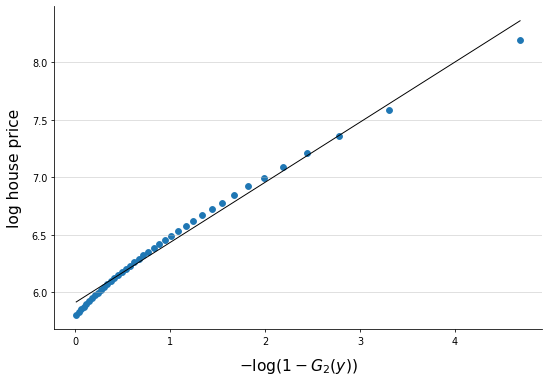

In [27]:
T = expenditureTotal.loc[(expenditureTotal.year==95)&(expenditureTotal.province=="23"),:]
T = T.loc[(T.FRent>=0.9),:]

TopRent = T.rent.min()
Price_to_Mortgage_Ratio = price_rent_ratio.loc[price_rent_ratio.year== f"{1300+95+621}","ratio_mean"].values[0]
TopPrice= TopRent * Price_to_Mortgage_Ratio * (100/3) / 10000000

T['rent'] = T.rent * Price_to_Mortgage_Ratio * (100/3) / 10000000





import numpy as np
from scipy.optimize import minimize, LinearConstraint
from sklearn.utils import resample

# Objective function: Sum of squared residuals
def objective_function(params, x, y):
    intercept, slope = params
    predictions = intercept + slope * x
    residuals = y - predictions
    return np.sum(residuals**2)


# Assuming x, y, constraint_value are defined as before

# Function to fit the model and return parameters
def fit_model(x, y, constraint_value):
    def objective_function(params, x, y):
        intercept, slope = params
        predictions = intercept + slope * x
        residuals = y - predictions
        return np.sum(residuals**2)
    
    constraints = LinearConstraint([1, 0], -np.inf, constraint_value)
    initial_guess = [0, 0]
    result = minimize(objective_function, initial_guess, args=(x, y), constraints=constraints)
    return result.x  # Return optimized parameters



def pareto_mle(weights, data):
    # Ensure weights and data are numpy arrays
    weights = np.array(weights)
    data = np.array(data)
    
    # Calculate x_m as the minimum value in the data
    x_m = np.min(data)
    
    # Calculate the MLE for alpha
    numerator = np.sum(weights)
    denominator = np.sum(weights * (np.log(data) - np.log(x_m)))
    alpha_mle = numerator / denominator
    
    return alpha_mle, x_m

# alpha_mle, x_m = pareto_mle(weights, data)





###############################
# input parameters value
###############################
year= 1395          # year that want to calculate the pareto dist paramater

#############
# defining columns to draw graph
new=data[(data['provinceCode'].isin(["23"])) & (data['year']==year)].copy()

new.sort_values(by=["provinceCode","totalPrice"],inplace=True)
new['Gy'] = new.groupby('provinceCode')['weight'].transform(pd.Series.cumsum)

new['countProv']=new.groupby('provinceCode')['weight'].transform(pd.Series.sum)

new['Gy'] = new.Gy/new.countProv


new.head()


# ---------------------------------------------------------
topPercentile= 0.9
# --------------------------------------------------------------
# replicating Figure 3 in the paper with Iran house prices data
    
# N=new[new.Gy>topPercentile]
N = new[new.totalPrice > TopPrice]
N.sort_values('totalPrice',inplace=True)
N.reset_index(drop=True, inplace=True)

N['G2y']=(N.index+1) / (N['totalPrice'].count())  
N.drop(N.tail(1).index,inplace=True)
N['Xvariable']= -np.log(1-N['G2y'])     
# dropping nan, inf from data to avoid error in regression
N.replace(np.inf , np.nan,inplace=True)
N.dropna(subset=['LnPrice', 'Xvariable'], how="all",inplace=True)

x=N['Xvariable']
y=N['LnPrice'] #- np.log(N.totalPrice.min())

results = sm.OLS(y,sm.add_constant(x),missing='drop').fit()
intercept = results.params[0]
slope = results.params[1]
slope_se = results.bse[1]
r_squared = results.rsquared

# constraint_value = np.log(N.totalPrice.min())  # The maximum value for the intercept
# optimized_params = fit_model(x, y, constraint_value)
# intercept, slope = optimized_params

# # Bootstrapping for standard errors
# n_bootstraps = 100
# bootstrapped_params = np.array([fit_model(*resample(x, y), constraint_value) for _ in range(n_bootstraps)])
# constant_se, slope_se = bootstrapped_params.std(axis=0)

# # Calculate R-squared
# optimized_params = fit_model(x, y, constraint_value)
# predictions = optimized_params[0] + optimized_params[1] * x
# ss_res = np.sum((y - predictions) ** 2)
# ss_tot = np.sum((y - np.mean(y)) ** 2)
# r_squared = 1 - ss_res / ss_tot



fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,1,1)

x,y=econtools.binscatter(x,y,n=40)
x=x['Xvariable']
y=y['LnPrice']
ax1.scatter(x,y)

x_plot=np.linspace(x.min(), x.max(),3)
ax1.plot(x_plot, x_plot*slope + intercept ,linewidth=1,color='black')

# ax1.set_title('Figure 3: Pareto quantile plot for house prices')
ax1.set_xlabel('$-\log(1-G_2(y))$', fontsize=16,labelpad=10)
ax1.set_ylabel('log house price', fontsize=16,labelpad=10)
# ax1.set_xticks(np.arange(3,13,1))
# ax1.tick_params(labelsize=13)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(axis='y',alpha=0.5)
# ax1.legend(loc='center left')
# Write the estimated slope and slope_se in the parenthesis on the graph
# ax1.text(0.95, 0.08, f'slope= 1/alpha= {slope:.2f} (SE: {slope_se:.2f})', transform=ax1.transAxes,
#          verticalalignment='bottom', horizontalalignment='right', fontsize=12)
# ax1.text(0.95, 0.02, f'R2= {r_squared:.2f}', transform=ax1.transAxes,
#          verticalalignment='bottom', horizontalalignment='right', fontsize=12)
plt.show()
# fig.savefig('../Figures/Python/alpha_Tehran_fit_95.pdf',transparent=True,bbox_inches="tight")




1.5772206454110653
1.9151766094349287


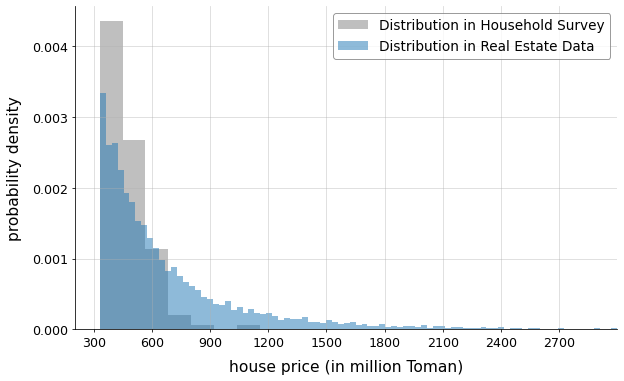

In [28]:


mianeAlpha, loc = pareto_mle(N.weight, N.totalPrice)

print(mianeAlpha) 

alpha90= mianeAlpha
tau90= loc

fig = plt.figure(figsize=(10,6))
ax1 = fig.add_subplot(1,1,1)

housePrice = np.linspace(tau90, N.totalPrice.max(), num=1000)
G2_hat = alpha90 * (tau90**alpha90) / (housePrice**(alpha90+1))
# ax1.plot(housePrice, G2_hat, label='fitted Pareto by ML', linewidth=2)

alpha90= 1/slope
print(alpha90)
tau90= loc
G2_hat = alpha90 * (tau90**alpha90) / (housePrice**(alpha90+1))
# ax1.plot(housePrice, G2_hat, label='fitted Pareto by OLS', linewidth=2)

ax1.hist(T.rent, bins=7, density=True, label='Distribution in Household Survey', alpha=0.5, color='gray')

ax1.hist(N.totalPrice, bins=2000, density=True, label='Distribution in Real Estate Data', alpha=0.5)

ax1.set_xlabel('house price (in million Toman)', fontsize=16, labelpad=10)
ax1.set_ylabel('probability density', fontsize=16, labelpad=10)
ax1.tick_params(labelsize=13)
ax1.set_xlim(200, 3000)
ax1.set_xticks(np.arange(300,3000,300))
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.legend(loc='best', edgecolor='gray', prop={'size':14}, handlelength=2.2)
ax1.grid(alpha=0.5)
plt.show()
# fig.savefig('../Figures/Python/house_tail_distribution_fit_pdf_1395.pdf',transparent=True,bbox_inches="tight")



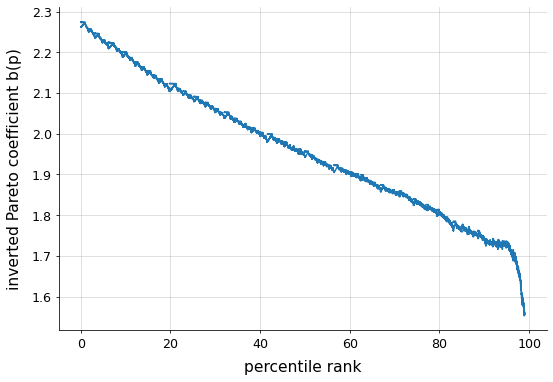

In [29]:
df = N.copy() # data.loc[(data.provNew=="01")&(data.year==1395),:].copy()

df= df.sort_values(by= ['totalPrice'])
df['Fy']= df.weight.cumsum() 
df['Fy']= df.Fy / df.weight.sum() * 100

df.sort_values(by= ['totalPrice'], inplace=True, ascending=False)

df["count"] = df.weight.cumsum()
df["sum"] = df.totalPrice.cumsum()
df["b"] = (df["sum"]/df["count"])/df["totalPrice"]

import matplotlib.pyplot as plt

df["alpha"] = df.b / (df.b - 1)

# df = df.loc[(df["Fy"].isin(np.arange(0,98,1))), :]
df = df.loc[(df["Fy"]<99), :]

fig = plt.figure(figsize=(9,6))
ax1 = fig.add_subplot(1,1,1)

ax1.plot(df['Fy'], df['b'])
ax1.set_xlabel('percentile rank' , fontsize=16, labelpad=10)
ax1.set_ylabel('inverted Pareto coefficient b(p)' , fontsize=16, labelpad=10)
ax1.tick_params(labelsize=13)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.grid(alpha=0.5)
# fig.savefig('../Figures/Python/inverted_pareto_b.pdf',transparent=True,bbox_inches="tight")
plt.show()

In [30]:
%whos DataFrame

Variable              Type         Data/Info
--------------------------------------------
HIES_summary          DataFrame       Year  Number (Iran)  N<...>  \n9            38.928  
HIES_summary_Iran     DataFrame       year  Iran_HH_number\n<...>\n9    98           38328
HouseRentTotal        DataFrame             district    area<...>1137048 rows x 8 columns]
N                     DataFrame                 id   prov   <...>[70570 rows x 25 columns]
T                     DataFrame            Unnamed: 0.1  Unn<...>\n[127 rows x 21 columns]
cpi                   DataFrame        year   cpi\n0     76 <...> 97 1.373\n22    98 1.853
data                  DataFrame                   id        <...>972584 rows x 21 columns]
df                    DataFrame                 id   prov   <...>[69864 rows x 30 columns]
expenditureTotal      DataFrame            Unnamed: 0.1  Unn<...>383229 rows x 21 columns]
houseIndex            DataFrame         year  month  totalPr<...>n\n[246 rows x 5 columns]


In [31]:
del HouseRentTotal
del N
del T
del df
del house_price_summary
del house_rent_summary
del new
del summary_statistics    

# Coverage Assumption

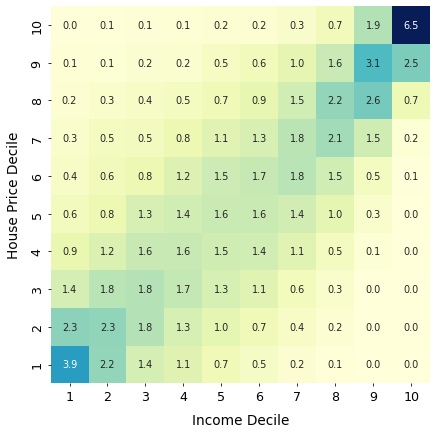

In [32]:
# joint distribution of income and house price deciles
import seaborn as sns

# df = expenditureTotal.loc[(expenditureTotal.province=="23")&(expenditureTotal.Fy>0.8),:]
df = expenditureTotal.loc[(expenditureTotal.province=="23"),:]

# Create income deciles and house price deciles
df['income_decile'] = pd.qcut(df['Fy'], 10, labels=False) + 1
df['house_price_decile'] = pd.qcut(df['FRent'], 10, labels=False) + 1

# Create a pivot table
pivot_table = df.groupby(['income_decile', 'house_price_decile']).size().unstack().fillna(0)

# Convert counts to percentages
pivot_table = pivot_table.divide(pivot_table.sum().sum()) * 100

# Plot the pivot table as a heatmap
fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

# plt.figure(figsize=(10, 8))

sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", cbar=False)
# plt.title('Percentage of observations in each income-house price-decile')
plt.xlabel('Income Decile', fontsize=14,labelpad=10)
plt.ylabel('House Price Decile', fontsize=14,labelpad=10)
ax.tick_params(labelsize=13)

# Reverse the order of the y-axis
ax.invert_yaxis()
plt.show()

# fig.savefig('../Figures/Python/income_houseprice_decile_year96_Tehran.pdf',transparent=True,bbox_inches="tight")

del df

In [33]:
# joint tax and income distribution
df = pd.read_stata(r"D:/df_cleaned_refah.dta")

# Create income deciles and house price deciles
df['income_decile'] = pd.qcut(df['Fy'], 10, labels=False) + 1
df['house_price_decile'] = pd.qcut(df['FRent'], 10, labels=False) + 1

# Create a pivot table
pivot_table = df.groupby(['income_decile', 'house_price_decile']).size().unstack().fillna(0)

# Convert counts to percentages
pivot_table = pivot_table.divide(pivot_table.sum().sum()) * 100

# Plot the pivot table as a heatmap
fig= plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

# plt.figure(figsize=(10, 8))

sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", cbar=False)
# plt.title('Percentage of observations in each income-house price-decile')
plt.xlabel('Measure of Expenditure Decile (Proxy for True Income)', fontsize=14,labelpad=10)
plt.ylabel('Tax Decile (Proxy by Reported Income)', fontsize=14,labelpad=10)
ax.tick_params(labelsize=13)

# Reverse the order of the y-axis
ax.invert_yaxis()
plt.show()

# fig.savefig('../Figures/Python/income_tax_joint_dist_1402.pdf',transparent=True,bbox_inches="tight")



FileNotFoundError: [Errno 2] No such file or directory: 'D:/df_cleaned_refah.dta'

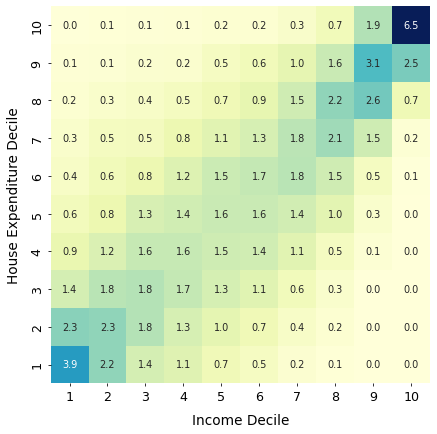

FileNotFoundError: [Errno 2] No such file or directory: 'D:/df_cleaned_refah.dta'

In [34]:
# ---- FIGURE 1: INCOME vs HOUSE PRICE DECILES ----
df1 = expenditureTotal.loc[(expenditureTotal.province=="23"), :]

df1['income_decile'] = pd.qcut(df1['Fy'], 10, labels=False) + 1
df1['house_price_decile'] = pd.qcut(df1['FRent'], 10, labels=False) + 1

pivot1 = df1.groupby(['income_decile', 'house_price_decile']).size().unstack().fillna(0)
pivot1 = pivot1.divide(pivot1.sum().sum()) * 100

# Shared color range
vmin = 0
vmax = 6.5  # slightly above the observed max 6.4%

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

sns.heatmap(
    pivot1, annot=True, fmt=".1f",
    cmap="YlGnBu", cbar=False,
    vmin=vmin, vmax=vmax
)

plt.xlabel("Income Decile", fontsize=14, labelpad=10)
plt.ylabel("House Expenditure Decile", fontsize=14, labelpad=10)
ax.tick_params(labelsize=13)
ax.invert_yaxis()

plt.show()
fig.savefig('../Figures/Python/income_houseprice_decile_year96_Tehran.pdf',transparent=True,bbox_inches="tight")



# ---- FIGURE 2: EXPENDITURE vs TAX DECILES ----
df2 = pd.read_stata(r"D:/df_cleaned_refah.dta")

df2['income_decile'] = pd.qcut(df2['Fy'], 10, labels=False) + 1
df2['house_price_decile'] = pd.qcut(df2['FRent'], 10, labels=False) + 1

pivot2 = df2.groupby(['income_decile', 'house_price_decile']).size().unstack().fillna(0)
pivot2 = pivot2.divide(pivot2.sum().sum()) * 100

# Use same vmin/vmax as Figure 1
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(1,1,1)

sns.heatmap(
    pivot2, annot=True, fmt=".1f",
    cmap="YlGnBu", cbar=False,
    vmin=vmin, vmax=vmax
)

plt.ylabel("Taxable Income", fontsize=14, labelpad=10)
plt.xlabel("Total Electronic Payment (proxy for income)", fontsize=14, labelpad=10)
ax.tick_params(labelsize=13)
ax.invert_yaxis()

plt.show()
fig.savefig('../Figures/Python/income_tax_joint_dist_1402.pdf',transparent=True,bbox_inches="tight")




In [35]:
# # joint tax and income distribution
# df = pd.read_stata(r"D:/df_cleaned_refah.dta")

# # Create income deciles and house price deciles
# df['income_decile'] = pd.qcut(df['Fy'], 10, labels=False) + 1
# df['house_price_decile'] = pd.qcut(df['Fcarplusstock'], 10, labels=False) + 1

# # Create a pivot table
# pivot_table = df.groupby(['income_decile', 'house_price_decile']).size().unstack().fillna(0)

# # Convert counts to percentages
# pivot_table = pivot_table.divide(pivot_table.sum().sum()) * 100

# # Plot the pivot table as a heatmap
# fig= plt.figure(figsize=(7,7))
# ax = fig.add_subplot(1,1,1)

# # plt.figure(figsize=(10, 8))

# sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu", cbar=False)
# # plt.title('Percentage of observations in each income-house price-decile')
# plt.xlabel('Measure of Expenditure Decile (Proxy for True Income)', fontsize=14,labelpad=10)
# plt.ylabel('Car+Stock market portfolio', fontsize=14,labelpad=10)
# ax.tick_params(labelsize=13)

# # Reverse the order of the y-axis
# ax.invert_yaxis()
# plt.show()

# # fig.savefig('../Figures/Python/.pdf',transparent=True,bbox_inches="tight")



In [36]:

# for i in np.arange(1,11):
#     halfDecile = df.loc[(df.Fy<=0.1*i + 0.01*(i==10)) &(df.Fy>0.1*(i-1)), :]
#     muHalfDecile = np.sum(halfDecile.daramad) / np.sum(df.daramad) * 100
#     print(muHalfDecile)

# print("\n now for hazineh \n \n")
# for i in np.arange(1,11):
#     halfDecile = df.loc[(df.FRent<=0.1*i + 0.01*(i==10)) &(df.FRent>0.1*(i-1)), :]
#     muHalfDecile = np.sum(halfDecile.cardpermonth_1402) / np.sum(df.cardpermonth_1402) * 100
#     print(muHalfDecile)


# Main: Fixed Threshold

In [37]:
data["provNew"] = np.nan
data.loc[(data.provinceCode.isin(['23'])), "provNew"] = "01"
data.loc[(data.provinceCode.isin(['30','07','01','03','26','02','25','09'])), "provNew"] = "02"
data.loc[( data["provNew"].isna()) , "provNew"] = "02"

expenditureTotal["provNew"] = np.nan
expenditureTotal.loc[(expenditureTotal.province.isin(['23'])), "provNew"] = "01"
expenditureTotal.loc[(expenditureTotal.province.isin(['30','07','01','03','26','02','25','09'])), "provNew"] = "02"
expenditureTotal.loc[(expenditureTotal["provNew"].isna()), "provNew"] = "02"


In [38]:
# # !pip install pyfixest
# import pyfixest as pf

# df = expenditureTotal.loc[(expenditureTotal["provNew"]=="01")&(expenditureTotal["FRent"]>=0.8)&(expenditureTotal.Daramad!=0),:]
# fit = pf.feols("LnHazineh ~ LnRent | year", data=df)
# fit.summary()

# df = expenditureTotal.loc[(expenditureTotal["provNew"]=="02")&(expenditureTotal["FRent"]>=0.8)&(expenditureTotal.Daramad!=0),:]
# fit = pf.feols("LnHazineh ~ LnRent | year", data=df)
# fit.summary()

# df = expenditureTotal.loc[(expenditureTotal["provNew"]=="03")&(expenditureTotal["FRent"]>=0.8)&(expenditureTotal.Daramad!=0),:]
# fit = pf.feols("LnHazineh ~ LnRent | year", data=df)
# fit.summary()

In [39]:
# df = expenditureTotal.loc[(expenditureTotal.Daramad!=0)&(expenditureTotal.rent!= 0) ,["LnHazineh","LnRent","year","provNew","Fy","FRent"]]
# df.to_stata("./data/HIES_binsreg.dta")

In [40]:
# province_set=["02","03","01"]
province_set=["01"]


""" Initialize the Output dataframes """
result = np.zeros(shape=(10,1))
result = pd.DataFrame(result, columns=["year"])
result.year = np.arange(1389,1399)

Iran = result.copy()
alpha_beta_Tehran = result.copy()
tau_x0 = result.copy()

share = result.copy()
shareIran = result.copy()
shareTen= result.copy()
shareFive= result.copy()
shareOne= result.copy()
shareTenIran= result.copy()
shareFiveIran= result.copy()
shareOneIran= result.copy()
table= result.copy()


"""--------------------------------------------------------------------"""
""" LET'S GO """

different_threshold_of_top_HIES = [90] #[85,95,90] 

for tauThreshold in different_threshold_of_top_HIES: 
    
    for year in np.arange(89,99):

        """
            Estimating theta from survey    
        """
        expenditure = expenditureTotal.loc[(expenditureTotal.year==year),:]

        expenditure = expenditure.loc[(expenditure.hazinehPerCapita.notna()) & (expenditure.LnRent.notna())
                                     &(expenditure.weight.notna()) & (expenditure.hazinehPerCapita != 0),:]

        """ calculating empirical cumulative density function """
        # expenditure.sort_values(by=["province","hazinehPerCapita"],inplace=True)
        # expenditure['Fy'] = expenditure.groupby('province')['weight'].apply(lambda x: x.cumsum() / x.sum())
                        
        # expenditure.sort_values(by=["province","rent"],inplace=True)
        # expenditure['FRent'] = expenditure.groupby('province')['weight'].apply(lambda x: x.cumsum() / x.sum())
        
        """-------------------------------------------------"""
        Sample = pd.DataFrame([])

        for flag, prov in enumerate(province_set):
            provName = next(key for key, value in provinceCodeEng.items() if value == prov)

            Tehran= expenditure[expenditure.provNew.isin([prov])]
            Tehran= Tehran.sort_values(by= ['hazinehPerCapita'])
            Tehran['Fy']= Tehran.weight.cumsum() 
            Tehran['Fy']= Tehran.Fy / Tehran.weight.sum()

            # -----------------------------------------
            """ calculating alpha from house price data """
            new = data[(data["provNew"].isin([prov])) & (data['year']==(1300+year) )]

            # define new variables
            new.sort_values(by=["provNew","totalPrice"],inplace=True)
            new['Gy'] = new.groupby('provNew')['weight'].apply(lambda x: x.cumsum() / x.sum()).reset_index(level=['provNew'], drop=True)

            # topCodeRent = new.loc[(new.Gy>0.999),"totalPrice"].min()
            # new.loc[(new.Gy>0.999),"totalPrice"] = topCodeRent

            """ 
                calculating alpha from data for different top share of data
                alpha: top house price data pareto tail index
            """
            # space=np.arange(0.5, 0.99, 0.05)
            # alpha=np.zeros(shape=(19,6))

            # for index,topPercentile in enumerate(space):
                
            #     # Rent_Top_Incomes_HIES = Tehran.loc[(Tehran.Fy>(topPercentile-0.02)) & (Tehran.Fy<(topPercentile+0.02)), "rent"].mean()
            #     # Price_to_Mortgage_Ratio = price_rent_ratio.loc[(price_rent_ratio.year==(1300+year)),"ratio_mean"].values[0]
            #     # TopRentmean= Price_to_Mortgage_Ratio * Rent_Top_Incomes_HIES * (100/3) / 10000000 
            #     # N = new[new.totalPrice >= topPercentile]

            #     N=new[new.Gy>=topPercentile]
            #     N.sort_values('totalPrice',inplace=True)
            #     N.reset_index(drop=True, inplace=True)

            #     # new estimation method with Maximum Likelihood ------------------------------
            #     # Fit Pareto distribution to the variable
            #     loc = N.totalPrice.min()
            #     n = N.shape[0]
            #     alpha_N = (n) / (N.LnPrice.sum() - n*np.log(loc))
            #     # ---------------------------------------------------------------------------

            #     N['G2y']=(N.index+1) / (N['totalPrice'].count())  
            #     N.drop(N.tail(1).index,inplace=True)
            #     N['Xvariable']= -np.log(1-N['G2y'])     
            #     """ dropping nan, inf from data to avoid error in regression """
            #     N.replace(np.inf , np.nan,inplace=True)
            #     N.dropna(subset=['LnPrice', 'Xvariable'], how="all",inplace=True)

            #     x=N['Xvariable']
            #     y=N['LnPrice']- np.log(loc)

            #     results = sm.OLS(y,x,missing='drop').fit()
            #     alpha[index,0]=topPercentile
            #     alpha[index,1]= alpha_N #1/results.params[1]
            #     se=results.bse[0]
            #     alpha[index,4]=se
            #     alpha[index,2]= 1/(1/alpha_N + 2*se) 
            #     alpha[index,3]= 1/(1/alpha_N - 2*se)
            #     alpha[index,5]= 1/results.params[0]

            # -----------------------------------------
            """ alpha from new approach: tau -> rent -> house price -> alpha """
            # tau = tauThreshold * 1e7 #* cpi.loc[(cpi.year==year), : ].cpi.values[0]
            tau = Tehran.loc[(Tehran.Fy>=(tauThreshold/100)),"hazinehPerCapita"].min()
            lambda_tau = 1 - Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
            
            # Rent_Top_Incomes_HIES = Tehran.loc[(Tehran.Fy> 1-lambda_tau-0.02)&(Tehran.Fy< 1-lambda_tau+0.02), "rent"].mean()
            Rent_Top_Incomes_HIES = Tehran.loc[(Tehran.hazinehPerCapita>(0.9*tau)) & (Tehran.hazinehPerCapita<(1.1*tau) ), "rent"].mean()
            # Rent_Top_Incomes_HIES = Tehran.loc[(Tehran.FRent>= (tauThreshold/100)), "rent"].min()
            # tau = Tehran.loc[(Tehran.FRent> (tauThreshold/100)-0.02)&(Tehran.FRent< (tauThreshold/100)+0.02), "hazinehPerCapita"].mean()

            Price_to_Mortgage_Ratio = price_rent_ratio.loc[price_rent_ratio.year==f"{1300+year+621}","ratio_mean"].values[0]
            # Price_to_Mortgage_Ratio = 5

            TopRentmean= Rent_Top_Incomes_HIES * Price_to_Mortgage_Ratio * (100/3) / 10000000
            
            # xx = new.loc[new.totalPrice>TopRentmean, "Gy"].min()
            # print(xx)

            N = new[new.totalPrice>TopRentmean]
            N.sort_values('totalPrice',inplace=True)
            N.reset_index(drop=True, inplace=True)  
            N['G2y'] = N.weight.cumsum()
            N['G2y'] = N.G2y / N.weight.sum()

            # new estimation method with Maximum Likelihood ------------------------------
            # Fit Pareto distribution to the variable
            loc = N.totalPrice.min()
            n = N.shape[0]
            mianeAlpha = (n) / (N.LnPrice.sum() - n*np.log(loc))
            # print(mianeAlpha) 

            # ----------------------------------------------------------------------------
            # dropping nan, inf from data to avoid error in regression            
            N['Xvariable']= -np.log(1-N['G2y'])     
            # N.drop(N.tail(1).index,inplace=True)

            # N['G2y']=(N.index+1) / (N['totalPrice'].count())  
            N.replace(np.inf , np.nan,inplace=True)
            N.dropna(subset=['LnPrice', 'Xvariable'], how="all",inplace=True)
            x=N['Xvariable']
            y=N['LnPrice'] - np.log(loc)
            results = sm.OLS(y,x,missing='drop').fit()
            mianeAlpha2 = 1/results.params[0]
            seAlpha=results.bse[0]

            # estimate the share of top house residents in the survey
            lambda_house_survey = 1 - Tehran.loc[(Tehran.rent>=Rent_Top_Incomes_HIES),:].FRent.min()
            result.loc[(result.year==(1300+year)) , "lambdaHouseSurv"+prov] = lambda_house_survey *100
            # print(lambda_house_survey *100)

            # ----------------------------------------------------------------------------
            # """ first Approach theta estimated """
            # # top_rent = Tehran.loc[Tehran['hazinehPerCapita']>=tau,:]
            # # top_rent = Tehran.loc[Tehran['Fy']>= 0.7,:]
            # top_rent = Tehran.loc[(Tehran['FRent']>=0.80)&(Tehran.LnHazineh.notna()) & (Tehran.LnRent.notna()) & (Tehran.weight.notna()), :]
            # x=top_rent['LnRent']
            # y=top_rent['LnHazineh']
            # results = mt.reg(top_rent, 'LnHazineh', 'LnRent', addcons=True ,awt_name='weight')
            # mianeBeta = results.beta['LnRent']
            # seBeta = results.se['LnRent']
            # # print(mianeBeta)

            # """ calculating confidence interval for theta second approach """
            # # seBeta = theta_hat.loc[(theta_hat.percentile>=0.80)
            # #          &(theta_hat.percentile<=0.95),"beta_se"].quantile(q=0.5)

            # a=np.random.normal(loc=1/mianeAlpha,scale=seAlpha,size=1000000)

            # b=np.random.normal(loc= mianeBeta, scale=seBeta, size=1000000)
            # d=1/(a*b)
            # d=pd.DataFrame(d)

            # theta_hat2_lower = d.quantile(q=0.05)[0]
            # theta_hat2_upper = d.quantile(q=0.95)[0]   


            # ----------------------------------------------------------------------------
            # estimate a non-linear model
            topPercentile = 0.7
            rentTehran = Tehran.loc[(Tehran['FRent']>=topPercentile) , :].copy()
            # rentTehran["LnRent"] = rentTehran.LnRent - np.log(Rent_Top_Incomes_HIES)
            rentTehran = rentTehran.loc[(rentTehran['LnRent'].notna()) & (rentTehran['LnHazineh'].notna()), :]
            rentTehran["LnRent2"] = rentTehran.LnRent**2
            rentTehran["LnRent3"] = rentTehran.LnRent**3
            
            # Define the dependent variable
            y = rentTehran['LnHazineh']
            X = rentTehran.loc[:, ['LnRent']]
            weights = rentTehran['weight']
            model = sm.WLS(y, sm.add_constant(X), weights=weights)
            results = model.fit()

            # Get the slope, constant, and R-squared
            slope_0 = results.params['const']
            slope_1 = results.params['LnRent'] # 0.787 * (prov=="01") + 0.612 * (prov=="02") + 0.527 * (prov=="03")
            slope_1_year = results.params['LnRent']
            slope_2 = 0 #results.params['LnRent2']
            slope_3 = 0 #results.params['LnRent3']
            # slope_se = results.bse['LnRent']
            r_squared = results.rsquared

            print(slope_1)

            # ----------------------------------------------------------------------------
            # fig= plt.figure(figsize=(9.5,6))
            # ax1 = fig.add_subplot(1,1,1)
            
            # x_plot=np.linspace(rentTehran.LnRent.min(), rentTehran.LnRent.max(), 200)
            # ax1.plot(x_plot, x_plot*x_plot*slope_2 + x_plot*slope_1 + slope_0 , linewidth=2.9,label="regression line",color="black")
            
            # ax1.scatter(rentTehran['LnRent'], rentTehran['LnHazineh'] , color="gray", label="data")
            # ax1.set_xlabel('house rental value (in log)', fontsize=14,labelpad=10)
            # ax1.set_ylabel('household total income (in log)', fontsize=14,labelpad=10)
            # ax1.grid(axis= 'y',alpha=0.5)
            # ax1.tick_params(labelsize=13)
            # ax1.spines['right'].set_visible(False)
            # ax1.spines['top'].set_visible(False)
            # ax1.text(0.95, 0.02, f'R2= {r_squared:.2f}', transform=ax1.transAxes, verticalalignment='bottom', horizontalalignment='right', fontsize=12)
            # plt.show()

            # ----------------------------------------------------------------------------
            # Gini for the province    
            thetaEstimated = mianeAlpha2 / slope_1
            
            """ filling the 'alpha_beta_Tehran' output for report """
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"alpha"] = mianeAlpha
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"beta"] = slope_1
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_hat"] = thetaEstimated
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_hat_lower"] = theta_hat2_lower 
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_hat_upper"] = theta_hat2_upper
            
            # theta["percentile"] = np.round(theta.percentile,decimals=2)
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta"] = theta.loc[(theta.percentile==0.94),"theta"].values[0]
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_lower"] = theta.loc[(theta.percentile==0.94),"theta_lower"].values[0]
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_upper"] = theta.loc[(theta.percentile==0.94),"theta_upper"].values[0]
           
            """ Filling the 'tau_x0' output data frame """
            # tau_x0.loc[tau_x0.year==(1300+year),"tau"] = tau / 1e7
            # tau_x0.loc[tau_x0.year==(1300+year),"tau_real"] = (tau / 1e7) * cpi.loc[(cpi.year==year), : ].cpi.values[0]
            # tau_x0.loc[tau_x0.year==(1300+year),"R0"]  = Rent_Top_Incomes_HIES * (100/3) / 1e7
            # tau_x0.loc[tau_x0.year==(1300+year),"x0"]  = TopRentmean

            # ----------------------------------------------------------------------------
            """ estimating lambda """
            # # estimate true share of top house residents
            # T = Tehran.loc[(Tehran.rent<Rent_Top_Incomes_HIES),:]
            # T= T.sort_values(by= ['rent'])
            # T['Gy'] = T.weight.cumsum()
            # T['Gy'] = T.Gy / T.weight.sum()
            # results = mt.reg( T.loc[(T.Gy>0.9),:], 'Gy', 'rent', addcons=True)
            # g1Tau = results.beta['rent']
            # del T

            # N = new[new.totalPrice>TopRentmean]
            # N = N.sort_values(by=['totalPrice'])
            # N['totalPrice'] = N.totalPrice * 10000000 / (Price_to_Mortgage_Ratio * (100/3))
            # N['Gy'] = N.weight.cumsum()
            # N['Gy'] = N.Gy / N.weight.sum()
            # results = mt.reg( N.loc[(N.Gy<0.1),:], 'Gy', 'totalPrice', addcons=True)
            # g2Tau = results.beta['totalPrice']
            # # print(np.log(N.totalPrice.max()))
            # # print(np.log(Tehran.rent.max()))

            # # g2Tau= mianeAlpha / Rent_Top_Incomes_HIES
            # lambda_house = g1Tau / (g1Tau+g2Tau)
            # result.loc[(result.year==(1300+year)) , "lambdaHouse"+prov] = lambda_house *100
            # # print(lambda_house *100)


            T = Tehran.loc[(Tehran.hazinehPerCapita< tau), :]
            T= T.sort_values(by= ['hazinehPerCapita'])
            T['Fy']= T.Fy / T.weight.sum()
            T['Fy']= T.weight.cumsum() 
            results = mt.reg(
                T.loc[(T.Fy>0.9),:],      # DataFrame
                'Fy',                      # Dependent var (string)
                'hazinehPerCapita',        # Independent var(s) (string or list of strings)
                addcons=True
                )

            f1Tau= results.beta['hazinehPerCapita']
            f2Tau= thetaEstimated / tau * 1e7
            landa= f1Tau / (f1Tau+f2Tau)
            result.loc[(result.year==(1300+year)) , "lambda"+prov]        = landa *100

            landaSurvey = 1-Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
            result.loc[(result.year==(1300+year)) , "lambdaSurvey"+prov]  = landaSurvey *100




            # estimate mean income using survey
            # muSurvey = np.average(Tehran.hazinehPerCapita, weights=Tehran.weight)

            # ----------------------------------------------------------------------------
            # approach 1 -------------------
        
            # N_sample_size = 100000
            # TopIncomesample = (np.random.pareto(mianeAlpha, N_sample_size) + 1) * Rent_Top_Incomes_HIES 
            # TopIncomesample = pd.DataFrame(TopIncomesample,columns=["rent"])
            # TopIncomesample["LnRent"] = np.log(TopIncomesample.rent) 
            # TopIncomesample["LnRent"] = np.log(TopIncomesample.rent) - np.log(Rent_Top_Incomes_HIES)

            # TopIncomesample = new[new.totalPrice>TopRentmean]
            # TopIncomesample["rent"] = TopIncomesample.totalPrice * 10000000 / (Price_to_Mortgage_Ratio * (100/3))
            # TopIncomesample["LnRent"] = np.log(TopIncomesample.totalPrice * 10000000 / (Price_to_Mortgage_Ratio * (100/3)) )
            # TopIncomesample = TopIncomesample[["LnRent","rent"]]
            # N_sample_size = TopIncomesample.shape[0]
            # # TopIncomesample["LnRent"] = TopIncomesample.LnRent - np.log(Rent_Top_Incomes_HIES)
            
            # # TopIncomesample["hazinehPerCapita"] = np.exp(np.log(tau) + slope_1*TopIncomesample.LnRentDev)
            # TopIncomesample["hazinehPerCapita"] = np.exp(slope_0 + slope_1*TopIncomesample.LnRent + slope_2*(TopIncomesample.LnRent**2) + slope_3*(TopIncomesample.LnRent**3))
            
            # sigma_weight_low_income = Tehran.loc[(Tehran.rent<Rent_Top_Incomes_HIES),:].weight.sum()
            # TopIncomesample["weight"] = sigma_weight_low_income / ((1/lambda_house - 1) * N_sample_size)
            # TopIncomesample["top"]=1 
            # Tehran["top"]=0
            # TehranSample = pd.concat([TopIncomesample, Tehran.loc[(Tehran.rent<Rent_Top_Incomes_HIES),["weight","hazinehPerCapita", "rent"]] ],axis=0)


            # approach 2 -------------------
            # # create the simulated data for the province
            N_sample_size = 1000000
            TopIncomesample = (np.random.pareto(thetaEstimated, N_sample_size) + 1) * tau
            TopIncomesample = pd.DataFrame(TopIncomesample,columns=["hazinehPerCapita"])
            
            sigma_weight_low_income = Tehran.loc[(Tehran.hazinehPerCapita<tau),:].weight.sum()
            TopIncomesample["weight"] = sigma_weight_low_income / ((1/landa - 1) * N_sample_size)
            TehranSample = pd.concat([TopIncomesample, Tehran.loc[(Tehran.hazinehPerCapita<tau),["weight","hazinehPerCapita"]] ],axis=0)


            # re-weight to balance population distribution
            TehranSample["weight"] = TehranSample["weight"] * np.sum(Tehran.weight) / np.sum(TehranSample.weight)
            
            TehranSample= TehranSample.sort_values(by= ['hazinehPerCapita'])
            TehranSample['Fy']= TehranSample.weight.cumsum() 
            TehranSample['Fy']= TehranSample.Fy / TehranSample.weight.sum()          

            Sample = pd.concat([Sample, TehranSample], axis=0)
            """ Save Simulated Data for Tehran """
            #TehranSample.to_csv(f'../Data/Simulated Sample/Simulated{year}.csv')
            #TehranSample.to_stata(f'../Data/Simulated Sample/Simulated{year}.dta')


        # ----------------------------------------------------------------------------
        """ Simulated Data for the whole country """
        expenditure["top"] = 0
        
        IranSample = pd.concat([Sample, expenditure.loc[~(expenditure.provNew.isin(province_set)),["weight","hazinehPerCapita","top","rent"]] ],axis=0)

        IranSample= IranSample.sort_values(by= ['hazinehPerCapita'])
        IranSample['Fy']= IranSample.weight.cumsum()

        IranSample['Fy']= IranSample.Fy / IranSample.weight.sum()

        # IranSample.to_csv(f'../Data/Simulated Sample/IranSample{year}.csv')
        # TehranSample.to_csv(f'../Data/Simulated Sample/TehranSample{year}.csv')
        
        # ----------------------------------------------------------------------------
        """ Filling Iran dataframe calculating empirical cumulative density function """

        # new code as replacement -------------------------------
        # IranLandaSurvey = 1 - expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].Fy.min()
        # Iran.loc[(Iran.year==(1300+year)),"lambdaSurvey"] = IranLandaSurvey *100

        # landaTotal = 1 - IranSample.loc[(IranSample.hazinehPerCapita>=tau),:].Fy.min()
        # Iran.loc[(Iran.year==(1300+year)),"lambda"] = landaTotal *100

        # muTopIran = np.average(expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].hazinehPerCapita, weights=expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].weight)
        # muKol = np.average(expenditure.hazinehPerCapita, weights=expenditure.weight)
        # sTotalIranSurvey = expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].weight.sum()*muTopIran/(muKol*expenditure.weight.sum())
        # Iran.loc[(Iran.year==(1300+year)),"sSurvey"] = sTotalIranSurvey *100

        # muTopIranEst = np.average(IranSample.loc[(IranSample.hazinehPerCapita>=tau),:].hazinehPerCapita, weights=IranSample.loc[(IranSample.hazinehPerCapita>=tau),:].weight)
        # muKolEst = np.average(IranSample.hazinehPerCapita, weights=IranSample.weight)
        # sTotalIranSurveyEst = IranSample.loc[(IranSample.hazinehPerCapita>=tau),:].weight.sum()*muTopIranEst/(muKolEst*IranSample.weight.sum())
        # Iran.loc[(Iran.year==(1300+year)),"s"] = sTotalIranSurveyEst *100


        GiniIranSurvey = gini(expenditure.hazinehPerCapita, w=expenditure.weight)
        Iran.loc[(Iran.year==(1300+year)),"GiniSurvey"] = GiniIranSurvey *100
        
        GiniIran = gini(IranSample.hazinehPerCapita, w=IranSample.weight)
        Iran.loc[(Iran.year==(1300+year)),"Gini"] = GiniIran *100


        # new code replacement ------------------------------
        # landaSurvey = 1-Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
        # result.loc[(result.year==(1300+year)) , "lambdaSurvey"+prov]  = landaSurvey *100

        # landaTehran = 1 - TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:].Fy.min()
        # result.loc[(result.year==(1300+year)) , "lambda"+prov]        = landaTehran *100

        
        GiniSurvey = gini(Tehran.hazinehPerCapita, w=Tehran.weight)
        result.loc[(result.year==(1300+year)) , "GiniSurvey"+prov]    = GiniSurvey *100

        Gini = gini(TehranSample.hazinehPerCapita, w=TehranSample.weight)
        result.loc[(result.year==(1300+year)) , "Gini"+prov+f"_{tauThreshold}"] = Gini *100


        # muTopTehranSurv = np.average(Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].hazinehPerCapita, weights=Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].weight)
        # muKolTehranSurv = np.average(Tehran.hazinehPerCapita, weights=Tehran.weight)
        # sTotalTehranSurvey = Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].weight.sum()*muTopTehranSurv/(muKolTehranSurv*Tehran.weight.sum())
        # result.loc[(result.year==(1300+year)) , "sSurvey"+prov] = sTotalTehranSurvey *100

        # muTopTehranEst = np.average(TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:].hazinehPerCapita, weights=TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:].weight)
        # muKolTehranEst = np.average(TehranSample.hazinehPerCapita, weights=TehranSample.weight)
        # sTehran = TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:].weight.sum()*muTopTehranEst/(muKolTehranEst*TehranSample.weight.sum())
        # result.loc[(result.year==(1300+year)) , "s"+prov] = sTehran *100


        # ----------------------------------------------------------------------------
        """ estimating each decile share """    
        muTehranEst = np.sum(TehranSample.hazinehPerCapita * TehranSample.weight)

        # Tehran['hazinehPerCapita'] = np.around(Tehran.hazinehPerCapita/10000, decimals=5)
        muSurveyTehran = np.sum(Tehran.hazinehPerCapita * Tehran.weight )        
        
        # decile income share in Tehran
        for i in [1,2,3,4,5,6,7,8,9,10]:
            decile = TehranSample.loc[(TehranSample.Fy<=0.1*i + 0.01*(i==10))&(TehranSample.Fy>0.1*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight)
            share.loc[(share.year==(1300+year)), f"{i}DecileEst"] = 100*muDecile/muTehranEst

            decile = Tehran.loc[(Tehran.Fy<=0.1*i + 0.01*(i==10))&(Tehran.Fy>0.1*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight )
            share.loc[(share.year==(1300+year)), f"{i}DecileSurv"] = 100*muDecile/muSurveyTehran
        
        # quintile income share in Tehran
        for i in [1,2,3,4,5]:
            decile = TehranSample.loc[(TehranSample.Fy<=(0.2*i + 0.01*(i==5))) &(TehranSample.Fy>0.2*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight)
            share.loc[(share.year==(1300+year)), f"{i}est"] = 100*muDecile/muTehranEst
        
        for i in [1,2,3,4,5]:
            decile = Tehran.loc[(Tehran.Fy<=(0.2*i + 0.01*(i==5) )) & (Tehran.Fy>0.2*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight )
            share.loc[(share.year==(1300+year)), f"{i}surv"] = 100*muDecile/muSurveyTehran

        # ----------------------------------------------------------------------------
        #         estimating each 10%    
        for i in np.arange(1,11):
            halfDecile = TehranSample.loc[(TehranSample.Fy<=0.1*i + 0.01*(i==10))&(TehranSample.Fy>0.1*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareTen.loc[(shareTen.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muTehranEst
            shareTen.loc[(shareTen.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muTehranEst

            halfDecile = Tehran.loc[(Tehran.Fy<=0.1*i + 0.01*(i==10))&(Tehran.Fy>0.1*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareTen.loc[(shareTen.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muSurveyTehran
         
        #         estimating each half decile share(each 5%)    
        for i in np.arange(1,21):
            halfDecile = TehranSample.loc[(TehranSample.Fy<=0.05*i + 0.01*(i==20))&(TehranSample.Fy>0.05*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareFive.loc[(shareFive.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muTehranEst
            shareFive.loc[(shareFive.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muTehranEst

            halfDecile = Tehran.loc[(Tehran.Fy<=0.05*i + 0.01*(i==20))&(Tehran.Fy>0.05*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareFive.loc[(shareFive.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muSurveyTehran

        #         estimating each 1 p share(each 1%)    
        for i in np.arange(1,101):
            halfDecile = TehranSample.loc[(TehranSample.Fy<=0.01*i + 0.01*(i==100)) &(TehranSample.Fy>0.01*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareOne.loc[(shareOne.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muTehranEst
            shareOne.loc[(shareOne.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muTehranEst

        for i in np.arange(1,101):
            halfDecile = Tehran.loc[(Tehran.Fy<=0.01*i + 0.01*(i==100)) &(Tehran.Fy>0.01*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareOne.loc[(shareOne.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muSurveyTehran
              
        # ----------------------------------------------------------------------------
        # estimating each 10%    Iran
        expenditure.sort_values(by="hazinehPerCapita", inplace=True)
        expenditure["Fy"] = expenditure["weight"].cumsum() / expenditure["weight"].sum()
        muIranSurv = np.sum(expenditure.hazinehPerCapita * expenditure.weight)
        muIranEst = np.sum(IranSample.hazinehPerCapita * IranSample.weight)

        # quintile income share in Tehran
        for i in [1,2,3,4,5]:
            decile = IranSample.loc[(IranSample.Fy<=(0.2*i + 0.01*(i==5))) &(IranSample.Fy>0.2*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight)
            shareIran.loc[(share.year==(1300+year)), f"{i}est"] = 100*muDecile/muIranEst
        
        for i in [1,2,3,4,5]:
            decile = expenditure.loc[(expenditure.Fy<=(0.2*i + 0.01*(i==5) )) & (expenditure.Fy>0.2*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight )
            shareIran.loc[(share.year==(1300+year)), f"{i}surv"] = 100*muDecile/muIranSurv


        for i in np.arange(1,11):
            halfDecile = IranSample.loc[(IranSample.Fy<=0.1*i + 0.01*(i==10)) &(IranSample.Fy>0.1*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareTenIran.loc[(shareTenIran.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muIranEst
            shareTenIran.loc[(shareTenIran.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muIranEst

            halfDecile = expenditure.loc[(expenditure.Fy<=0.1*i + 0.01*(i==10)) &(expenditure.Fy>0.1*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareTenIran.loc[(shareTenIran.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muIranSurv
         
        #         estimating each half decile share(each 5%)    Iran
        for i in np.arange(1,21):
            halfDecile = IranSample.loc[(IranSample.Fy<=0.05*i + 0.01*(i==20)) &(IranSample.Fy>0.05*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareFiveIran.loc[(shareFiveIran.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muIranEst
            shareFiveIran.loc[(shareFiveIran.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muIranEst

            halfDecile = expenditure.loc[(expenditure.Fy<=0.05*i + 0.01*(i==20)) &(expenditure.Fy>0.05*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareFiveIran.loc[(shareFiveIran.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muIranSurv

        #         estimating each 1 p share(each 1%)    Iran
        for i in np.arange(1,101):
            halfDecile = IranSample.loc[(IranSample.Fy<=0.01*i + 0.01*(i==100)) &(IranSample.Fy>0.01*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareOneIran.loc[(shareOneIran.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muIranEst
            shareOneIran.loc[(shareOneIran.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muIranEst
    
            halfDecile = expenditure.loc[(expenditure.Fy<=0.01*i + 0.01*(i==100)) &(expenditure.Fy>0.01*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareOneIran.loc[(shareOneIran.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muIranSurv
    
        result.loc[(result.year==(1300+year)), f"Gini"] = gini(TehranSample.hazinehPerCapita, w=TehranSample.weight)


        table.loc[(table.year==(1300+year)),"delta"] = slope_0
        table.loc[(table.year==(1300+year)),"beta"] = slope_1_year

        tau = Tehran.loc[(Tehran.Fy>=0.9),"hazinehPerCapita"].min()
        lambda_sur = 1 - Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
        lambda_est = 1 - TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),"Fy"].min()
        
        # table.loc[(table.year==(1300+year)),"lambda_sur"] = lambda_sur
        table.loc[(table.year==(1300+year)),"lambda_est"] = lambda_est

        # tau = expenditure.loc[(expenditure.Fy>=0.9),"hazinehPerCapita"].min()
        # lambda_sur = 1 - expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].Fy.min()
        # lambda_est = 1 - IranSample.loc[(IranSample.hazinehPerCapita>=tau),"Fy"].min()
        
        # table.loc[(table.year==(1300+year)),"lambda_sur_Iran"] = lambda_sur
        # table.loc[(table.year==(1300+year)),"lambda_est_Iran"] = lambda_est

        table.loc[(table.year==(1300+year)),"alpha"] = mianeAlpha

        T = Tehran.loc[(Tehran.FRent>= (90/100)), :]
        mianeAlpha_surv, loc_suv = pareto_mle(T.weight, T.rent)
        table.loc[(table.year==(1300+year)),"alpha_surv"] = mianeAlpha_surv


        T = Tehran.loc[(Tehran.hazinehPerCapita>=tau),:]
        theta_surv, loc = pareto_mle(T.weight, T.hazinehPerCapita)
        table.loc[(table.year==(1300+year)),"theta_surv"] = theta_surv

        T=  TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:]
        theta_est, loc = pareto_mle(T.weight, T.hazinehPerCapita)
        table.loc[(table.year==(1300+year)),"theta_est"] = theta_est




del new
# del Sample
# del Tehran
del N
# del samples
del expenditure
# del topIncome 
# del lowIncome 
# del rent 

tau_x0


0.7918862543312152
0.7341501128216116
0.7401841199756657
0.8331331238832945
0.697242163946273
0.7095911682642617
0.8225390186846002
0.6399675973973763
0.7711313291638249
0.7937302182757564


,year
0,1389
1,1390
2,1391
3,1392
4,1393
5,1394
6,1395
7,1396
8,1397
9,1398


In [41]:
shareTenParametric = shareTen.copy()
shareFiveParametric = shareFive.copy()
shareOneParametric = shareOne.copy()

shareTenIranParametric = shareTenIran.copy()
shareFiveIranParametric = shareFiveIran.copy()
shareOneIranParametric = shareOneIran.copy()

In [42]:
# import numpy as np
# import statsmodels.api as sm
# from scipy.stats import gaussian_kde

# def mc_crary_test(data, variable, weight, cutoff, bandwidth=0.1):
#     # Data preparation
#     df = data[[variable, weight]].dropna()
#     df['distance'] = df[variable] - cutoff
#     df['left'] = df['distance'] < 0

#     # Separate left and right of the cutoff
#     left_data = df.loc[df['left']]
#     right_data = df.loc[~df['left']]

#     # Kernel Density Estimation
#     kde_left = gaussian_kde(left_data[variable], weights=left_data[weight])
#     kde_right = gaussian_kde(right_data[variable], weights=right_data[weight])

#     # Evaluate density at the cutoff
#     density_left = kde_left(cutoff)
#     density_right = kde_right(cutoff)

#     # Test statistic: difference in log densities
#     log_diff = np.log(density_right) - np.log(density_left)
#     return log_diff

# # Example usage
# cutoff = hazinehPerCapitaMin
# IranSample['weight2'] = 1
# log_density_diff = mc_crary_test(data=IranSample, variable='hazinehPerCapita', weight='weight2', cutoff=cutoff)

# print(f"Log Density Difference at {cutoff}: {log_density_diff}")

# # Define a function to compute density difference
# def density_difference(data, variable, weight, cutoff, bandwidth=1e6):
#     left_data = data.loc[data[variable] < cutoff]
#     right_data = data.loc[data[variable] > cutoff]
    
#     kde_left = gaussian_kde(left_data[variable], weights=left_data[weight])
#     kde_right = gaussian_kde(right_data[variable], weights=right_data[weight])
    
#     density_left = kde_left(cutoff)
#     density_right = kde_right(cutoff)
    
#     return density_right - density_left

# # Bootstrap procedure
# def bootstrap_test(data, variable, weight, cutoff, num_samples=1000):
#     observed_diff = density_difference(data, variable, weight, cutoff)
#     diffs = []
    
#     for _ in range(num_samples):
#         sampled_data = data.sample(frac=1, replace=True)
#         diffs.append(density_difference(sampled_data, variable, weight, cutoff))
    
#     p_value = (np.abs(diffs) >= np.abs(observed_diff)).mean()
#     return observed_diff, p_value

# # Example usage
# observed_diff, p_value = bootstrap_test(IranSample, 'hazinehPerCapita', 'weight2', hazinehPerCapitaMin)
# p_value
# # print(f"Observed Density Difference: {observed_diff:.4f}")
# # print(f"P-value: {p_value:.4f}")


In [ ]:
# province_set=["02","03","01"]
province_set=["01"]


""" Initialize the Output dataframes """
result = np.zeros(shape=(10,1))
result = pd.DataFrame(result, columns=["year"])
result.year = np.arange(1389,1399)

Iran = result.copy()
alpha_beta_Tehran = result.copy()
tau_x0 = result.copy()

share = result.copy()
shareIran = result.copy()
shareTen= result.copy()
shareFive= result.copy()
shareOne= result.copy()
shareTenIran= result.copy()
shareFiveIran= result.copy()
shareOneIran= result.copy()
table= result.copy()


"""--------------------------------------------------------------------"""
""" LET'S GO """

different_threshold_of_top_HIES = [90] # [85,95,90]

for tauThreshold in different_threshold_of_top_HIES: 
    
    for year in np.arange(89,99):

        """
            Estimating theta from survey    
        """
        expenditure = expenditureTotal.loc[(expenditureTotal.year==year),:]

        expenditure = expenditure.loc[(expenditure.hazinehPerCapita.notna()) & (expenditure.LnRent.notna())
                                     &(expenditure.weight.notna()) & (expenditure.hazinehPerCapita != 0),:]

        """ calculating empirical cumulative density function """
        # expenditure.sort_values(by=["province","hazinehPerCapita"],inplace=True)
        # expenditure['Fy'] = expenditure.groupby('province')['weight'].apply(lambda x: x.cumsum() / x.sum())
                        
        # expenditure.sort_values(by=["province","rent"],inplace=True)
        # expenditure['FRent'] = expenditure.groupby('province')['weight'].apply(lambda x: x.cumsum() / x.sum())
        
        """-------------------------------------------------"""
        Sample = pd.DataFrame([])

        for flag, prov in enumerate(province_set):
            provName = next(key for key, value in provinceCodeEng.items() if value == prov)

            Tehran= expenditure[expenditure.provNew.isin([prov])]
            Tehran= Tehran.sort_values(by= ['hazinehPerCapita'])
            Tehran['Fy']= Tehran.weight.cumsum() 
            Tehran['Fy']= Tehran.Fy / Tehran.weight.sum()

            # -----------------------------------------
            """ calculating alpha from house price data """
            new = data[(data["provNew"].isin([prov])) & (data['year']==(1300+year) )]

            # define new variables
            new.sort_values(by=["provNew","totalPrice"],inplace=True)
            new['Gy'] = new.groupby('provNew')['weight'].apply(lambda x: x.cumsum() / x.sum()).reset_index(level=['provNew'], drop=True)

            # topCodeRent = new.loc[(new.Gy>0.999),"totalPrice"].min()
            # new.loc[(new.Gy>0.999),"totalPrice"] = topCodeRent

            """ 
                calculating alpha from data for different top share of data
                alpha: top house price data pareto tail index
            """
            # space=np.arange(0.5, 0.99, 0.05)
            # alpha=np.zeros(shape=(19,6))

            # for index,topPercentile in enumerate(space):
                
            #     # Rent_Top_Incomes_HIES = Tehran.loc[(Tehran.Fy>(topPercentile-0.02)) & (Tehran.Fy<(topPercentile+0.02)), "rent"].mean()
            #     # Price_to_Mortgage_Ratio = price_rent_ratio.loc[(price_rent_ratio.year==(1300+year)),"ratio_mean"].values[0]
            #     # TopRentmean= Price_to_Mortgage_Ratio * Rent_Top_Incomes_HIES * (100/3) / 10000000 
            #     # N = new[new.totalPrice >= topPercentile]

            #     N=new[new.Gy>=topPercentile]
            #     N.sort_values('totalPrice',inplace=True)
            #     N.reset_index(drop=True, inplace=True)

            #     # new estimation method with Maximum Likelihood ------------------------------
            #     # Fit Pareto distribution to the variable
            #     loc = N.totalPrice.min()
            #     n = N.shape[0]
            #     alpha_N = (n) / (N.LnPrice.sum() - n*np.log(loc))
            #     # ---------------------------------------------------------------------------

            #     N['G2y']=(N.index+1) / (N['totalPrice'].count())  
            #     N.drop(N.tail(1).index,inplace=True)
            #     N['Xvariable']= -np.log(1-N['G2y'])     
            #     """ dropping nan, inf from data to avoid error in regression """
            #     N.replace(np.inf , np.nan,inplace=True)
            #     N.dropna(subset=['LnPrice', 'Xvariable'], how="all",inplace=True)

            #     x=N['Xvariable']
            #     y=N['LnPrice']- np.log(loc)

            #     results = sm.OLS(y,x,missing='drop').fit()
            #     alpha[index,0]=topPercentile
            #     alpha[index,1]= alpha_N #1/results.params[1]
            #     se=results.bse[0]
            #     alpha[index,4]=se
            #     alpha[index,2]= 1/(1/alpha_N + 2*se) 
            #     alpha[index,3]= 1/(1/alpha_N - 2*se)
            #     alpha[index,5]= 1/results.params[0]

            # -----------------------------------------
            """ alpha from new approach: tau -> rent -> house price -> alpha """
            # tau = tauThreshold * 1e7 #* cpi.loc[(cpi.year==year), : ].cpi.values[0]
            # tau = Tehran.loc[(Tehran.Fy>=(tauThreshold/100)),"hazinehPerCapita"].min()
            # lambda_tau = 1 - Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
            
            # Rent_Top_Incomes_HIES = Tehran.loc[(Tehran.Fy> 1-lambda_tau-0.02)&(Tehran.Fy< 1-lambda_tau+0.02), "rent"].mean()
            # Rent_Top_Incomes_HIES = Tehran.loc[(Tehran.hazinehPerCapita>(0.9*tau)) & (Tehran.hazinehPerCapita<(1.1*tau) ), "rent"].mean()
            Rent_Top_Incomes_HIES = Tehran.loc[(Tehran.FRent>= (tauThreshold/100)), "rent"].min()
            # tau = Tehran.loc[(Tehran.FRent> (tauThreshold/100)-0.02)&(Tehran.FRent< (tauThreshold/100)+0.02), "hazinehPerCapita"].mean()

            Price_to_Mortgage_Ratio = price_rent_ratio.loc[price_rent_ratio.year==f"{1300+year+621}","ratio_mean"].values[0]
            # Price_to_Mortgage_Ratio = 5

            TopRentmean= Rent_Top_Incomes_HIES * Price_to_Mortgage_Ratio * (100/3) / 10000000
            
            # xx = new.loc[new.totalPrice>TopRentmean, "Gy"].min()
            # print(xx)

            N = new[new.totalPrice>TopRentmean]
            N.sort_values('totalPrice',inplace=True)
            N.reset_index(drop=True, inplace=True)  
            N['G2y'] = N.weight.cumsum()
            N['G2y'] = N.G2y / N.weight.sum()

            # new estimation method with Maximum Likelihood ------------------------------
            # Fit Pareto distribution to the variable
            loc = N.totalPrice.min()
            n = N.shape[0]
            mianeAlpha = (n) / (N.LnPrice.sum() - n*np.log(loc))
            # print(mianeAlpha) 

            # ----------------------------------------------------------------------------
            # dropping nan, inf from data to avoid error in regression            
            N['Xvariable']= -np.log(1-N['G2y'])     
            # N.drop(N.tail(1).index,inplace=True)

            # N['G2y']=(N.index+1) / (N['totalPrice'].count())  
            N.replace(np.inf , np.nan,inplace=True)
            N.dropna(subset=['LnPrice', 'Xvariable'], how="all",inplace=True)
            x=N['Xvariable']
            y=N['LnPrice'] - np.log(loc)
            results = sm.OLS(y,x,missing='drop').fit()
            mianeAlpha2 = 1/results.params[0]
            seAlpha=results.bse[0]

            # estimate the share of top house residents in the survey
            lambda_house_survey = 1 - Tehran.loc[(Tehran.rent>=Rent_Top_Incomes_HIES),:].FRent.min()
            result.loc[(result.year==(1300+year)) , "lambdaHouseSurv"+prov] = lambda_house_survey *100
            # print(lambda_house_survey *100)

            # ----------------------------------------------------------------------------
            # """ first Approach theta estimated """
            # # top_rent = Tehran.loc[Tehran['hazinehPerCapita']>=tau,:]
            # # top_rent = Tehran.loc[Tehran['Fy']>= 0.7,:]
            # top_rent = Tehran.loc[(Tehran['FRent']>=0.80)&(Tehran.LnHazineh.notna()) & (Tehran.LnRent.notna()) & (Tehran.weight.notna()), :]
            # x=top_rent['LnRent']
            # y=top_rent['LnHazineh']
            # results = mt.reg(top_rent, 'LnHazineh', 'LnRent', addcons=True ,awt_name='weight')
            # mianeBeta = results.beta['LnRent']
            # seBeta = results.se['LnRent']
            # # print(mianeBeta)

            # """ calculating confidence interval for theta second approach """
            # # seBeta = theta_hat.loc[(theta_hat.percentile>=0.80)
            # #          &(theta_hat.percentile<=0.95),"beta_se"].quantile(q=0.5)

            # a=np.random.normal(loc=1/mianeAlpha,scale=seAlpha,size=1000000)

            # b=np.random.normal(loc= mianeBeta, scale=seBeta, size=1000000)
            # d=1/(a*b)
            # d=pd.DataFrame(d)

            # theta_hat2_lower = d.quantile(q=0.05)[0]
            # theta_hat2_upper = d.quantile(q=0.95)[0]   


            # ----------------------------------------------------------------------------
            # estimate a non-linear model
            topPercentile = 0.7
            rentTehran = Tehran.loc[(Tehran['FRent']>=topPercentile) , :].copy()
            # rentTehran["LnRent"] = rentTehran.LnRent - np.log(Rent_Top_Incomes_HIES)
            rentTehran = rentTehran.loc[(rentTehran['LnRent'].notna()) & (rentTehran['LnHazineh'].notna()), :]
            rentTehran["LnRent2"] = rentTehran.LnRent**2
            rentTehran["LnRent3"] = rentTehran.LnRent**3
            
            # Define the dependent variable
            y = rentTehran['LnHazineh']
            X = rentTehran.loc[:, ['LnRent']]
            weights = rentTehran['weight']
            weights = weights / weights.mean()
            model = sm.WLS(y, sm.add_constant(X), weights=weights)
            results = model.fit()

            # Get the slope, constant, and R-squared
            slope_0 = results.params['const']
            slope_1 = results.params['LnRent'] # 0.787 * (prov=="01") + 0.612 * (prov=="02") + 0.527 * (prov=="03")
            slope_1_year = results.params['LnRent']
            slope_2 = 0 #results.params['LnRent2']
            slope_3 = 0 #results.params['LnRent3']
            # slope_se = results.bse['LnRent']
            r_squared = results.rsquared
            sigma = np.sqrt(results.scale)  # estimated standard deviation of the error term (σ)

            # resid = results.resid          # u_hat
            # w = weights                    # same as in your WLS
            # n = results.nobs               # number of observations
            # k = int(results.df_model) + 1  # number of parameters (incl. constant)

            # # Weighted SSE
            # sse_w = np.sum(w * resid**2)

            # # Unbiased estimator of sigma^2
            # sigma2_manual = sse_w / (n - k)
            # sigma = np.sqrt(sigma2_manual)

            # print(sigma)

            ## Heteroskedasticity Tests 1
            from statsmodels.stats.diagnostic import het_breuschpagan
            # --- Breusch–Pagan test ---
            resid = results.resid

            # # exog for the heteroskedasticity test: variables that might explain sigma^2
            # # if you only care about dependence on LnRent:
            # exog_het = sm.add_constant(rentTehran[['LnRent']])

            # bp_test = het_breuschpagan(resid, exog_het)
            # lm_stat, lm_pvalue, f_stat, f_pvalue = bp_test

            # print('LM stat:', lm_stat, '  p-value (LM):', lm_pvalue)
            # print('F stat:',  f_stat,  '  p-value (F):',  f_pvalue)

            # --- White test ---
            from statsmodels.stats.diagnostic import het_white

            white_test = het_white(resid, sm.add_constant(X))
            lm_stat, lm_pvalue, f_stat, f_pvalue = white_test
            print('White LM p-value:', lm_pvalue)
            print('White F p-value:', f_pvalue)

            # ----------------------------------------------------------------------------
            # fig= plt.figure(figsize=(9.5,6))
            # ax1 = fig.add_subplot(1,1,1)
            
            # x_plot=np.linspace(rentTehran.LnRent.min(), rentTehran.LnRent.max(), 200)
            # ax1.plot(x_plot, x_plot*x_plot*slope_2 + x_plot*slope_1 + slope_0 , linewidth=2.9,label="regression line",color="black")
            
            # ax1.scatter(rentTehran['LnRent'], rentTehran['LnHazineh'] , color="gray", label="data")
            # ax1.set_xlabel('house rental value (in log)', fontsize=14,labelpad=10)
            # ax1.set_ylabel('household total income (in log)', fontsize=14,labelpad=10)
            # ax1.grid(axis= 'y',alpha=0.5)
            # ax1.tick_params(labelsize=13)
            # ax1.spines['right'].set_visible(False)
            # ax1.spines['top'].set_visible(False)
            # ax1.text(0.95, 0.02, f'R2= {r_squared:.2f}', transform=ax1.transAxes, verticalalignment='bottom', horizontalalignment='right', fontsize=12)
            # plt.show()

            # ----------------------------------------------------------------------------
            # Gini for the province    
            thetaEstimated = mianeAlpha / slope_1
            
            """ filling the 'alpha_beta_Tehran' output for report """
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"alpha"] = mianeAlpha
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"beta"] = slope_1
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_hat"] = thetaEstimated
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_hat_lower"] = theta_hat2_lower 
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_hat_upper"] = theta_hat2_upper
            
            # theta["percentile"] = np.round(theta.percentile,decimals=2)
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta"] = theta.loc[(theta.percentile==0.94),"theta"].values[0]
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_lower"] = theta.loc[(theta.percentile==0.94),"theta_lower"].values[0]
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_upper"] = theta.loc[(theta.percentile==0.94),"theta_upper"].values[0]
           
            """ Filling the 'tau_x0' output data frame """
            # tau_x0.loc[tau_x0.year==(1300+year),"tau"] = tau / 1e7
            # tau_x0.loc[tau_x0.year==(1300+year),"tau_real"] = (tau / 1e7) * cpi.loc[(cpi.year==year), : ].cpi.values[0]
            # tau_x0.loc[tau_x0.year==(1300+year),"R0"]  = Rent_Top_Incomes_HIES * (100/3) / 1e7
            # tau_x0.loc[tau_x0.year==(1300+year),"x0"]  = TopRentmean

            # ----------------------------------------------------------------------------
            """ estimating lambda """
            # estimate true share of top house residents
            T = Tehran.loc[(Tehran.rent<Rent_Top_Incomes_HIES),:]
            T= T.sort_values(by= ['rent'])
            T['Gy'] = T.weight.cumsum()
            T['Gy'] = T.Gy / T.weight.sum()
            results = mt.reg( T.loc[(T.Gy>0.9),:], 'Gy', 'rent', addcons=True)
            g1Tau = results.beta['rent']
            del T

            N = new[new.totalPrice>TopRentmean]
            N = N.sort_values(by=['totalPrice'])
            N['totalPrice'] = N.totalPrice * 10000000 / (Price_to_Mortgage_Ratio * (100/3))
            N['Gy'] = N.weight.cumsum()
            N['Gy'] = N.Gy / N.weight.sum()
            results = mt.reg( N.loc[(N.Gy<0.1),:], 'Gy', 'totalPrice', addcons=True)
            g2Tau = results.beta['totalPrice']
            # print(np.log(N.totalPrice.max()))
            # print(np.log(Tehran.rent.max()))

            # g2Tau= mianeAlpha / Rent_Top_Incomes_HIES
            lambda_house = g1Tau / (g1Tau+g2Tau)
            result.loc[(result.year==(1300+year)) , "lambdaHouse"+prov] = lambda_house *100
            # print(lambda_house *100)


            # T = Tehran.loc[(Tehran.hazinehPerCapita< tau), :]
            # T= T.sort_values(by= ['hazinehPerCapita'])
            # T['Fy']= T.Fy / T.weight.sum()
            # T['Fy']= T.weight.cumsum() 
            # results = mt.reg(
            #     T.loc[(T.Fy>0.9),:],      # DataFrame
            #     'Fy',                      # Dependent var (string)
            #     'hazinehPerCapita',        # Independent var(s) (string or list of strings)
            #     addcons=True
            #     )

            # f1Tau= results.beta['hazinehPerCapita']
            # f2Tau= thetaEstimated / tau * 1e7
            # landa= f1Tau / (f1Tau+f2Tau)
            # result.loc[(result.year==(1300+year)) , "lambda"+prov]        = landa *100

            # landaSurvey = 1-Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
            # result.loc[(result.year==(1300+year)) , "lambdaSurvey"+prov]  = landaSurvey *100




            # estimate mean income using survey
            # muSurvey = np.average(Tehran.hazinehPerCapita, weights=Tehran.weight)

            # ----------------------------------------------------------------------------
            # approach 1 -------------------
        
            # N_sample_size = 100000
            # TopIncomesample = (np.random.pareto(mianeAlpha, N_sample_size) + 1) * Rent_Top_Incomes_HIES 
            # TopIncomesample = pd.DataFrame(TopIncomesample,columns=["rent"])
            # TopIncomesample["LnRent"] = np.log(TopIncomesample.rent) 
            # TopIncomesample["LnRent"] = np.log(TopIncomesample.rent) - np.log(Rent_Top_Incomes_HIES)

            TopIncomesample = new[new.totalPrice>TopRentmean]
            TopIncomesample["rent"] = TopIncomesample.totalPrice * 10000000 / (Price_to_Mortgage_Ratio * (100/3))
            TopIncomesample["LnRent"] = np.log(TopIncomesample.totalPrice * 10000000 / (Price_to_Mortgage_Ratio * (100/3)) )
            TopIncomesample = TopIncomesample[["LnRent","rent"]]
            N_sample_size = TopIncomesample.shape[0]
            # TopIncomesample["LnRent"] = TopIncomesample.LnRent - np.log(Rent_Top_Incomes_HIES)
            TopIncomesample["epsilon"] = np.random.normal(loc=0, scale=sigma, size=N_sample_size)
            
            # TopIncomesample["hazinehPerCapita"] = np.exp(np.log(tau) + slope_1*TopIncomesample.LnRentDev)
            TopIncomesample["hazinehPerCapita"] = np.exp(slope_0 + slope_1*TopIncomesample.LnRent + slope_2*(TopIncomesample.LnRent**2) + slope_3*(TopIncomesample.LnRent**3)+ TopIncomesample.epsilon)
            
            sigma_weight_low_income = Tehran.loc[(Tehran.rent<Rent_Top_Incomes_HIES),:].weight.sum()
            TopIncomesample["weight"] = sigma_weight_low_income / ((1/lambda_house - 1) * N_sample_size)
            TopIncomesample["top"]=1 
            Tehran["top"]=0
            TehranSample = pd.concat([TopIncomesample, Tehran.loc[(Tehran.rent<Rent_Top_Incomes_HIES),["weight","hazinehPerCapita", "rent"]] ],axis=0)


            # approach 2 -------------------
            # # create the simulated data for the province
            # N_sample_size = 1000000
            # TopIncomesample = (np.random.pareto(thetaEstimated, N_sample_size) + 1) * tau
            # TopIncomesample = pd.DataFrame(TopIncomesample,columns=["hazinehPerCapita"])
            
            # sigma_weight_low_income = Tehran.loc[(Tehran.hazinehPerCapita<tau),:].weight.sum()
            # TopIncomesample["weight"] = sigma_weight_low_income / ((1/landa - 1) * N_sample_size)
            # TehranSample = pd.concat([TopIncomesample, Tehran.loc[(Tehran.hazinehPerCapita<tau),["weight","hazinehPerCapita"]] ],axis=0)


            # re-weight to balance population distribution
            TehranSample["weight"] = TehranSample["weight"] * np.sum(Tehran.weight) / np.sum(TehranSample.weight)
            
            TehranSample= TehranSample.sort_values(by= ['hazinehPerCapita'])
            TehranSample['Fy']= TehranSample.weight.cumsum() 
            TehranSample['Fy']= TehranSample.Fy / TehranSample.weight.sum()          

            Sample = pd.concat([Sample, TehranSample], axis=0)
            """ Save Simulated Data for Tehran """
            #TehranSample.to_csv(f'../Data/Simulated Sample/Simulated{year}.csv')
            #TehranSample.to_stata(f'../Data/Simulated Sample/Simulated{year}.dta')


        # ----------------------------------------------------------------------------
        """ Simulated Data for the whole country """
        expenditure["top"] = 0
        
        IranSample = pd.concat([Sample, expenditure.loc[~(expenditure.provNew.isin(province_set)),["weight","hazinehPerCapita","top","rent"]] ],axis=0)

        IranSample= IranSample.sort_values(by= ['hazinehPerCapita'])
        IranSample['Fy']= IranSample.weight.cumsum()

        IranSample['Fy']= IranSample.Fy / IranSample.weight.sum()

        IranSample.to_csv(f'../Data/Simulated Sample/IranSample{year}.csv')
        TehranSample.to_csv(f'../Data/Simulated Sample/TehranSample{year}.csv')
        
        # ----------------------------------------------------------------------------
        """ Filling Iran dataframe calculating empirical cumulative density function """

        # new code as replacement -------------------------------
        # IranLandaSurvey = 1 - expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].Fy.min()
        # Iran.loc[(Iran.year==(1300+year)),"lambdaSurvey"] = IranLandaSurvey *100

        # landaTotal = 1 - IranSample.loc[(IranSample.hazinehPerCapita>=tau),:].Fy.min()
        # Iran.loc[(Iran.year==(1300+year)),"lambda"] = landaTotal *100

        # muTopIran = np.average(expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].hazinehPerCapita, weights=expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].weight)
        # muKol = np.average(expenditure.hazinehPerCapita, weights=expenditure.weight)
        # sTotalIranSurvey = expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].weight.sum()*muTopIran/(muKol*expenditure.weight.sum())
        # Iran.loc[(Iran.year==(1300+year)),"sSurvey"] = sTotalIranSurvey *100

        # muTopIranEst = np.average(IranSample.loc[(IranSample.hazinehPerCapita>=tau),:].hazinehPerCapita, weights=IranSample.loc[(IranSample.hazinehPerCapita>=tau),:].weight)
        # muKolEst = np.average(IranSample.hazinehPerCapita, weights=IranSample.weight)
        # sTotalIranSurveyEst = IranSample.loc[(IranSample.hazinehPerCapita>=tau),:].weight.sum()*muTopIranEst/(muKolEst*IranSample.weight.sum())
        # Iran.loc[(Iran.year==(1300+year)),"s"] = sTotalIranSurveyEst *100


        GiniIranSurvey = gini(expenditure.hazinehPerCapita, w=expenditure.weight)
        Iran.loc[(Iran.year==(1300+year)),"GiniSurvey"] = GiniIranSurvey *100
        
        GiniIran = gini(IranSample.hazinehPerCapita, w=IranSample.weight)
        Iran.loc[(Iran.year==(1300+year)),"Gini"] = GiniIran *100


        # new code replacement ------------------------------
        # landaSurvey = 1-Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
        # result.loc[(result.year==(1300+year)) , "lambdaSurvey"+prov]  = landaSurvey *100

        # landaTehran = 1 - TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:].Fy.min()
        # result.loc[(result.year==(1300+year)) , "lambda"+prov]        = landaTehran *100

        
        GiniSurvey = gini(Tehran.hazinehPerCapita, w=Tehran.weight)
        result.loc[(result.year==(1300+year)) , "GiniSurvey"+prov]    = GiniSurvey *100

        Gini = gini(TehranSample.hazinehPerCapita, w=TehranSample.weight)
        result.loc[(result.year==(1300+year)) , "Gini"+prov+f"_{tauThreshold}"] = Gini *100


        # muTopTehranSurv = np.average(Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].hazinehPerCapita, weights=Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].weight)
        # muKolTehranSurv = np.average(Tehran.hazinehPerCapita, weights=Tehran.weight)
        # sTotalTehranSurvey = Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].weight.sum()*muTopTehranSurv/(muKolTehranSurv*Tehran.weight.sum())
        # result.loc[(result.year==(1300+year)) , "sSurvey"+prov] = sTotalTehranSurvey *100

        # muTopTehranEst = np.average(TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:].hazinehPerCapita, weights=TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:].weight)
        # muKolTehranEst = np.average(TehranSample.hazinehPerCapita, weights=TehranSample.weight)
        # sTehran = TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:].weight.sum()*muTopTehranEst/(muKolTehranEst*TehranSample.weight.sum())
        # result.loc[(result.year==(1300+year)) , "s"+prov] = sTehran *100


        # ----------------------------------------------------------------------------
        """ estimating each decile share """    
        muTehranEst = np.sum(TehranSample.hazinehPerCapita * TehranSample.weight)

        # Tehran['hazinehPerCapita'] = np.around(Tehran.hazinehPerCapita/10000, decimals=5)
        muSurveyTehran = np.sum(Tehran.hazinehPerCapita * Tehran.weight )        
        
        # decile income share in Tehran
        for i in [1,2,3,4,5,6,7,8,9,10]:
            decile = TehranSample.loc[(TehranSample.Fy<=0.1*i + 0.01*(i==10))&(TehranSample.Fy>0.1*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight)
            share.loc[(share.year==(1300+year)), f"{i}DecileEst"] = 100*muDecile/muTehranEst

            decile = Tehran.loc[(Tehran.Fy<=0.1*i + 0.01*(i==10))&(Tehran.Fy>0.1*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight )
            share.loc[(share.year==(1300+year)), f"{i}DecileSurv"] = 100*muDecile/muSurveyTehran
        
        # quintile income share in Tehran
        for i in [1,2,3,4,5]:
            decile = TehranSample.loc[(TehranSample.Fy<=(0.2*i + 0.01*(i==5))) &(TehranSample.Fy>0.2*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight)
            share.loc[(share.year==(1300+year)), f"{i}est"] = 100*muDecile/muTehranEst
        
        for i in [1,2,3,4,5]:
            decile = Tehran.loc[(Tehran.Fy<=(0.2*i + 0.01*(i==5) )) & (Tehran.Fy>0.2*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight )
            share.loc[(share.year==(1300+year)), f"{i}surv"] = 100*muDecile/muSurveyTehran

        # ----------------------------------------------------------------------------
        #         estimating each 10%    
        for i in np.arange(1,11):
            halfDecile = TehranSample.loc[(TehranSample.Fy<=0.1*i + 0.01*(i==10))&(TehranSample.Fy>0.1*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareTen.loc[(shareTen.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muTehranEst
            shareTen.loc[(shareTen.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muTehranEst

            halfDecile = Tehran.loc[(Tehran.Fy<=0.1*i + 0.01*(i==10))&(Tehran.Fy>0.1*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareTen.loc[(shareTen.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muSurveyTehran
         
        #         estimating each half decile share(each 5%)    
        for i in np.arange(1,21):
            halfDecile = TehranSample.loc[(TehranSample.Fy<=0.05*i + 0.01*(i==20))&(TehranSample.Fy>0.05*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareFive.loc[(shareFive.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muTehranEst
            shareFive.loc[(shareFive.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muTehranEst

            halfDecile = Tehran.loc[(Tehran.Fy<=0.05*i + 0.01*(i==20))&(Tehran.Fy>0.05*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareFive.loc[(shareFive.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muSurveyTehran

        #         estimating each 1 p share(each 1%)    
        for i in np.arange(1,101):
            halfDecile = TehranSample.loc[(TehranSample.Fy<=0.01*i + 0.01*(i==100)) &(TehranSample.Fy>0.01*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareOne.loc[(shareOne.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muTehranEst
            shareOne.loc[(shareOne.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muTehranEst

        for i in np.arange(1,101):
            halfDecile = Tehran.loc[(Tehran.Fy<=0.01*i + 0.01*(i==100)) &(Tehran.Fy>0.01*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareOne.loc[(shareOne.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muSurveyTehran
              
        # ----------------------------------------------------------------------------
        # estimating each 10%    Iran
        expenditure.sort_values(by="hazinehPerCapita", inplace=True)
        expenditure["Fy"] = expenditure["weight"].cumsum() / expenditure["weight"].sum()
        muIranSurv = np.sum(expenditure.hazinehPerCapita * expenditure.weight)
        muIranEst = np.sum(IranSample.hazinehPerCapita * IranSample.weight)

        # quintile income share in Tehran
        for i in [1,2,3,4,5]:
            decile = IranSample.loc[(IranSample.Fy<=(0.2*i + 0.01*(i==5))) &(IranSample.Fy>0.2*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight)
            shareIran.loc[(share.year==(1300+year)), f"{i}est"] = 100*muDecile/muIranEst
        
        for i in [1,2,3,4,5]:
            decile = expenditure.loc[(expenditure.Fy<=(0.2*i + 0.01*(i==5) )) & (expenditure.Fy>0.2*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight )
            shareIran.loc[(share.year==(1300+year)), f"{i}surv"] = 100*muDecile/muIranSurv


        for i in np.arange(1,11):
            halfDecile = IranSample.loc[(IranSample.Fy<=0.1*i + 0.01*(i==10)) &(IranSample.Fy>0.1*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareTenIran.loc[(shareTenIran.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muIranEst
            shareTenIran.loc[(shareTenIran.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muIranEst

            halfDecile = expenditure.loc[(expenditure.Fy<=0.1*i + 0.01*(i==10)) &(expenditure.Fy>0.1*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareTenIran.loc[(shareTenIran.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muIranSurv
         
        #         estimating each half decile share(each 5%)    Iran
        for i in np.arange(1,21):
            halfDecile = IranSample.loc[(IranSample.Fy<=0.05*i + 0.01*(i==20)) &(IranSample.Fy>0.05*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareFiveIran.loc[(shareFiveIran.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muIranEst
            shareFiveIran.loc[(shareFiveIran.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muIranEst

            halfDecile = expenditure.loc[(expenditure.Fy<=0.05*i + 0.01*(i==20)) &(expenditure.Fy>0.05*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareFiveIran.loc[(shareFiveIran.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muIranSurv

        #         estimating each 1 p share(each 1%)    Iran
        for i in np.arange(1,101):
            halfDecile = IranSample.loc[(IranSample.Fy<=0.01*i + 0.01*(i==100)) &(IranSample.Fy>0.01*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareOneIran.loc[(shareOneIran.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muIranEst
            shareOneIran.loc[(shareOneIran.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muIranEst
    
            halfDecile = expenditure.loc[(expenditure.Fy<=0.01*i + 0.01*(i==100)) &(expenditure.Fy>0.01*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareOneIran.loc[(shareOneIran.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muIranSurv
    
        result.loc[(result.year==(1300+year)), f"Gini"] = gini(TehranSample.hazinehPerCapita, w=TehranSample.weight)


        table.loc[(table.year==(1300+year)),"delta"] = slope_0
        table.loc[(table.year==(1300+year)),"beta"] = slope_1_year

        tau = Tehran.loc[(Tehran.Fy>=0.9),"hazinehPerCapita"].min()
        lambda_sur = 1 - Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
        lambda_est = 1 - TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),"Fy"].min()
        
        # table.loc[(table.year==(1300+year)),"lambda_sur"] = lambda_sur
        table.loc[(table.year==(1300+year)),"lambda_est"] = lambda_est

        # tau = expenditure.loc[(expenditure.Fy>=0.9),"hazinehPerCapita"].min()
        # lambda_sur = 1 - expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].Fy.min()
        # lambda_est = 1 - IranSample.loc[(IranSample.hazinehPerCapita>=tau),"Fy"].min()
        
        # table.loc[(table.year==(1300+year)),"lambda_sur_Iran"] = lambda_sur
        # table.loc[(table.year==(1300+year)),"lambda_est_Iran"] = lambda_est

        table.loc[(table.year==(1300+year)),"alpha"] = mianeAlpha

        T = Tehran.loc[(Tehran.FRent>= (90/100)), :]
        mianeAlpha_surv, loc_suv = pareto_mle(T.weight, T.rent)
        table.loc[(table.year==(1300+year)),"alpha_surv"] = mianeAlpha_surv


        T = Tehran.loc[(Tehran.hazinehPerCapita>=tau),:]
        theta_surv, loc = pareto_mle(T.weight, T.hazinehPerCapita)
        table.loc[(table.year==(1300+year)),"theta_surv"] = theta_surv

        T=  TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:]
        theta_est, loc = pareto_mle(T.weight, T.hazinehPerCapita)
        table.loc[(table.year==(1300+year)),"theta_est"] = theta_est




del new
# del Sample
# del Tehran
del N
# del samples
del expenditure
# del topIncome 
# del lowIncome 
# del rent 

tau_x0


White LM p-value: 0.22091859312257736
White F p-value: 0.22200414037873378
White LM p-value: 0.4321129836629741
White F p-value: 0.4339812786674693
White LM p-value: 0.01825194779900928
White F p-value: 0.01807557270727087
White LM p-value: 0.823487493166468
White F p-value: 0.8247117104532757
White LM p-value: 0.46068243367560047
White F p-value: 0.4626417741939589
White LM p-value: 0.0830269038117715
White F p-value: 0.08328720183353132
White LM p-value: 0.2513426578736796
White F p-value: 0.25274442136926595
White LM p-value: 0.1869494748199977
White F p-value: 0.1880799187254505
White LM p-value: 0.3629625077290764
White F p-value: 0.3648949122077186
White LM p-value: 0.20326310587076643
White F p-value: 0.20451507100069388


,year
0,1389
1,1390
2,1391
3,1392
4,1393
5,1394
6,1395
7,1396
8,1397
9,1398


In [44]:
TopIncomesample

,LnRent,rent,epsilon,hazinehPerCapita,weight,top
2678522,17.910,60000011.856,-0.163,594355260.374,40.315,1
2678523,17.910,60000011.856,0.104,775891133.883,40.315,1
2678525,17.910,60000011.856,0.482,1132071789.747,40.315,1
2678526,17.910,60000011.856,0.005,702881802.316,40.315,1
2678528,17.910,60000011.856,-0.467,438393848.963,40.315,1
...,...,...,...,...,...,...
2804754,21.502,2177858869.535,0.029,12463969046.459,40.315,1
2804761,21.619,2450091228.227,0.200,16231291570.178,40.315,1
2804769,21.715,2695100351.049,0.448,22441720749.807,40.315,1
2804772,21.730,2735935204.853,-0.268,11097113203.752,40.315,1


In [59]:
# year = 95
# expenditure = expenditureTotal.loc[(expenditureTotal.year==year),:]

# expenditure = expenditure.loc[(expenditure.hazinehPerCapita.notna()) & (expenditure.LnRent.notna())
#                                 &(expenditure.weight.notna()) & (expenditure.hazinehPerCapita != 0)
#                                 &(expenditure.FRent>=0.7),:]
# expenditure = expenditure.loc[
#     (expenditure.hazinehPerCapita > 0) &
#     (expenditure.rent > 0) &
#     (expenditure.weight.notna()) &
#     (expenditure.FRent >= 0.7)
# ].copy()

# expenditure["LnHazineh"] = np.log(expenditure.realDaramad)
# expenditure["LnRent"] = np.log(expenditure.rent)


# y = expenditure['LnHazineh']
# X = expenditure.loc[:, ['LnRent']]
# weights = expenditure['weight']
# model = sm.WLS(y, sm.add_constant(X), weights=weights)
# results = model.fit()
# results.summary()

# # expenditure

In [60]:
table

,year,delta,beta,lambda_est,alpha,alpha_surv,theta_surv,theta_est
0,1389,7.577,0.792,0.251,1.470,2.381,2.523,1.696
1,1390,8.350,0.734,0.257,1.488,3.434,3.386,1.888
2,1391,8.026,0.740,0.208,1.628,2.113,3.290,2.105
3,1392,6.256,0.833,0.220,1.539,2.857,3.356,1.717
4,1393,8.443,0.697,0.220,1.749,5.150,3.971,2.100
5,1394,8.175,0.710,0.214,1.672,3.231,4.619,2.225
6,1395,6.245,0.823,0.215,1.577,3.074,3.053,1.719
7,1396,9.345,0.640,0.249,1.473,3.107,4.027,2.185
8,1397,6.889,0.771,0.264,1.357,2.791,3.604,1.790
9,1398,6.150,0.794,0.233,1.567,3.252,3.553,1.908


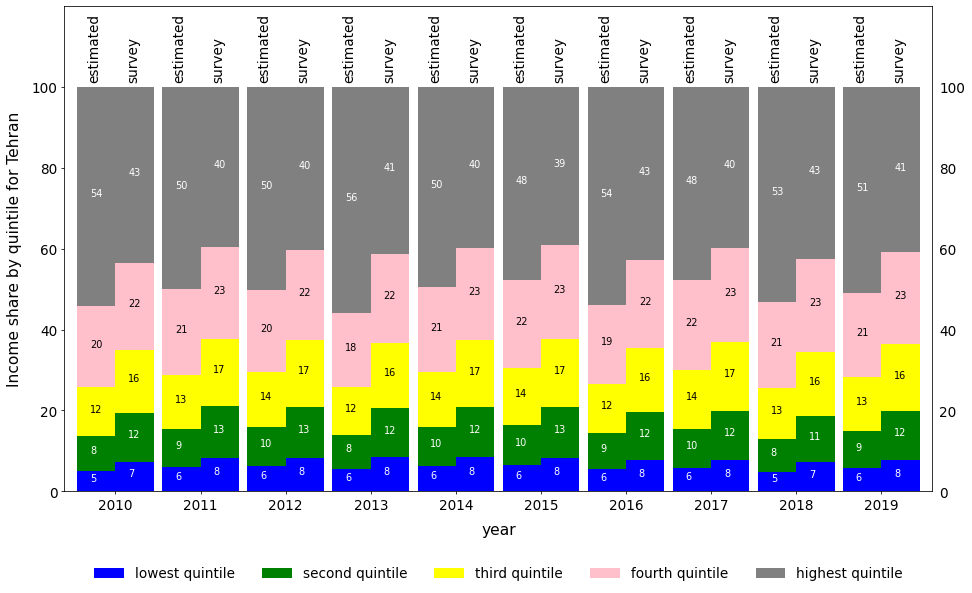

In [ ]:
# Tehran
ssh = share.round(decimals=0).astype(int).copy()

## plot gini estimated and gini from survey ##

fig=plt.figure(figsize=(16,9))
ax1=fig.add_subplot(1,1,1)

ax1.bar(share.year+0.225, share["1surv"], label="",color= "blue",width=0.45)
ax1.bar(share.year+0.225, share["2surv"], label="", bottom=share["1surv"],color="green",width=0.45)
ax1.bar(share.year+0.225, share["3surv"], label="", bottom=share["1surv"]+share["2surv"],color="yellow",width=0.45)
ax1.bar(share.year+0.225, share["4surv"], label="", bottom=share["1surv"]+share["2surv"]+share["3surv"],color="pink",width=0.45)
ax1.bar(share.year+0.225, share["5surv"], label="", bottom=share["1surv"]+share["2surv"]+share["3surv"]+share["4surv"],color="gray",width=0.45)
    
tt = "surv"
for year in np.arange(1389,1399): 
    ax1.text(year+0.15,share.loc[(share.year==year),f"1{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"1surv"].values[0],color="white")
    ax1.text(year+0.15,share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"2surv"].values[0],color="white")
    ax1.text(year+0.15, share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0] + share.loc[(share.year==year),f"3{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"3surv"].values[0],color="black")
    ax1.text(year+0.15, share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0] + share.loc[(share.year==year),f"3{tt}"].values[0] + share.loc[(share.year==year),f"4{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"4surv"].values[0],color="black")
    ax1.text(year+0.15, share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0] + share.loc[(share.year==year),f"3{tt}"].values[0] + share.loc[(share.year==year),f"4{tt}"].values[0] + share.loc[(share.year==year),f"5{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"5surv"].values[0],color="w")
    

ax1.bar(share.year-0.225, share["1est"], label="lowest quintile",color= "blue",width=0.45)
ax1.bar(share.year-0.225, share["2est"], label="second quintile", bottom=share["1est"],color="green",width=0.45)
ax1.bar(share.year-0.225, share["3est"], label="third quintile", bottom=share["1est"]+share["2est"],color="yellow",width=0.45)
ax1.bar(share.year-0.225, share["4est"], label="fourth quintile", bottom=share["1est"]+share["2est"]+share["3est"],color="pink",width=0.45)
ax1.bar(share.year-0.225, share["5est"], label="highest quintile", bottom=share["1est"]+share["2est"]+share["3est"]+share["4est"],color="gray",width=0.45)

tt = "est"
for year in np.arange(1389,1399): 
    ax1.text(year-0.3,share.loc[(share.year==year),f"1{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"1est"].values[0],color="white")
    ax1.text(year-0.3,share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"2est"].values[0],color="white")
    ax1.text(year-0.3, share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0] + share.loc[(share.year==year),f"3{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"3est"].values[0],color="black")
    ax1.text(year-0.3, share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0] + share.loc[(share.year==year),f"3{tt}"].values[0] + share.loc[(share.year==year),f"4{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"4est"].values[0],color="black")
    ax1.text(year-0.3, share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0] + share.loc[(share.year==year),f"3{tt}"].values[0] + share.loc[(share.year==year),f"4{tt}"].values[0] + share.loc[(share.year==year),f"5{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"5est"].values[0],color="w")
    
    
# ax1.grid(axis='y',alpha=0.4)
# # ax1.set_title(f'year {1300+year}')
ax1.set_xlabel('year', fontsize=16, labelpad=10)
ax1.set_ylabel('Income share by quintile for Tehran', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1389,1399,1))
ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
ax1.tick_params(labelsize=14)
ax1.legend(loc='upper center',edgecolor='w',prop={'size':14},ncol=5, handlelength=2.2, bbox_to_anchor=(0.5, -0.13))

ax1.set_xlim(1388.4,1398.6)
# plt.legend(patches, labels, loc="center left",edgecolor='gray',prop={'size':14}
#            , bbox_to_anchor=(1.1, 0.5 ))

# ax1.spines['bottom'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.spines['right'].set_visible(False)

ax1.set_ylim(-0.00,120)
ax1.set_yticks(np.arange(0.0,110,20))
for year in np.arange(1389,1399):
    ax1.text(year-0.33,102, "estimated" ,color="black", rotation=90,size=14)
    ax1.text(year+0.13,102, "survey" ,color="black", rotation=90,size=14)

plt.tick_params(labelright=True)

plt.show()
# fig.savefig(f'../Figures/Robustness/Income_shares_by_quintile2_new.pdf',transparent=True,bbox_inches="tight")

# fig.savefig(f'../Figures/Robustness/Income_shares_by_quintile2_robustness_other_provinces.pdf',transparent=True,bbox_inches="tight")

# fig.savefig(f'../Figures/Robustness/Income_shares_by_quintile2_robustness_data_cleaning.pdf',transparent=True,bbox_inches="tight")



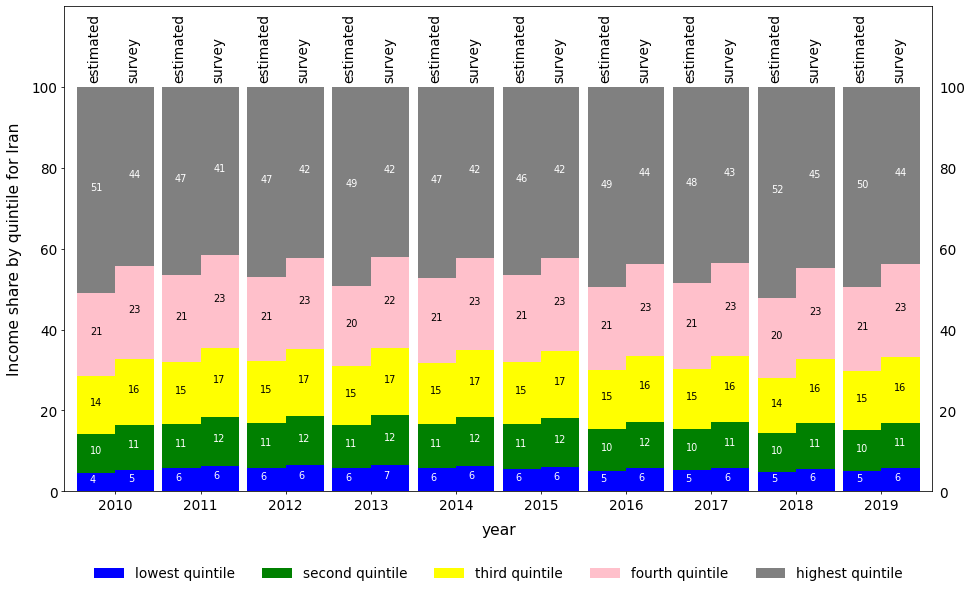

In [ ]:
# Iran
ssh = shareIran.round(decimals=0).astype(int).copy()

## plot gini estimated and gini from survey ##

fig=plt.figure(figsize=(16,9))
ax1=fig.add_subplot(1,1,1)

ax1.bar(shareIran.year+0.225, shareIran["1surv"], label="",color= "blue",width=0.45)
ax1.bar(shareIran.year+0.225, shareIran["2surv"], label="", bottom=shareIran["1surv"],color="green",width=0.45)
ax1.bar(shareIran.year+0.225, shareIran["3surv"], label="", bottom=shareIran["1surv"]+shareIran["2surv"],color="yellow",width=0.45)
ax1.bar(shareIran.year+0.225, shareIran["4surv"], label="", bottom=shareIran["1surv"]+shareIran["2surv"]+shareIran["3surv"],color="pink",width=0.45)
ax1.bar(shareIran.year+0.225, shareIran["5surv"], label="", bottom=shareIran["1surv"]+shareIran["2surv"]+shareIran["3surv"]+shareIran["4surv"],color="gray",width=0.45)
    
tt = "surv"
for year in np.arange(1389,1399): 
    ax1.text(year+0.15,shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"1surv"].values[0],color="white")
    ax1.text(year+0.15,shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"2surv"].values[0],color="white")
    ax1.text(year+0.15, shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"3{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"3surv"].values[0],color="black")
    ax1.text(year+0.15, shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"3{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"4{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"4surv"].values[0],color="black")
    ax1.text(year+0.15, shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"3{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"4{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"5{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"5surv"].values[0],color="w")
    

ax1.bar(shareIran.year-0.225, shareIran["1est"], label="lowest quintile",color= "blue",width=0.45)
ax1.bar(shareIran.year-0.225, shareIran["2est"], label="second quintile", bottom=shareIran["1est"],color="green",width=0.45)
ax1.bar(shareIran.year-0.225, shareIran["3est"], label="third quintile", bottom=shareIran["1est"]+shareIran["2est"],color="yellow",width=0.45)
ax1.bar(shareIran.year-0.225, shareIran["4est"], label="fourth quintile", bottom=shareIran["1est"]+shareIran["2est"]+shareIran["3est"],color="pink",width=0.45)
ax1.bar(shareIran.year-0.225, shareIran["5est"], label="highest quintile", bottom=shareIran["1est"]+shareIran["2est"]+shareIran["3est"]+shareIran["4est"],color="gray",width=0.45)

tt = "est"
for year in np.arange(1389,1399): 
    ax1.text(year-0.3,shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"1est"].values[0],color="white")
    ax1.text(year-0.3,shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"2est"].values[0],color="white")
    ax1.text(year-0.3, shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"3{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"3est"].values[0],color="black")
    ax1.text(year-0.3, shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"3{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"4{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"4est"].values[0],color="black")
    ax1.text(year-0.3, shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"3{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"4{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"5{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"5est"].values[0],color="w")
    

# ax1.grid(axis='y',alpha=0.4)
# # ax1.set_title(f'year {1300+year}')
ax1.set_xlabel('year', fontsize=16, labelpad=10)
ax1.set_ylabel('Income share by quintile for Iran', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1389,1399,1))
ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
ax1.tick_params(labelsize=14)
ax1.legend(loc='upper center',edgecolor='w',prop={'size':14},ncol=5, handlelength=2.2, bbox_to_anchor=(0.5, -0.13))

ax1.set_xlim(1388.4,1398.6)
# plt.legend(patches, labels, loc="center left",edgecolor='gray',prop={'size':14}
#            , bbox_to_anchor=(1.1, 0.5 ))

# ax1.spines['bottom'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.spines['right'].set_visible(False)

ax1.set_ylim(-0.00,120)
ax1.set_yticks(np.arange(0.0,110,20))
for year in np.arange(1389,1399):
    ax1.text(year-0.33,102, "estimated" ,color="black", rotation=90,size=14)
    ax1.text(year+0.13,102, "survey" ,color="black", rotation=90,size=14)

plt.tick_params(labelright=True)

plt.show()

# fig.savefig(f'../Figures/Robustness/Income_shares_by_quintile2_Iran_new.pdf',transparent=True,bbox_inches="tight")



In [63]:
share["sum_est_decile"] = (share["1DecileEst"]+share["2DecileEst"]+share["3DecileEst"]+share["4DecileEst"]+share["5DecileEst"]+
                   share["6DecileEst"]+share["7DecileEst"]+share["8DecileEst"]+share["9DecileEst"]+share["10DecileEst"])
share["sum_surv"] = (share["1DecileSurv"]+share["2DecileSurv"]+share["3DecileSurv"]+share["4DecileSurv"]+share["5DecileSurv"]+
                   share["6DecileSurv"]+share["7DecileSurv"]+share["8DecileSurv"]+share["9DecileSurv"]+share["10DecileSurv"])

# for i in [1,2,3,4,5]:
#     share[f"{i}est"] = share[f"{i}est"] / share["sum_est"]
#     share[f"{i}surv"] = share[f"{i}surv"] / share["sum_surv"]    


In [64]:
# ## plot 10P estimated and from survey ##

# fig=plt.figure(figsize=(9,6))
# ax1=fig.add_subplot(1,1,1)


# ax1.plot('year', '10DecileSurv', 's-',
#         data= share,
#         color=(0.1,0.1,0.9,0.9),
#         label='Using Only Household Data',
#         marker = markerShape[0],
#         linewidth=1.5,
#         markersize= 8,
#         alpha=0.8)


# ax1.plot("year", f"10DecileEst", 'o-',
#         data= share,
#         color= (0,0.8,0.5,0.8),
#         marker = markerShape[1],
#         label= f"Correcting for Top Incomes",
#         linewidth=1.5,
#         markersize= 8,
#         alpha=0.8)

# ax1.grid(axis='y',alpha=0.4)
# ax1.set_xlabel('Year', fontsize=16, labelpad=10)
# ax1.set_ylabel('Top 10% income share', fontsize=16, labelpad=10)
# ax1.set_xticks(np.arange(1389,1399,1))
# ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
# ax1.tick_params(labelsize=13)
# ax1.set_ylim(0.2,0.4)
# ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2)

# plt.show()
# #fig.savefig(f'../Figures/Robustness/Income_shares_by_deciles10.pdf',transparent=True,bbox_inches="tight")


In [65]:
shareTen
# shareFive=shareFive[['year','20HalfDecileEst','20HalfDecileSurv', ]]
shareFive
# shareOne=shareOne[['year','100HalfDecileEst','100HalfDecileSurv']]
shareOne

,year,1HalfDecileEst,1HalfDecileEst_thresh_90,2HalfDecileEst,2HalfDecileEst_thresh_90,3HalfDecileEst,3HalfDecileEst_thresh_90,4HalfDecileEst,4HalfDecileEst_thresh_90,5HalfDecileEst,...,91HalfDecileSurv,92HalfDecileSurv,93HalfDecileSurv,94HalfDecileSurv,95HalfDecileSurv,96HalfDecileSurv,97HalfDecileSurv,98HalfDecileSurv,99HalfDecileSurv,100HalfDecileSurv
0,1389,0.065,0.065,0.114,0.114,0.162,0.162,0.182,0.182,0.203,...,1.722,1.978,2.022,2.185,2.455,2.562,2.820,2.996,3.648,5.615
1,1390,0.097,0.097,0.149,0.149,0.191,0.191,0.211,0.211,0.249,...,1.733,1.753,1.986,1.782,2.054,2.373,2.335,2.768,3.056,4.346
2,1391,0.110,0.110,0.196,0.196,0.222,0.222,0.240,0.240,0.272,...,1.842,1.804,2.076,2.041,2.156,2.482,2.452,2.578,3.306,4.297
3,1392,0.130,0.130,0.177,0.177,0.203,0.203,0.219,0.219,0.238,...,1.816,1.923,1.935,2.067,2.227,2.178,2.616,2.677,3.074,5.400
4,1393,0.134,0.134,0.200,0.200,0.223,0.223,0.255,0.255,0.272,...,1.840,1.907,1.925,1.970,2.050,2.035,2.370,2.583,2.764,4.719
5,1394,0.117,0.117,0.173,0.173,0.227,0.227,0.253,0.253,0.272,...,1.908,1.761,1.969,1.842,2.154,2.125,2.223,2.543,2.603,4.014
6,1395,0.095,0.095,0.156,0.156,0.194,0.194,0.208,0.208,0.229,...,1.948,2.115,2.079,2.418,2.249,2.381,2.637,3.159,3.275,5.380
7,1396,0.112,0.112,0.172,0.172,0.203,0.203,0.224,0.224,0.241,...,1.780,1.912,1.913,2.147,2.055,2.334,2.294,2.768,2.977,3.916
8,1397,0.088,0.088,0.150,0.150,0.166,0.166,0.183,0.183,0.193,...,1.951,2.075,1.970,2.227,2.378,2.376,2.615,2.920,2.843,4.965
9,1398,0.117,0.117,0.171,0.171,0.200,0.200,0.219,0.219,0.222,...,1.799,1.848,1.833,2.074,2.221,2.126,2.522,2.631,2.856,5.466


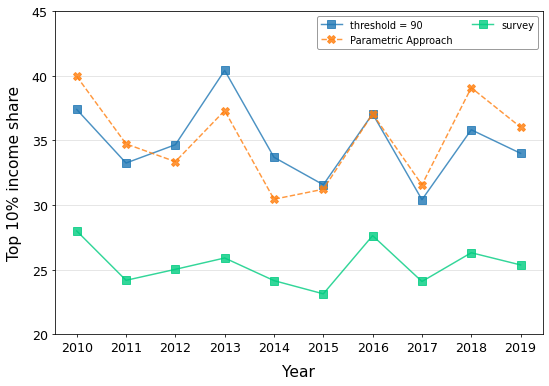

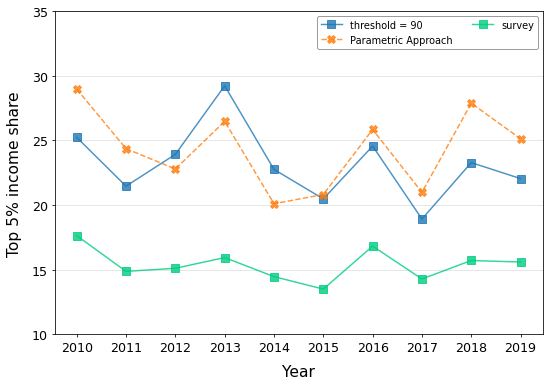

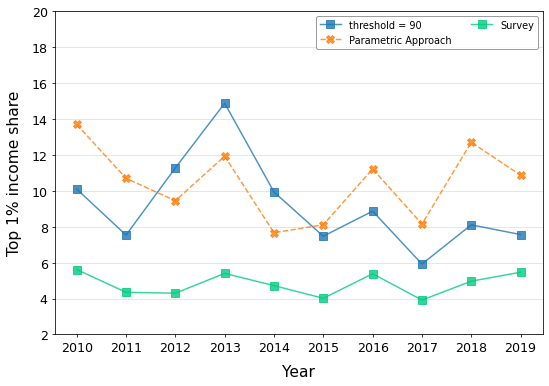

In [45]:
# Tehran

# different_threshold_of_top_HIES = [85,90,95]

# plot 10P estimated and from survey ##
fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)

for nmr,tauThreshold in enumerate(different_threshold_of_top_HIES):
    ax1.plot("year", f"10HalfDecileEst_thresh_{tauThreshold}", 'o-',
        data= shareTen,
        label=f"threshold = {tauThreshold}",
        marker = markerShape[nmr+1],
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.plot("year", f"10HalfDecileEst_thresh_{90}",
        data= shareTenParametric,
        label=f"Parametric Approach",
        marker = "X" ,
        linestyle='dashed',
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)
    
ax1.plot("year", f"10HalfDecileSurv", 'o-',
        data= shareTen,
        color=(0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"survey",
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Top 10% income share', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1389,1399,1))
ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
ax1.tick_params(labelsize=13)
ax1.set_ylim(20,45)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2, ncol=2)

plt.show()
fig.savefig(f'../Figures/Robustness/Income_shares_by_10percent_Tehran_new.pdf',transparent=True,bbox_inches="tight")


# plot 5P estimated and from survey ##
fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)

for nmr,tauThreshold in enumerate(different_threshold_of_top_HIES):
    ax1.plot("year", f"20HalfDecileEst_thresh_{tauThreshold}", 'o-',
        data= shareFive,
        label=f"threshold = {tauThreshold}",
        marker = markerShape[nmr+1],
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.plot("year", f"20HalfDecileEst_thresh_{90}",
        data= shareFiveParametric,
        label=f"Parametric Approach",
        marker = "X" ,
        linestyle='dashed',
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.plot("year", f"20HalfDecileSurv", 'o-',
        data= shareFive,
#        color=(0.1,0.1,0.9,0.9),
        color=(0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"survey",
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Top 5% income share', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1389,1399,1))
ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
ax1.tick_params(labelsize=13)
ax1.set_ylim(10,35)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2, ncol=2)

plt.show()
fig.savefig(f'../Figures/Robustness/Income_shares_by_5percent_Tehran_new.pdf',transparent=True,bbox_inches="tight")



# plot 1P estimated and from survey ##
fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)

for nmr,tauThreshold in enumerate(different_threshold_of_top_HIES):
    ax1.plot("year", f"100HalfDecileEst_thresh_{tauThreshold}", 'o-',
        data= shareOne,
        label=f"threshold = {tauThreshold}",
        marker = markerShape[nmr+1],
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)


ax1.plot("year", f"100HalfDecileEst_thresh_{90}",
        data= shareOneParametric,
        label=f"Parametric Approach",
        marker = "X" ,
        linestyle='dashed',
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.plot("year", f"100HalfDecileSurv", 'o-',
        data= shareOne,
#        color=(0.1,0.1,0.9,0.9),
        color=(0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"Survey",
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Top 1% income share', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1389,1399,1))
ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
ax1.tick_params(labelsize=13)
ax1.set_ylim(2,20)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2, ncol=2)

plt.show()
fig.savefig(f'../Figures/Robustness/Income_shares_by_1percent_Tehran_new.pdf',transparent=True,bbox_inches="tight")





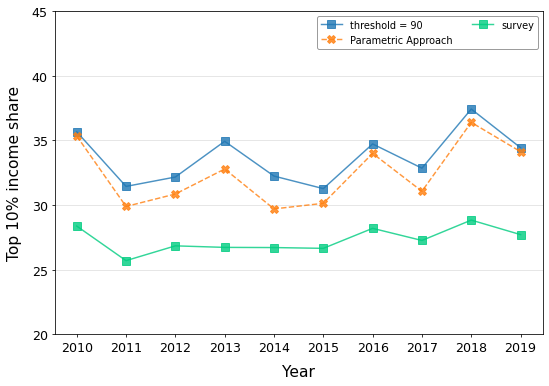

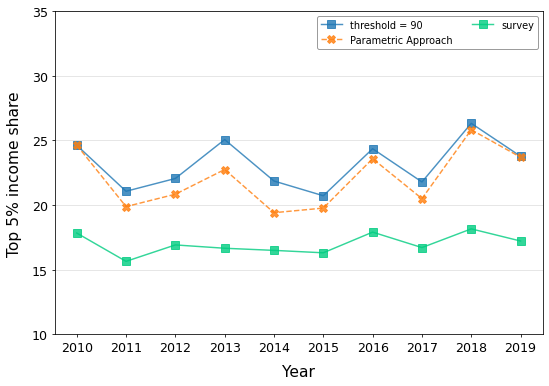

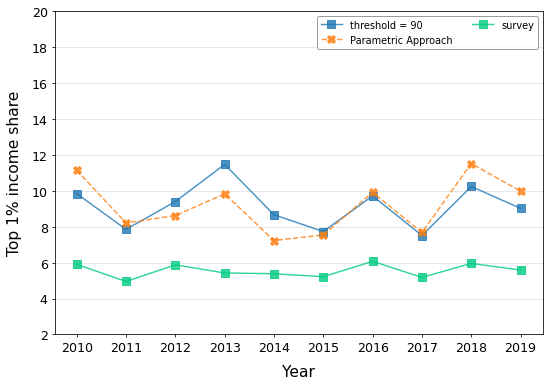

In [46]:
# Iran
# plot 10P estimated and from survey ##
fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)

for nmr,tauThreshold in enumerate(different_threshold_of_top_HIES):
    ax1.plot("year", f"10HalfDecileEst_thresh_{tauThreshold}", 'o-',
        data= shareTenIran,
        label=f"threshold = {tauThreshold}",
        # marker = markerShape[0],
        marker = markerShape[nmr+1],
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.plot("year", f"10HalfDecileEst_thresh_{90}",
        data= shareTenIranParametric,
        label=f"Parametric Approach",
        marker = "X" ,
        linestyle='dashed',
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.plot("year", f"10HalfDecileSurv", 'o-',
        data= shareTenIran,
        # color=(0.1,0.1,0.9,0.9),
        color=(0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"survey",
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Top 10% income share', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1389,1399,1))
ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
ax1.tick_params(labelsize=13)
ax1.set_ylim(20,45)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2, ncol=2)

plt.show()
fig.savefig(f'../Figures/Robustness/Income_shares_by_10percent_Iran_new.pdf',transparent=True,bbox_inches="tight")



# plot 5P estimated and from survey ##

fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)

for nmr,tauThreshold in enumerate(different_threshold_of_top_HIES):
    ax1.plot("year", f"20HalfDecileEst_thresh_{tauThreshold}", 'o-',
        data= shareFiveIran,
        label=f"threshold = {tauThreshold}",
        # marker = markerShape[0],
        marker = markerShape[nmr+1],
        # linestyle=ll[nmr] ,
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.plot("year", f"20HalfDecileEst_thresh_{90}",
        data= shareFiveIranParametric,
        label=f"Parametric Approach",
        marker = "X" ,
        linestyle='dashed',
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.plot("year", f"20HalfDecileSurv", 'o-',
        data= shareFiveIran,
        # color=(0.1,0.1,0.9,0.9),
        color=(0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"survey",
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Top 5% income share', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1389,1399,1))
ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
ax1.tick_params(labelsize=13)
ax1.set_ylim(10,35)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2, ncol=2)

plt.show()
fig.savefig(f'../Figures/Robustness/Income_shares_by_5percent_Iran_new.pdf',transparent=True,bbox_inches="tight")


# plot 1P estimated and from survey ##
fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)

for nmr,tauThreshold in enumerate(different_threshold_of_top_HIES):
    ax1.plot("year", f"100HalfDecileEst_thresh_{tauThreshold}", 'o-',
        data= shareOneIran,
        label=f"threshold = {tauThreshold}",
        # marker = markerShape[0],
        marker = markerShape[nmr+1],
        # linestyle=ll[nmr] ,
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.plot("year", f"100HalfDecileEst_thresh_{90}",
        data= shareOneIranParametric,
        label=f"Parametric Approach",
        marker = "X" ,
        linestyle='dashed',
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.plot("year", f"100HalfDecileSurv", 'o-',
        data= shareOneIran,
        # color=(0.1,0.1,0.9,0.9),
        color=(0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"survey",
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Top 1% income share', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1389,1399,1))
ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
ax1.tick_params(labelsize=13)
ax1.set_ylim(2,20)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2, ncol=2)

plt.show()
fig.savefig(f'../Figures/Robustness/Income_shares_by_1percent_Iran_new.pdf',transparent=True,bbox_inches="tight")

In [47]:
decileEst = share[["year","1DecileEst","2DecileEst","3DecileEst","4DecileEst","5DecileEst",
                   "6DecileEst","7DecileEst","8DecileEst","9DecileEst","10DecileEst"]]

decileEst["year"] = year_list

decileEst["Top5"] = shareFive["20HalfDecileEst"]	
decileEst["Top1"] = shareOne["100HalfDecileEst"]	
summary_statistics = decileEst.round(decimals=3)
summary_statistics["year"] = year_list           
# summary_statistics.to_clipboard(index=False,header=None)

print(summary_statistics.to_latex(header=True,index=False, float_format="{:0.2f}".format))

decileEst["year"] = year_list
decileEst

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
year & 1DecileEst & 2DecileEst & 3DecileEst & 4DecileEst & 5DecileEst & 6DecileEst & 7DecileEst & 8DecileEst & 9DecileEst & 10DecileEst & Top5 & Top1 \\
\midrule
2010 & 1.93 & 3.19 & 3.92 & 4.57 & 5.43 & 6.67 & 8.51 & 11.58 & 16.81 & 37.39 & 25.23 & 10.09 \\
2011 & 2.35 & 3.63 & 4.40 & 5.10 & 5.99 & 7.35 & 9.13 & 12.04 & 16.75 & 33.25 & 21.46 & 7.53 \\
2012 & 2.55 & 3.68 & 4.48 & 5.23 & 6.19 & 7.35 & 8.99 & 11.32 & 15.54 & 34.67 & 23.93 & 11.27 \\
2013 & 2.31 & 3.29 & 3.90 & 4.52 & 5.36 & 6.41 & 7.97 & 10.46 & 15.38 & 40.41 & 29.22 & 14.87 \\
2014 & 2.62 & 3.68 & 4.40 & 5.16 & 6.19 & 7.42 & 9.18 & 11.75 & 15.90 & 33.70 & 22.76 & 9.93 \\
2015 & 2.62 & 3.85 & 4.60 & 5.38 & 6.42 & 7.59 & 9.53 & 12.24 & 16.20 & 31.57 & 20.48 & 7.47 \\
2016 & 2.22 & 3.28 & 4.00 & 4.80 & 5.57 & 6.72 & 8.26 & 11.16 & 16.93 & 37.06 & 24.56 & 8.87 \\
2017 & 2.31 & 3.46 & 4.39 & 5.33 & 6.52 & 7.88 & 9.85 & 12.62 & 17.22 & 30.42 & 18.92 & 5.92 \\
2018 & 1.93 & 2.87 & 3.63 &

,year,1DecileEst,2DecileEst,3DecileEst,4DecileEst,5DecileEst,6DecileEst,7DecileEst,8DecileEst,9DecileEst,10DecileEst,Top5,Top1
0,2010,1.930,3.185,3.918,4.572,5.428,6.672,8.513,11.577,16.813,37.393,25.235,10.092
1,2011,2.349,3.631,4.397,5.098,5.991,7.354,9.134,12.038,16.754,33.253,21.463,7.532
2,2012,2.553,3.681,4.484,5.229,6.190,7.352,8.988,11.319,15.535,34.669,23.925,11.273
3,2013,2.311,3.285,3.897,4.522,5.360,6.407,7.966,10.455,15.383,40.415,29.222,14.870
4,2014,2.617,3.684,4.402,5.159,6.191,7.418,9.183,11.751,15.897,33.699,22.760,9.931
5,2015,2.617,3.850,4.596,5.382,6.425,7.588,9.531,12.238,16.201,31.573,20.480,7.467
6,2016,2.222,3.282,4.004,4.800,5.566,6.719,8.259,11.156,16.933,37.059,24.564,8.865
7,2017,2.313,3.460,4.390,5.328,6.524,7.875,9.851,12.619,17.221,30.419,18.923,5.920
8,2018,1.925,2.872,3.635,4.509,5.553,7.007,9.160,12.257,17.260,35.825,23.286,8.102
9,2019,2.264,3.398,4.193,5.025,6.030,7.234,9.113,11.865,16.875,34.003,22.048,7.561


In [48]:
decileSurv = share[["year","1DecileSurv","2DecileSurv","3DecileSurv","4DecileSurv","5DecileSurv",
                   "6DecileSurv","7DecileSurv","8DecileSurv","9DecileSurv","10DecileSurv"]]

decileSurv["year"] = year_list

decileSurv["Top5"] = shareFive["20HalfDecileSurv"]	
decileSurv["Top1"] = shareOne["100HalfDecileSurv"]	

summary_statistics = decileSurv.round(decimals=3)
# summary_statistics.to_clipboard(index=False,header=None)

print(summary_statistics.to_latex(header=True,index=False, float_format="{:0.2f}".format, column_format='ccccccccc'))
decileSurv["year"] = year_list
decileSurv

\begin{tabular}{ccccccccc}
\toprule
year & 1DecileSurv & 2DecileSurv & 3DecileSurv & 4DecileSurv & 5DecileSurv & 6DecileSurv & 7DecileSurv & 8DecileSurv & 9DecileSurv & 10DecileSurv & Top5 & Top1 \\
\midrule
2010 & 2.76 & 4.56 & 5.58 & 6.43 & 7.27 & 8.34 & 9.81 & 11.80 & 15.44 & 28.00 & 17.64 & 5.62 \\
2011 & 3.21 & 5.05 & 5.97 & 6.87 & 7.67 & 8.87 & 10.39 & 12.37 & 15.40 & 24.19 & 14.88 & 4.35 \\
2012 & 3.39 & 4.91 & 5.86 & 6.69 & 7.76 & 8.83 & 10.19 & 12.08 & 15.26 & 25.03 & 15.12 & 4.30 \\
2013 & 3.46 & 4.89 & 5.71 & 6.54 & 7.40 & 8.59 & 10.11 & 12.08 & 15.29 & 25.91 & 15.95 & 5.40 \\
2014 & 3.51 & 4.93 & 5.79 & 6.60 & 7.67 & 8.84 & 10.43 & 12.49 & 15.57 & 24.16 & 14.47 & 4.72 \\
2015 & 3.35 & 4.97 & 5.88 & 6.73 & 7.76 & 8.93 & 10.48 & 12.71 & 16.04 & 23.14 & 13.51 & 4.01 \\
2016 & 3.08 & 4.62 & 5.50 & 6.43 & 7.43 & 8.47 & 9.86 & 11.75 & 15.23 & 27.64 & 16.83 & 5.38 \\
2017 & 3.12 & 4.52 & 5.63 & 6.66 & 7.75 & 9.12 & 10.68 & 12.70 & 15.72 & 24.09 & 14.29 & 3.92 \\
2018 & 2.89 & 4.29

,year,1DecileSurv,2DecileSurv,3DecileSurv,4DecileSurv,5DecileSurv,6DecileSurv,7DecileSurv,8DecileSurv,9DecileSurv,10DecileSurv,Top5,Top1
0,2010,2.759,4.562,5.580,6.434,7.270,8.341,9.810,11.798,15.443,28.003,17.641,5.615
1,2011,3.205,5.053,5.970,6.871,7.674,8.874,10.394,12.368,15.404,24.186,14.879,4.346
2,2012,3.386,4.905,5.861,6.688,7.765,8.831,10.188,12.084,15.258,25.034,15.115,4.297
3,2013,3.464,4.893,5.713,6.540,7.403,8.592,10.109,12.083,15.289,25.913,15.945,5.400
4,2014,3.514,4.928,5.786,6.604,7.674,8.841,10.434,12.486,15.569,24.163,14.471,4.719
5,2015,3.355,4.974,5.885,6.726,7.757,8.931,10.485,12.709,16.038,23.141,13.508,4.014
6,2016,3.077,4.617,5.501,6.427,7.428,8.466,9.859,11.752,15.234,27.641,16.832,5.380
7,2017,3.124,4.524,5.627,6.656,7.747,9.124,10.679,12.704,15.719,24.095,14.289,3.916
8,2018,2.893,4.287,5.210,6.213,7.286,8.653,10.302,12.579,16.257,26.319,15.719,4.965
9,2019,3.145,4.535,5.628,6.539,7.638,8.827,10.300,12.457,15.555,25.375,15.601,5.466


In [49]:
# summary_statistics_total = decileEst.round(decimals=3)*100
# print(summary_statistics_total.to_latex(header=True,index=False, float_format="{:0.2f}".format, column_format='ccccccccc'))
# summary_statistics_total["year"] = year_list
# decileEst*100

In [50]:
Iran

,year,GiniSurvey,Gini
0,1389,38.752,45.513
1,1390,34.939,40.320
2,1391,35.381,40.394
3,1392,35.113,42.585
4,1393,35.653,40.797
5,1394,35.819,40.128
6,1395,37.682,43.546
7,1396,37.383,42.547
8,1397,38.697,46.362
9,1398,37.764,43.732


In [51]:
result

,year,lambdaHouseSurv01,lambdaHouse01,GiniSurvey01,Gini01_90,Gini
0,1389,11.355,28.867,35.321,47.932,0.479
1,1390,10.591,27.308,31.107,43.211,0.432
2,1391,12.269,26.395,31.521,43.212,0.432
3,1392,11.941,25.690,32.533,48.979,0.490
4,1393,10.104,24.483,31.224,42.773,0.428
5,1394,13.717,26.158,30.712,40.887,0.409
6,1395,11.353,25.320,34.471,46.876,0.469
7,1396,10.035,28.353,32.116,41.373,0.414
8,1397,13.351,32.508,35.075,47.559,0.476
9,1398,10.910,25.794,33.059,44.238,0.442


In [52]:
# Tehra_output = result[["year","lambdaSurvey01","lambda01","sSurvey01","s01","GiniSurvey01",f"Gini01_{different_threshold_of_top_HIES[0]}"]]
# Tehra_output.columns = Iran.columns
# # print(Tehra_output.to_latex(header=True,index=False))
# Tehra_output

In [53]:
# Tehra_output["gap"] = Tehra_output.Gini-Tehra_output.GiniSurvey
# Tehra_output.gap.mean()

In [54]:
# Tehra_output

In [55]:
#Iran
# print(Iran.to_latex(header=True,index=False))

In [56]:
Iran["gap"] = Iran.Gini-Iran.GiniSurvey
print(Iran.gap.mean())
Iran.drop(columns=["gap"],inplace=True)

5.873923397792851


In [57]:
""" 
    year landa_survey landa s_survey s
"""
result["dist"] = ""
result_word_report = pd.merge(
    result[["year","lambdaSurvey01","lambda01","sSurvey01","s01", "dist"]]
    ,Iran[["year","lambdaSurvey","lambda","sSurvey","s"]]
    ,on=["year"]
)

result_word_report["year"] = year_list
summary_statistics = result_word_report.round(decimals=2)
summary_statistics.to_clipboard(index=False,header=None)

print(summary_statistics.to_latex(header=True,index=False, float_format="{:0.2f}".format, column_format='ccccccccc'))

result_word_report

KeyError: "['lambdaSurvey01', 'lambda01', 'sSurvey01', 's01'] not in index"

In [58]:
Gini_House_Price = result[["year","GiniSurvey01",f"Gini01_{different_threshold_of_top_HIES[0]}"]]
Gini_House_Price.columns = ["year","Gini_{Survey}","Gini"]
Gini_House_Price["Gap"] = Gini_House_Price["Gini"] - Gini_House_Price["Gini_{Survey}"] 
Gini_House_Price["dist"] = ""

Gini_House_Price = pd.merge(Gini_House_Price,Iran[["year","GiniSurvey","Gini"]],on=["year"])
Gini_House_Price["GapIran"] = Gini_House_Price["Gini_y"] - Gini_House_Price["GiniSurvey"] 

Gini_House_Price = Gini_House_Price.round(decimals=2)
Gini_House_Price["year"] = year_list
print(Gini_House_Price.to_latex(header=True,index=False, float_format="{:0.2f}".format, column_format='cccccc'))

Gini_House_Price.to_clipboard(index=False,header=None)

Gini_House_Price

\begin{tabular}{cccccc}
\toprule
year & Gini_{Survey} & Gini_x & Gap & dist & GiniSurvey & Gini_y & GapIran \\
\midrule
2010 & 35.32 & 47.93 & 12.61 &  & 38.75 & 45.51 & 6.76 \\
2011 & 31.11 & 43.21 & 12.10 &  & 34.94 & 40.32 & 5.38 \\
2012 & 31.52 & 43.21 & 11.69 &  & 35.38 & 40.39 & 5.01 \\
2013 & 32.53 & 48.98 & 16.45 &  & 35.11 & 42.58 & 7.47 \\
2014 & 31.22 & 42.77 & 11.55 &  & 35.65 & 40.80 & 5.14 \\
2015 & 30.71 & 40.89 & 10.18 &  & 35.82 & 40.13 & 4.31 \\
2016 & 34.47 & 46.88 & 12.40 &  & 37.68 & 43.55 & 5.86 \\
2017 & 32.12 & 41.37 & 9.26 &  & 37.38 & 42.55 & 5.16 \\
2018 & 35.08 & 47.56 & 12.48 &  & 38.70 & 46.36 & 7.66 \\
2019 & 33.06 & 44.24 & 11.18 &  & 37.76 & 43.73 & 5.97 \\
\bottomrule
\end{tabular}



,year,Gini_{Survey},Gini_x,Gap,dist,GiniSurvey,Gini_y,GapIran
0,2010,35.320,47.930,12.610,,38.750,45.510,6.760
1,2011,31.110,43.210,12.100,,34.940,40.320,5.380
2,2012,31.520,43.210,11.690,,35.380,40.390,5.010
3,2013,32.530,48.980,16.450,,35.110,42.580,7.470
4,2014,31.220,42.770,11.550,,35.650,40.800,5.140
5,2015,30.710,40.890,10.180,,35.820,40.130,4.310
6,2016,34.470,46.880,12.400,,37.680,43.550,5.860
7,2017,32.120,41.370,9.260,,37.380,42.550,5.160
8,2018,35.080,47.560,12.480,,38.700,46.360,7.660
9,2019,33.060,44.240,11.180,,37.760,43.730,5.970


In [59]:
Gini_House_Price.sum()

year             2010201120122013201420152016201720182019
Gini_{Survey}                                     327.140
Gini_x                                            447.040
Gap                                               119.900
dist                                                     
GiniSurvey                                        367.170
Gini_y                                            425.920
GapIran                                            58.720
dtype: object

In [60]:
# table = table.round(decimals=2)
# table.columns = ["year","$\alpha$","$\beta$", "$\lambda$", "$\theta$_{surv}", "$\theta$_{est}"]
table["year"] = year_list
table["dist"] = ""
table = table[['year', 'delta', 'beta', 'lambda_est', 'dist', 'alpha', 'alpha_surv', 'theta_surv', 'theta_est']]
print(table.to_latex(header=True,index=False, float_format="{:0.2f}".format, column_format='cccccc'))


\begin{tabular}{cccccc}
\toprule
year & delta & beta & lambda_est & dist & alpha & alpha_surv & theta_surv & theta_est \\
\midrule
2010 & 7.58 & 0.79 & 0.25 &  & 1.47 & 2.38 & 2.52 & 1.70 \\
2011 & 8.35 & 0.73 & 0.26 &  & 1.49 & 3.43 & 3.39 & 1.89 \\
2012 & 8.03 & 0.74 & 0.21 &  & 1.63 & 2.11 & 3.29 & 2.10 \\
2013 & 6.26 & 0.83 & 0.22 &  & 1.54 & 2.86 & 3.36 & 1.72 \\
2014 & 8.44 & 0.70 & 0.22 &  & 1.75 & 5.15 & 3.97 & 2.10 \\
2015 & 8.17 & 0.71 & 0.21 &  & 1.67 & 3.23 & 4.62 & 2.22 \\
2016 & 6.24 & 0.82 & 0.22 &  & 1.58 & 3.07 & 3.05 & 1.72 \\
2017 & 9.35 & 0.64 & 0.25 &  & 1.47 & 3.11 & 4.03 & 2.18 \\
2018 & 6.89 & 0.77 & 0.26 &  & 1.36 & 2.79 & 3.60 & 1.79 \\
2019 & 6.15 & 0.79 & 0.23 &  & 1.57 & 3.25 & 3.55 & 1.91 \\
\bottomrule
\end{tabular}



the output for microsoft final word report

In [61]:
tau_x0

,year
0,1389
1,1390
2,1391
3,1392
4,1393
5,1394
6,1395
7,1396
8,1397
9,1398


In [62]:
""" 
    year alpha beta theta_hat theta
"""
summary_statistics = alpha_beta_Tehran.round(decimals=2)
summary_statistics.to_clipboard(index=False,header=None)
alpha_beta_Tehran

,year
0,1389
1,1390
2,1391
3,1392
4,1393
5,1394
6,1395
7,1396
8,1397
9,1398


In [63]:
summary_statistics = summary_statistics.round(decimals=2)
summary_statistics["year"] = year_list
print(summary_statistics.to_latex(header=True,index=False, float_format="{:0.2f}".format, column_format='cccccc'))

summary_statistics.to_clipboard(index=False,header=None)

\begin{tabular}{cccccc}
\toprule
year \\
\midrule
2010 \\
2011 \\
2012 \\
2013 \\
2014 \\
2015 \\
2016 \\
2017 \\
2018 \\
2019 \\
\bottomrule
\end{tabular}



In [64]:
""" 
    year landa_survey landa s_survey s
"""
result_word_report = pd.merge(
    result[["year","lambdaSurvey01","lambda01","sSurvey01","s01"]]
    ,Iran[["year","lambdaSurvey","lambda","sSurvey","s"]]
    ,on=["year"]
)

summary_statistics = result_word_report.round(decimals=2)
summary_statistics.to_clipboard(index=False,header=None)

print(summary_statistics.to_latex(header=True,index=False, float_format="{:0.2f}".format, column_format='cccccc'))

result_word_report

KeyError: "['lambdaSurvey01', 'lambda01', 'sSurvey01', 's01'] not in index"

Gini coefficient of whole country

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

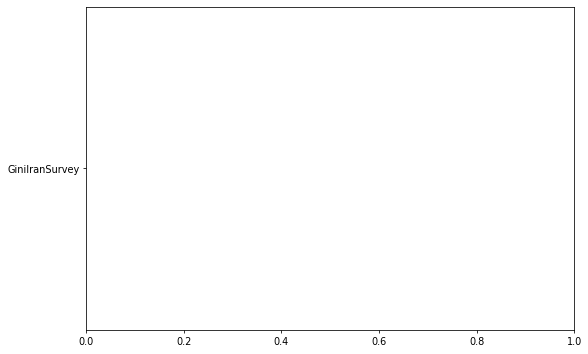

In [65]:
## plot gini estimated and gini from survey ##

fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)


ax1.plot('year', 'GiniIranSurvey', 's-',
        data= result,
        color=(0.1,0.1,0.9,0.9),
        label='Gini_Survey',
        marker = markerShape[0],
        linewidth=1,
        alpha=0.8)


ax1.plot("year", f"GiniIran_{tauThreshold}", 'o-',
        data= result,
        color= (0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"Gini_Estimated",
        linewidth=1,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
# ax1.set_title(f'year {1300+year}')
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Gini Index',
               fontsize=16, labelpad=10)
ax1.legend(loc='best')
# ax1.set_ylim(0.314,0.445)
# ax1.set_yticks(np.arange(0.32,0.45,0.02))
ax1.set_xticks(np.arange(1389,1399,1))
ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
ax1.tick_params(labelsize=13)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plt.show()
#fig.savefig(f'/Users/ZShamloo/Dropbox/Iran Inequality Measure, Zahra Shamlou/Reports/LaTex/Topincomes/Figures/General/Gini_Iran_{figuresFolder}_{year}.pdf',transparent=True,bbox_inches="tight")
# fig.savefig(f'Figures/{figuresFolder}/Gini_Iran_{figuresFolder}_{year}.pdf',transparent=True,bbox_inches="tight")


In [66]:
ll = ["dashed","dotted","dashdot"]

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

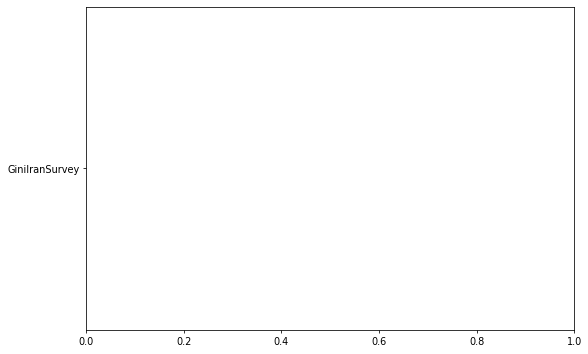

In [67]:
## plot gini estimated and gini from survey ##

fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)


ax1.plot('year', 'GiniIranSurvey', 's-',
        data= result,
        color=(0.1,0.1,0.9,0.9),
        label='Gini_Survey',
        marker = markerShape[0],
        linewidth=1,
        alpha=0.8)

for nmr,tauThreshold in enumerate(different_threshold_of_top_HIES):
    ax1.plot("year", f"GiniIran_{tauThreshold}", 'o-',
            data= result,
            # color= (0,0.8,0.5,0.8),
            marker = markerShape[nmr+1],
            label= f"Gini estimated threshold = {tauThreshold}",
            linewidth=2,
            linestyle=ll[nmr] ,
            alpha=0.8)

# ax1.fill_between('year', 'Gini_lower', 'Gini_upper'
#                  ,data= result
#                  ,color=(0,0.8,0.5,0.15)
#                  ,linewidth= 1)

ax1.grid(axis='y',alpha=0.4)
# ax1.set_title(f'year {1300+year}')
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Gini Index',
               fontsize=16, labelpad=10)
ax1.legend(loc='best')
# ax1.set_ylim(0.314,0.445)
# ax1.set_yticks(np.arange(0.32,0.45,0.02))
ax1.set_xticks(np.arange(1389,1399,1))
ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
ax1.tick_params(labelsize=13)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=4.2)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylim(34,42)
plt.show()
#fig.savefig(f'/Users/ZShamloo/Dropbox/Iran Inequality Measure, Zahra Shamlou/Reports/LaTex/Topincomes V3/Figures/General/sensitivity_tau_Gini_Iran_Daramad_98.pdf',transparent=True,bbox_inches="tight")

#fig.savefig(f'../Figures/Robustness/sensitivity_tau_Gini_Iran_{figuresFolder}_{year-1300}.pdf',transparent=True,bbox_inches="tight")


Gini coefficient of Tehran Province

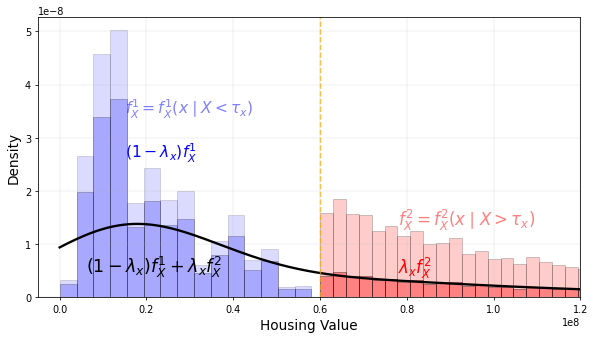

In [109]:
# import pandas as pd
# from scipy.stats import gaussian_kde
# import numpy as np
# import matplotlib.pyplot as plt
# mpl.rcParams['text.usetex'] = True
# year=98

for year in range(98,99):
    IranSample = pd.read_csv(f'../Data/Simulated Sample/TehranSample{year}.csv')

    # Assuming df is your DataFrame and it has columns 'income' and 'wei'
    # Define the cutoff point
    cutoff = IranSample.loc[(IranSample.top==1),"rent"].min()

    # IranSample = IranSample.loc[(IranSample.rent>cutoff*0.7)&(IranSample.rent<cutoff*1.3),:]

    # Extract the relevant columns
    income_left = IranSample.loc[(IranSample.top!=1),'rent']
    weights_left = IranSample.loc[(IranSample.top!=1),'weight'] 
    income_right = IranSample.loc[(IranSample.top==1),'rent']
    weights_right = IranSample.loc[(IranSample.top==1),'weight'] 

    # Perform kernel density estimation on both sides of the cutoff
    income = IranSample['rent']
    weights = IranSample['weight']

    # graph
    # Perform kernel density estimation on both sides of the cutoff
    # kde_left = gaussian_kde(income_left, weights=weights_left)
    # kde_right = gaussian_kde(income_right, weights=weights_right)

    # Define the range for plotting
    income_min = income.min()
    income_max = income.max()
    income_range_right = np.linspace(cutoff*0.7, cutoff*2, 1000)
    income_range_left = np.linspace(-1e8, cutoff*2, 1000)

    # # Evaluate the density over the range
    # density_left = kde_left.evaluate(income_range_left)
    # density_right = kde_right.evaluate(income_range_right)

    # Normalize the densities by the total weight on each side
    total_weight = weights.sum()
    total_weight_left = weights_left.sum() /total_weight
    total_weight_right = weights_right.sum()/total_weight
    # density_left_normalized = density_left * total_weight_left
    # density_right_normalized = density_right * total_weight_right

    # Plot the kernel density estimates
    plt.figure(figsize=(10, 5.2))
    # plt.plot(income_range_left, density_left_normalized, label='Left of cutoff', color='darkblue',linewidth=1.5)
    # plt.plot(income_range_right, density_right_normalized, label='Right of cutoff', color='darkblue', linestyle='--',linewidth=1.9)

    # plt.hist(income, weights=weights, bins=3000, color='blue', edgecolor='black', alpha=0.1, density=True)
    # Create the histogram with density and weights
    counts, bins, patches = plt.hist(income_right, weights=weights_right, bins=2500, color='red', edgecolor='black', alpha=0.2, density=True)
    for patch in patches:
        patch.set_height(patch.get_height() * 1)

    counts, bins, patches = plt.hist(income_left, weights=weights_left, bins=15, color='blue', edgecolor='black', alpha=0.14, density=True)
    for patch in patches:
        patch.set_height(patch.get_height() * 1)  


    counts, bins, patches = plt.hist(income_right, weights=weights_right, bins=2500, color='red', edgecolor='black', alpha=0.36, density=True)
    for patch in patches:
        patch.set_height(patch.get_height() * total_weight_right)

    counts, bins, patches = plt.hist(income_left, weights=weights_left, bins=15, color='blue', edgecolor='black', alpha=0.23, density=True)
    for patch in patches:
        patch.set_height(patch.get_height() * total_weight_left)  


    # counts, bins, patches = plt.hist(income, weights=weights, bins=5000, edgecolor='black', alpha=0.5, density=True)
    # for patch in patches:
    #     patch.set_height(patch.get_height() * 1)  

    income_range = np.linspace(0, cutoff*2, 2000)
    kde = gaussian_kde(income, weights=weights)
    density = kde.evaluate(income_range)
    plt.plot(income_range, density, label='final', color='black',linewidth=2.4)

    # plt.plot(income_range_left, density_left, label='Left of cutoff', color='red',linewidth=1.5)
    # plt.plot(income_range_right, density_right, label='Right of cutoff', color='red', linestyle='--',linewidth=1.9)

    # plt.axvline(cutoff, color='black', linestyle='--', label='Cutoff')
    # Add a vertical line at hazinehPerCapitaMin


    plt.text(cutoff*1.3 , max(density)*0.99, r'$f_X^2=f_X^2(x \mid X > \tau_x)$', fontsize=17 , color="red",alpha=0.5)
    plt.text(cutoff*1.3 , max(density)*0.33, r'$\lambda_x f_X^2$', fontsize=17 , color="red")

    plt.text(cutoff*0.25 , max(density)*2.5, r'$f_X^1=f_X^1(x \mid X < \tau_x)$', fontsize=16 , color="blue",alpha=0.5)
    plt.text(cutoff*0.25 , max(density)*1.9, r'$(1-\lambda_x) f_X^1$', fontsize=16 , color="blue")

    plt.text(cutoff*0.1 , max(density)*0.35, r'$(1-\lambda_x) f_X^1 + \lambda_x f_X^2$', fontsize=18 , color="black")


    plt.axvline(x=cutoff, color='orange',alpha=0.7, linestyle='--', linewidth=1.5, label=f'tau y')

    plt.xlabel('Housing Value',fontsize=14) 
    plt.ylabel('Density',fontsize=14)
    # plt.title(f'Kernel Density Estimates on Both Sides of the Cutoff, year={year+1300+621}',fontsize=14)
    # plt.legend(None)
    plt.grid(linewidth=0.4,alpha=0.5)
    plt.xlim(-5e6, cutoff*2)
    # plt.xlim(cutoff*0.9, cutoff*1.4)
    # plt.ylim(0,0.5*10**(-9))

    plt.savefig(f'../Figures/Robustness/mccrary_test_housing_{year}.pdf',transparent=True,bbox_inches="tight")
    plt.show()



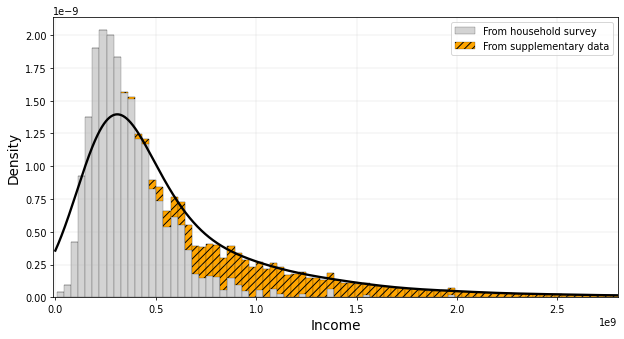

In [105]:
# import pandas as pd
# from scipy.stats import gaussian_kde
# import numpy as np
# import matplotlib.pyplot as plt
# mpl.rcParams['text.usetex'] = True
# year=98

for year in range(98,99):
    IranSample = pd.read_csv(f'../Data/Simulated Sample/TehranSample{year}.csv')

    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import gaussian_kde

    # --- data ---
    income = IranSample['hazinehPerCapita'].values
    weights = IranSample['weight'].values
    top = IranSample['top'].values

    # --- histogram with per-bin share of top==1 ---

    bins = 1000  # or 1000, but 100 often looks nicer

    # common bin edges
    counts_all, bin_edges = np.histogram(income, bins=bins, weights=weights)
    counts_top1, _       = np.histogram(income[top == 1],
                                        bins=bin_edges,
                                        weights=weights[top == 1])

    bin_widths = np.diff(bin_edges)
    bin_centers = bin_edges[:-1] + bin_widths/2

    total_weight = weights.sum()

    # density for all obs, so that integral over x is 1
    density_all  = counts_all  / (total_weight * bin_widths)
    density_top1 = counts_top1 / (total_weight * bin_widths)

    # share in each bin (can be NaN where no obs; replace with 0)
    share_top1 = np.divide(counts_top1, counts_all,
                        out=np.zeros_like(counts_top1, dtype=float),
                        where=counts_all > 0)

    # --- plotting ---

    plt.figure(figsize=(10.4, 5.2))

    # base bar: total density (light gray)
    plt.bar(
        bin_centers,
        density_all,
        width=bin_widths,
        align='center',
        color='lightgray',     # soft gray
        edgecolor='black',     # thin outline helps visibility
        linewidth=0.2,
        label='From household survey'
    )

    # top segment: density from top==1 (hatched)
    plt.bar(
        bin_centers,
        density_top1,
        width=bin_widths,
        align='center',
        bottom=density_all - density_top1,
        color='orange',         # keep white so pattern stands out
        edgecolor='black',
        linewidth=0.2,
        hatch='///',           # choose a pattern that prints well
        label='From supplementary data'
    )


    # --- KDE over all incomes (unchanged) ---
    income_range = np.linspace(0, 2.8 * 1e9, 2000)
    kde = gaussian_kde(income, weights=weights)
    density = kde.evaluate(income_range)
    plt.plot(income_range, density, color='black', linewidth=2.4)

    # --- text and labels ---
    # plt.title(r'$(1-\lambda_x) f_Y^1 + \lambda_x f_Y^2$', fontsize=18)
    plt.xlabel('Income', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(linewidth=0.4, alpha=0.5)
    plt.xlim(-1e7, 2.8 * 1e9)
    plt.legend()

    plt.savefig(f'../Figures/Robustness/mccrary_test_income_{year}.pdf',transparent=True,bbox_inches="tight")
    plt.show()



# Robustness: Other Provinces

In [87]:
data = data.loc[(data.outlier != 1),:]


In [88]:
# province_set=["02","01"]
province_set=["01"]


""" Initialize the Output dataframes """
result = np.zeros(shape=(10,1))
result = pd.DataFrame(result, columns=["year"])
result.year = np.arange(1389,1399)

Iran = result.copy()
alpha_beta_Tehran = result.copy()
tau_x0 = result.copy()

share = result.copy()
shareIran = result.copy()
shareTen= result.copy()
shareFive= result.copy()
shareOne= result.copy()
shareTenIran= result.copy()
shareFiveIran= result.copy()
shareOneIran= result.copy()
table= result.copy()


"""--------------------------------------------------------------------"""
""" LET'S GO """

different_threshold_of_top_HIES = [90] #[85,95,90] 

for tauThreshold in different_threshold_of_top_HIES: 
    
    for year in np.arange(89,99):

        """
            Estimating theta from survey    
        """
        expenditure = expenditureTotal.loc[(expenditureTotal.year==year),:]

        expenditure = expenditure.loc[(expenditure.hazinehPerCapita.notna()) & (expenditure.LnRent.notna())
                                     &(expenditure.weight.notna()) & (expenditure.hazinehPerCapita != 0),:]

        """ calculating empirical cumulative density function """
        # expenditure.sort_values(by=["province","hazinehPerCapita"],inplace=True)
        # expenditure['Fy'] = expenditure.groupby('province')['weight'].apply(lambda x: x.cumsum() / x.sum())
                        
        # expenditure.sort_values(by=["province","rent"],inplace=True)
        # expenditure['FRent'] = expenditure.groupby('province')['weight'].apply(lambda x: x.cumsum() / x.sum())
        
        """-------------------------------------------------"""
        Sample = pd.DataFrame([])

        for flag, prov in enumerate(province_set):
            provName = next(key for key, value in provinceCodeEng.items() if value == prov)

            Tehran= expenditure[expenditure.provNew.isin([prov])]
            Tehran= Tehran.sort_values(by= ['hazinehPerCapita'])
            Tehran['Fy']= Tehran.weight.cumsum() 
            Tehran['Fy']= Tehran.Fy / Tehran.weight.sum()

            # -----------------------------------------
            """ calculating alpha from house price data """
            new = data[(data["provNew"].isin([prov])) & (data['year']==(1300+year) )]

            # define new variables
            new.sort_values(by=["provNew","totalPrice"],inplace=True)
            new['Gy'] = new.groupby('provNew')['weight'].apply(lambda x: x.cumsum() / x.sum()) #.reset_index(level=['provNew'], drop=True)

            # topCodeRent = new.loc[(new.Gy>0.999),"totalPrice"].min()
            # new.loc[(new.Gy>0.999),"totalPrice"] = topCodeRent

            """ 
                calculating alpha from data for different top share of data
                alpha: top house price data pareto tail index
            """
            # space=np.arange(0.5, 0.99, 0.05)
            # alpha=np.zeros(shape=(19,6))

            # for index,topPercentile in enumerate(space):
                
            #     # Rent_Top_Incomes_HIES = Tehran.loc[(Tehran.Fy>(topPercentile-0.02)) & (Tehran.Fy<(topPercentile+0.02)), "rent"].mean()
            #     # Price_to_Mortgage_Ratio = price_rent_ratio.loc[(price_rent_ratio.year==(1300+year)),"ratio_mean"].values[0]
            #     # TopRentmean= Price_to_Mortgage_Ratio * Rent_Top_Incomes_HIES * (100/3) / 10000000 
            #     # N = new[new.totalPrice >= topPercentile]

            #     N=new[new.Gy>=topPercentile]
            #     N.sort_values('totalPrice',inplace=True)
            #     N.reset_index(drop=True, inplace=True)

            #     # new estimation method with Maximum Likelihood ------------------------------
            #     # Fit Pareto distribution to the variable
            #     loc = N.totalPrice.min()
            #     n = N.shape[0]
            #     alpha_N = (n) / (N.LnPrice.sum() - n*np.log(loc))
            #     # ---------------------------------------------------------------------------

            #     N['G2y']=(N.index+1) / (N['totalPrice'].count())  
            #     N.drop(N.tail(1).index,inplace=True)
            #     N['Xvariable']= -np.log(1-N['G2y'])     
            #     """ dropping nan, inf from data to avoid error in regression """
            #     N.replace(np.inf , np.nan,inplace=True)
            #     N.dropna(subset=['LnPrice', 'Xvariable'], how="all",inplace=True)

            #     x=N['Xvariable']
            #     y=N['LnPrice']- np.log(loc)

            #     results = sm.OLS(y,x,missing='drop').fit()
            #     alpha[index,0]=topPercentile
            #     alpha[index,1]= alpha_N #1/results.params[1]
            #     se=results.bse[0]
            #     alpha[index,4]=se
            #     alpha[index,2]= 1/(1/alpha_N + 2*se) 
            #     alpha[index,3]= 1/(1/alpha_N - 2*se)
            #     alpha[index,5]= 1/results.params[0]

            # -----------------------------------------
            """ alpha from new approach: tau -> rent -> house price -> alpha """
            # tau = tauThreshold * 1e7 #* cpi.loc[(cpi.year==year), : ].cpi.values[0]
            # tau = Tehran.loc[(Tehran.Fy>=(tauThreshold/100)),"hazinehPerCapita"].min()
            # lambda_tau = 1 - Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
            
            # Rent_Top_Incomes_HIES = Tehran.loc[(Tehran.Fy> 1-lambda_tau-0.02)&(Tehran.Fy< 1-lambda_tau+0.02), "rent"].mean()
            # Rent_Top_Incomes_HIES = Tehran.loc[(Tehran.hazinehPerCapita>(0.9*tau)) & (Tehran.hazinehPerCapita<(1.1*tau) ), "rent"].mean()
            Rent_Top_Incomes_HIES = Tehran.loc[(Tehran.FRent>= (tauThreshold/100)), "rent"].min()
            # tau = Tehran.loc[(Tehran.FRent> (tauThreshold/100)-0.02)&(Tehran.FRent< (tauThreshold/100)+0.02), "hazinehPerCapita"].mean()

            Price_to_Mortgage_Ratio = price_rent_ratio.loc[(price_rent_ratio.year==(1300+year)),"ratio_mean"].values[0]
            # Price_to_Mortgage_Ratio = 5

            TopRentmean= Rent_Top_Incomes_HIES * Price_to_Mortgage_Ratio * (100/3) / 10000000
            
            # xx = new.loc[new.totalPrice>TopRentmean, "Gy"].min()
            # print(xx)

            N = new[new.totalPrice>TopRentmean]
            N.sort_values('totalPrice',inplace=True)
            N.reset_index(drop=True, inplace=True)  
            N['G2y'] = N.weight.cumsum()
            N['G2y'] = N.G2y / N.weight.sum()

            # new estimation method with Maximum Likelihood ------------------------------
            # Fit Pareto distribution to the variable
            loc = N.totalPrice.min()
            n = N.shape[0]
            mianeAlpha = (n) / (N.LnPrice.sum() - n*np.log(loc))
            # print(mianeAlpha) 

            # ----------------------------------------------------------------------------
            # dropping nan, inf from data to avoid error in regression            
            N['Xvariable']= -np.log(1-N['G2y'])     
            # N.drop(N.tail(1).index,inplace=True)

            # N['G2y']=(N.index+1) / (N['totalPrice'].count())  
            N.replace(np.inf , np.nan,inplace=True)
            N.dropna(subset=['LnPrice', 'Xvariable'], how="all",inplace=True)
            x=N['Xvariable']
            y=N['LnPrice'] - np.log(loc)
            results = sm.OLS(y,x,missing='drop').fit()
            mianeAlpha2 = 1/results.params[0]
            seAlpha=results.bse[0]

            # estimate the share of top house residents in the survey
            lambda_house_survey = 1 - Tehran.loc[(Tehran.rent>=Rent_Top_Incomes_HIES),:].FRent.min()
            result.loc[(result.year==(1300+year)) , "lambdaHouseSurv"+prov] = lambda_house_survey *100
            # print(lambda_house_survey *100)

            # ----------------------------------------------------------------------------
            # """ first Approach theta estimated """
            # # top_rent = Tehran.loc[Tehran['hazinehPerCapita']>=tau,:]
            # # top_rent = Tehran.loc[Tehran['Fy']>= 0.7,:]
            # top_rent = Tehran.loc[(Tehran['FRent']>=0.80)&(Tehran.LnHazineh.notna()) & (Tehran.LnRent.notna()) & (Tehran.weight.notna()), :]
            # x=top_rent['LnRent']
            # y=top_rent['LnHazineh']
            # results = mt.reg(top_rent, 'LnHazineh', 'LnRent', addcons=True ,awt_name='weight')
            # mianeBeta = results.beta['LnRent']
            # seBeta = results.se['LnRent']
            # # print(mianeBeta)

            # """ calculating confidence interval for theta second approach """
            # # seBeta = theta_hat.loc[(theta_hat.percentile>=0.80)
            # #          &(theta_hat.percentile<=0.95),"beta_se"].quantile(q=0.5)

            # a=np.random.normal(loc=1/mianeAlpha,scale=seAlpha,size=1000000)

            # b=np.random.normal(loc= mianeBeta, scale=seBeta, size=1000000)
            # d=1/(a*b)
            # d=pd.DataFrame(d)

            # theta_hat2_lower = d.quantile(q=0.05)[0]
            # theta_hat2_upper = d.quantile(q=0.95)[0]   


            # ----------------------------------------------------------------------------
            # estimate a non-linear model
            topPercentile = 0.7
            rentTehran = Tehran.loc[(Tehran['FRent']>=topPercentile) , :].copy()
            # rentTehran["LnRent"] = rentTehran.LnRent - np.log(Rent_Top_Incomes_HIES)
            rentTehran = rentTehran.loc[(rentTehran['LnRent'].notna()) & (rentTehran['LnHazineh'].notna()), :]
            rentTehran["LnRent2"] = rentTehran.LnRent**2
            rentTehran["LnRent3"] = rentTehran.LnRent**3
            
            # Define the dependent variable
            y = rentTehran['LnHazineh']
            X = rentTehran.loc[:, ['LnRent']]
            weights = rentTehran['weight']
            model = sm.WLS(y, sm.add_constant(X), weights=weights)
            results = model.fit()

            # Get the slope, constant, and R-squared
            slope_0 = results.params['const']
            slope_1 = results.params['LnRent'] # 0.787 * (prov=="01") + 0.612 * (prov=="02") + 0.527 * (prov=="03")
            slope_1_year = results.params['LnRent']
            slope_2 = 0 #results.params['LnRent2']
            slope_3 = 0 #results.params['LnRent3']
            # slope_se = results.bse['LnRent']
            r_squared = results.rsquared

            print(slope_1)

            # ----------------------------------------------------------------------------
            # fig= plt.figure(figsize=(9.5,6))
            # ax1 = fig.add_subplot(1,1,1)
            
            # x_plot=np.linspace(rentTehran.LnRent.min(), rentTehran.LnRent.max(), 200)
            # ax1.plot(x_plot, x_plot*x_plot*slope_2 + x_plot*slope_1 + slope_0 , linewidth=2.9,label="regression line",color="black")
            
            # ax1.scatter(rentTehran['LnRent'], rentTehran['LnHazineh'] , color="gray", label="data")
            # ax1.set_xlabel('house rental value (in log)', fontsize=14,labelpad=10)
            # ax1.set_ylabel('household total income (in log)', fontsize=14,labelpad=10)
            # ax1.grid(axis= 'y',alpha=0.5)
            # ax1.tick_params(labelsize=13)
            # ax1.spines['right'].set_visible(False)
            # ax1.spines['top'].set_visible(False)
            # ax1.text(0.95, 0.02, f'R2= {r_squared:.2f}', transform=ax1.transAxes, verticalalignment='bottom', horizontalalignment='right', fontsize=12)
            # plt.show()

            # ----------------------------------------------------------------------------
            # Gini for the province    
            thetaEstimated = mianeAlpha / slope_1
            
            """ filling the 'alpha_beta_Tehran' output for report """
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"alpha"] = mianeAlpha
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"beta"] = slope_1
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_hat"] = thetaEstimated
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_hat_lower"] = theta_hat2_lower 
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_hat_upper"] = theta_hat2_upper
            
            # theta["percentile"] = np.round(theta.percentile,decimals=2)
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta"] = theta.loc[(theta.percentile==0.94),"theta"].values[0]
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_lower"] = theta.loc[(theta.percentile==0.94),"theta_lower"].values[0]
            # alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_upper"] = theta.loc[(theta.percentile==0.94),"theta_upper"].values[0]
           
            """ Filling the 'tau_x0' output data frame """
            # tau_x0.loc[tau_x0.year==(1300+year),"tau"] = tau / 1e7
            # tau_x0.loc[tau_x0.year==(1300+year),"tau_real"] = (tau / 1e7) * cpi.loc[(cpi.year==year), : ].cpi.values[0]
            # tau_x0.loc[tau_x0.year==(1300+year),"R0"]  = Rent_Top_Incomes_HIES * (100/3) / 1e7
            # tau_x0.loc[tau_x0.year==(1300+year),"x0"]  = TopRentmean

            # ----------------------------------------------------------------------------
            """ estimating lambda """
            # estimate true share of top house residents
            T = Tehran.loc[(Tehran.rent<Rent_Top_Incomes_HIES),:]
            T= T.sort_values(by= ['rent'])
            T['Gy'] = T.weight.cumsum()
            T['Gy'] = T.Gy / T.weight.sum()
            results = mt.reg( T.loc[(T.Gy>0.9),:], 'Gy', 'rent', addcons=True)
            g1Tau = results.beta['rent']
            del T

            N = new[new.totalPrice>TopRentmean]
            N = N.sort_values(by=['totalPrice'])
            N['totalPrice'] = N.totalPrice * 10000000 / (Price_to_Mortgage_Ratio * (100/3))
            N['Gy'] = N.weight.cumsum()
            N['Gy'] = N.Gy / N.weight.sum()
            results = mt.reg( N.loc[(N.Gy<0.1),:], 'Gy', 'totalPrice', addcons=True)
            g2Tau = results.beta['totalPrice']
            # print(np.log(N.totalPrice.max()))
            # print(np.log(Tehran.rent.max()))

            # g2Tau= mianeAlpha / Rent_Top_Incomes_HIES
            lambda_house = g1Tau / (g1Tau+g2Tau)
            result.loc[(result.year==(1300+year)) , "lambdaHouse"+prov] = lambda_house *100
            # print(lambda_house *100)


            # T = Tehran.loc[(Tehran.hazinehPerCapita< tau), :]
            # T= T.sort_values(by= ['hazinehPerCapita'])
            # T['Fy']= T.Fy / T.weight.sum()
            # T['Fy']= T.weight.cumsum() 
            # results = mt.reg(
            #     T.loc[(T.Fy>0.9),:],      # DataFrame
            #     'Fy',                      # Dependent var (string)
            #     'hazinehPerCapita',        # Independent var(s) (string or list of strings)
            #     addcons=True
            #     )

            # f1Tau= results.beta['hazinehPerCapita']
            # f2Tau= thetaEstimated / tau * 1e7
            # landa= f1Tau / (f1Tau+f2Tau)
            # result.loc[(result.year==(1300+year)) , "lambda"+prov]        = landa *100

            # landaSurvey = 1-Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
            # result.loc[(result.year==(1300+year)) , "lambdaSurvey"+prov]  = landaSurvey *100




            # estimate mean income using survey
            # muSurvey = np.average(Tehran.hazinehPerCapita, weights=Tehran.weight)

            # ----------------------------------------------------------------------------
            # approach 1 -------------------
        
            # N_sample_size = 100000
            # TopIncomesample = (np.random.pareto(mianeAlpha, N_sample_size) + 1) * Rent_Top_Incomes_HIES 
            # TopIncomesample = pd.DataFrame(TopIncomesample,columns=["rent"])
            # TopIncomesample["LnRent"] = np.log(TopIncomesample.rent) 
            # TopIncomesample["LnRent"] = np.log(TopIncomesample.rent) - np.log(Rent_Top_Incomes_HIES)

            TopIncomesample = new[new.totalPrice>TopRentmean]
            TopIncomesample["LnRent"] = np.log(TopIncomesample.totalPrice * 10000000 / (Price_to_Mortgage_Ratio * (100/3)) )
            TopIncomesample = TopIncomesample[["LnRent"]]
            N_sample_size = TopIncomesample.shape[0]
            # TopIncomesample["LnRent"] = TopIncomesample.LnRent - np.log(Rent_Top_Incomes_HIES)
            
            # TopIncomesample["hazinehPerCapita"] = np.exp(np.log(tau) + slope_1*TopIncomesample.LnRentDev)
            TopIncomesample["hazinehPerCapita"] = np.exp(slope_0 + slope_1*TopIncomesample.LnRent + slope_2*(TopIncomesample.LnRent**2) + slope_3*(TopIncomesample.LnRent**3))
            
            sigma_weight_low_income = Tehran.loc[(Tehran.rent<Rent_Top_Incomes_HIES),:].weight.sum()
            TopIncomesample["weight"] = sigma_weight_low_income / ((1/lambda_house - 1) * N_sample_size)
            TopIncomesample["top"]=1 
            Tehran["top"]=0
            TehranSample = pd.concat([TopIncomesample, Tehran.loc[(Tehran.rent<Rent_Top_Incomes_HIES),["weight","hazinehPerCapita"]] ],axis=0)


            # approach 2 -------------------
            # # create the simulated data for the province
            # N_sample_size = 1000000
            # TopIncomesample = (np.random.pareto(thetaEstimated, N_sample_size) + 1) * tau
            # TopIncomesample = pd.DataFrame(TopIncomesample,columns=["hazinehPerCapita"])
            
            # sigma_weight_low_income = Tehran.loc[(Tehran.hazinehPerCapita<tau),:].weight.sum()
            # TopIncomesample["weight"] = sigma_weight_low_income / ((1/landa - 1) * N_sample_size)
            # TehranSample = pd.concat([TopIncomesample, Tehran.loc[(Tehran.hazinehPerCapita<tau),["weight","hazinehPerCapita"]] ],axis=0)


            # re-weight to balance population distribution
            TehranSample["weight"] = TehranSample["weight"] * np.sum(Tehran.weight) / np.sum(TehranSample.weight)
            
            TehranSample= TehranSample.sort_values(by= ['hazinehPerCapita'])
            TehranSample['Fy']= TehranSample.weight.cumsum() 
            TehranSample['Fy']= TehranSample.Fy / TehranSample.weight.sum()          

            Sample = pd.concat([Sample, TehranSample], axis=0)
            """ Save Simulated Data for Tehran """
            #TehranSample.to_csv(f'../Data/Simulated Sample/Simulated{year}.csv')
            #TehranSample.to_stata(f'../Data/Simulated Sample/Simulated{year}.dta')


        # ----------------------------------------------------------------------------
        """ Simulated Data for the whole country """
        expenditure["top"] = 0
        
        IranSample = pd.concat([Sample, expenditure.loc[~(expenditure.provNew.isin(province_set)),["weight","hazinehPerCapita","top"]] ],axis=0)

        IranSample= IranSample.sort_values(by= ['hazinehPerCapita'])
        IranSample['Fy']= IranSample.weight.cumsum()

        IranSample['Fy']= IranSample.Fy / IranSample.weight.sum()

        # IranSample.to_csv(f'../Data/Simulated Sample/IranSample{year}.csv')
        
        # ----------------------------------------------------------------------------
        """ Filling Iran dataframe calculating empirical cumulative density function """

        # new code as replacement -------------------------------
        # IranLandaSurvey = 1 - expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].Fy.min()
        # Iran.loc[(Iran.year==(1300+year)),"lambdaSurvey"] = IranLandaSurvey *100

        # landaTotal = 1 - IranSample.loc[(IranSample.hazinehPerCapita>=tau),:].Fy.min()
        # Iran.loc[(Iran.year==(1300+year)),"lambda"] = landaTotal *100

        # muTopIran = np.average(expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].hazinehPerCapita, weights=expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].weight)
        # muKol = np.average(expenditure.hazinehPerCapita, weights=expenditure.weight)
        # sTotalIranSurvey = expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].weight.sum()*muTopIran/(muKol*expenditure.weight.sum())
        # Iran.loc[(Iran.year==(1300+year)),"sSurvey"] = sTotalIranSurvey *100

        # muTopIranEst = np.average(IranSample.loc[(IranSample.hazinehPerCapita>=tau),:].hazinehPerCapita, weights=IranSample.loc[(IranSample.hazinehPerCapita>=tau),:].weight)
        # muKolEst = np.average(IranSample.hazinehPerCapita, weights=IranSample.weight)
        # sTotalIranSurveyEst = IranSample.loc[(IranSample.hazinehPerCapita>=tau),:].weight.sum()*muTopIranEst/(muKolEst*IranSample.weight.sum())
        # Iran.loc[(Iran.year==(1300+year)),"s"] = sTotalIranSurveyEst *100


        GiniIranSurvey = gini(expenditure.hazinehPerCapita, w=expenditure.weight)
        Iran.loc[(Iran.year==(1300+year)),"GiniSurvey"] = GiniIranSurvey *100
        
        GiniIran = gini(IranSample.hazinehPerCapita, w=IranSample.weight)
        Iran.loc[(Iran.year==(1300+year)),"Gini"] = GiniIran *100


        # new code replacement ------------------------------
        # landaSurvey = 1-Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
        # result.loc[(result.year==(1300+year)) , "lambdaSurvey"+prov]  = landaSurvey *100

        # landaTehran = 1 - TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:].Fy.min()
        # result.loc[(result.year==(1300+year)) , "lambda"+prov]        = landaTehran *100

        
        GiniSurvey = gini(Tehran.hazinehPerCapita, w=Tehran.weight)
        result.loc[(result.year==(1300+year)) , "GiniSurvey"+prov]    = GiniSurvey *100

        Gini = gini(TehranSample.hazinehPerCapita, w=TehranSample.weight)
        result.loc[(result.year==(1300+year)) , "Gini"+prov+f"_{tauThreshold}"] = Gini *100


        # muTopTehranSurv = np.average(Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].hazinehPerCapita, weights=Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].weight)
        # muKolTehranSurv = np.average(Tehran.hazinehPerCapita, weights=Tehran.weight)
        # sTotalTehranSurvey = Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].weight.sum()*muTopTehranSurv/(muKolTehranSurv*Tehran.weight.sum())
        # result.loc[(result.year==(1300+year)) , "sSurvey"+prov] = sTotalTehranSurvey *100

        # muTopTehranEst = np.average(TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:].hazinehPerCapita, weights=TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:].weight)
        # muKolTehranEst = np.average(TehranSample.hazinehPerCapita, weights=TehranSample.weight)
        # sTehran = TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:].weight.sum()*muTopTehranEst/(muKolTehranEst*TehranSample.weight.sum())
        # result.loc[(result.year==(1300+year)) , "s"+prov] = sTehran *100


        # ----------------------------------------------------------------------------
        """ estimating each decile share """    
        muTehranEst = np.sum(TehranSample.hazinehPerCapita * TehranSample.weight)

        # Tehran['hazinehPerCapita'] = np.around(Tehran.hazinehPerCapita/10000, decimals=5)
        muSurveyTehran = np.sum(Tehran.hazinehPerCapita * Tehran.weight )        
        
        # decile income share in Tehran
        for i in [1,2,3,4,5,6,7,8,9,10]:
            decile = TehranSample.loc[(TehranSample.Fy<=0.1*i + 0.01*(i==10))&(TehranSample.Fy>0.1*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight)
            share.loc[(share.year==(1300+year)), f"{i}DecileEst"] = 100*muDecile/muTehranEst

            decile = Tehran.loc[(Tehran.Fy<=0.1*i + 0.01*(i==10))&(Tehran.Fy>0.1*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight )
            share.loc[(share.year==(1300+year)), f"{i}DecileSurv"] = 100*muDecile/muSurveyTehran
        
        # quintile income share in Tehran
        for i in [1,2,3,4,5]:
            decile = TehranSample.loc[(TehranSample.Fy<=(0.2*i + 0.01*(i==5))) &(TehranSample.Fy>0.2*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight)
            share.loc[(share.year==(1300+year)), f"{i}est"] = 100*muDecile/muTehranEst
        
        for i in [1,2,3,4,5]:
            decile = Tehran.loc[(Tehran.Fy<=(0.2*i + 0.01*(i==5) )) & (Tehran.Fy>0.2*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight )
            share.loc[(share.year==(1300+year)), f"{i}surv"] = 100*muDecile/muSurveyTehran

        # ----------------------------------------------------------------------------
        #         estimating each 10%    
        for i in np.arange(1,11):
            halfDecile = TehranSample.loc[(TehranSample.Fy<=0.1*i + 0.01*(i==10))&(TehranSample.Fy>0.1*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareTen.loc[(shareTen.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muTehranEst
            shareTen.loc[(shareTen.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muTehranEst

            halfDecile = Tehran.loc[(Tehran.Fy<=0.1*i + 0.01*(i==10))&(Tehran.Fy>0.1*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareTen.loc[(shareTen.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muSurveyTehran
         
        #         estimating each half decile share(each 5%)    
        for i in np.arange(1,21):
            halfDecile = TehranSample.loc[(TehranSample.Fy<=0.05*i + 0.01*(i==20))&(TehranSample.Fy>0.05*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareFive.loc[(shareFive.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muTehranEst
            shareFive.loc[(shareFive.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muTehranEst

            halfDecile = Tehran.loc[(Tehran.Fy<=0.05*i + 0.01*(i==20))&(Tehran.Fy>0.05*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareFive.loc[(shareFive.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muSurveyTehran

        #         estimating each 1 p share(each 1%)    
        for i in np.arange(1,101):
            halfDecile = TehranSample.loc[(TehranSample.Fy<=0.01*i + 0.01*(i==100)) &(TehranSample.Fy>0.01*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareOne.loc[(shareOne.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muTehranEst
            shareOne.loc[(shareOne.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muTehranEst

        for i in np.arange(1,101):
            halfDecile = Tehran.loc[(Tehran.Fy<=0.01*i + 0.01*(i==100)) &(Tehran.Fy>0.01*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareOne.loc[(shareOne.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muSurveyTehran
              
        # ----------------------------------------------------------------------------
        # estimating each 10%    Iran
        expenditure.sort_values(by="hazinehPerCapita", inplace=True)
        expenditure["Fy"] = expenditure["weight"].cumsum() / expenditure["weight"].sum()
        muIranSurv = np.sum(expenditure.hazinehPerCapita * expenditure.weight)
        muIranEst = np.sum(IranSample.hazinehPerCapita * IranSample.weight)

        # quintile income share in Tehran
        for i in [1,2,3,4,5]:
            decile = IranSample.loc[(IranSample.Fy<=(0.2*i + 0.01*(i==5))) &(IranSample.Fy>0.2*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight)
            shareIran.loc[(share.year==(1300+year)), f"{i}est"] = 100*muDecile/muIranEst
        
        for i in [1,2,3,4,5]:
            decile = expenditure.loc[(expenditure.Fy<=(0.2*i + 0.01*(i==5) )) & (expenditure.Fy>0.2*(i-1)), :]
            muDecile = np.sum(decile.hazinehPerCapita * decile.weight )
            shareIran.loc[(share.year==(1300+year)), f"{i}surv"] = 100*muDecile/muIranSurv


        for i in np.arange(1,11):
            halfDecile = IranSample.loc[(IranSample.Fy<=0.1*i + 0.01*(i==10)) &(IranSample.Fy>0.1*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareTenIran.loc[(shareTenIran.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muIranEst
            shareTenIran.loc[(shareTenIran.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muIranEst

            halfDecile = expenditure.loc[(expenditure.Fy<=0.1*i + 0.01*(i==10)) &(expenditure.Fy>0.1*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareTenIran.loc[(shareTenIran.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muIranSurv
         
        #         estimating each half decile share(each 5%)    Iran
        for i in np.arange(1,21):
            halfDecile = IranSample.loc[(IranSample.Fy<=0.05*i + 0.01*(i==20)) &(IranSample.Fy>0.05*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareFiveIran.loc[(shareFiveIran.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muIranEst
            shareFiveIran.loc[(shareFiveIran.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muIranEst

            halfDecile = expenditure.loc[(expenditure.Fy<=0.05*i + 0.01*(i==20)) &(expenditure.Fy>0.05*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareFiveIran.loc[(shareFiveIran.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muIranSurv

        #         estimating each 1 p share(each 1%)    Iran
        for i in np.arange(1,101):
            halfDecile = IranSample.loc[(IranSample.Fy<=0.01*i + 0.01*(i==100)) &(IranSample.Fy>0.01*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareOneIran.loc[(shareOneIran.year==(1300+year)), f"{i}HalfDecileEst"] = 100*muHalfDecile/muIranEst
            shareOneIran.loc[(shareOneIran.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*muHalfDecile/muIranEst
    
            halfDecile = expenditure.loc[(expenditure.Fy<=0.01*i + 0.01*(i==100)) &(expenditure.Fy>0.01*(i-1)), :]
            muHalfDecile = np.sum(halfDecile.hazinehPerCapita * halfDecile.weight)
            shareOneIran.loc[(shareOneIran.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*muHalfDecile/muIranSurv
    
        result.loc[(result.year==(1300+year)), f"Gini"] = gini(TehranSample.hazinehPerCapita, w=TehranSample.weight)


        table.loc[(table.year==(1300+year)),"delta"] = slope_0
        table.loc[(table.year==(1300+year)),"beta"] = slope_1_year

        tau = Tehran.loc[(Tehran.Fy>=0.9),"hazinehPerCapita"].min()
        lambda_sur = 1 - Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
        lambda_est = 1 - TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),"Fy"].min()
        
        # table.loc[(table.year==(1300+year)),"lambda_sur"] = lambda_sur
        table.loc[(table.year==(1300+year)),"lambda_est"] = lambda_est

        # tau = expenditure.loc[(expenditure.Fy>=0.9),"hazinehPerCapita"].min()
        # lambda_sur = 1 - expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].Fy.min()
        # lambda_est = 1 - IranSample.loc[(IranSample.hazinehPerCapita>=tau),"Fy"].min()
        
        # table.loc[(table.year==(1300+year)),"lambda_sur_Iran"] = lambda_sur
        # table.loc[(table.year==(1300+year)),"lambda_est_Iran"] = lambda_est

        table.loc[(table.year==(1300+year)),"alpha"] = mianeAlpha

        T = Tehran.loc[(Tehran.FRent>= (90/100)), :]
        mianeAlpha_surv, loc_suv = pareto_mle(T.weight, T.rent)
        table.loc[(table.year==(1300+year)),"alpha_surv"] = mianeAlpha_surv


        T = Tehran.loc[(Tehran.hazinehPerCapita>=tau),:]
        theta_surv, loc = pareto_mle(T.weight, T.hazinehPerCapita)
        table.loc[(table.year==(1300+year)),"theta_surv"] = theta_surv

        T=  TehranSample.loc[(TehranSample.hazinehPerCapita>=tau),:]
        theta_est, loc = pareto_mle(T.weight, T.hazinehPerCapita)
        table.loc[(table.year==(1300+year)),"theta_est"] = theta_est




del new
# del Sample
# del Tehran
del N
# del samples
del expenditure
# del topIncome 
# del lowIncome 
# del rent 

tau_x0


0.7918862543312069
0.7341501128216236
0.7401841199756727
0.8331331238832992
0.6972421639462798
0.7095911682642526
0.8225390186845937
0.6399675973973695
0.7711313291638219
0.7937302182757618


,year
0,1389
1,1390
2,1391
3,1392
4,1393
5,1394
6,1395
7,1396
8,1397
9,1398


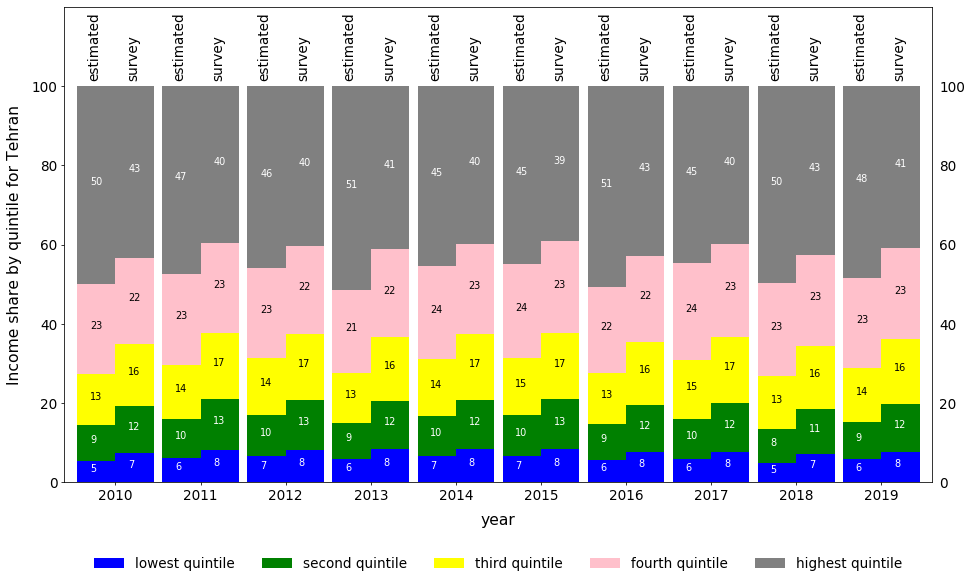

In [95]:
# Tehran
ssh = share.round(decimals=0).astype(int).copy()

## plot gini estimated and gini from survey ##

fig=plt.figure(figsize=(16,9))
ax1=fig.add_subplot(1,1,1)

ax1.bar(share.year+0.225, share["1surv"], label="",color= "blue",width=0.45)
ax1.bar(share.year+0.225, share["2surv"], label="", bottom=share["1surv"],color="green",width=0.45)
ax1.bar(share.year+0.225, share["3surv"], label="", bottom=share["1surv"]+share["2surv"],color="yellow",width=0.45)
ax1.bar(share.year+0.225, share["4surv"], label="", bottom=share["1surv"]+share["2surv"]+share["3surv"],color="pink",width=0.45)
ax1.bar(share.year+0.225, share["5surv"], label="", bottom=share["1surv"]+share["2surv"]+share["3surv"]+share["4surv"],color="gray",width=0.45)
    
tt = "surv"
for year in np.arange(1389,1399): 
    ax1.text(year+0.15,share.loc[(share.year==year),f"1{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"1surv"].values[0],color="white")
    ax1.text(year+0.15,share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"2surv"].values[0],color="white")
    ax1.text(year+0.15, share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0] + share.loc[(share.year==year),f"3{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"3surv"].values[0],color="black")
    ax1.text(year+0.15, share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0] + share.loc[(share.year==year),f"3{tt}"].values[0] + share.loc[(share.year==year),f"4{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"4surv"].values[0],color="black")
    ax1.text(year+0.15, share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0] + share.loc[(share.year==year),f"3{tt}"].values[0] + share.loc[(share.year==year),f"4{tt}"].values[0] + share.loc[(share.year==year),f"5{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"5surv"].values[0],color="w")
    

ax1.bar(share.year-0.225, share["1est"], label="lowest quintile",color= "blue",width=0.45)
ax1.bar(share.year-0.225, share["2est"], label="second quintile", bottom=share["1est"],color="green",width=0.45)
ax1.bar(share.year-0.225, share["3est"], label="third quintile", bottom=share["1est"]+share["2est"],color="yellow",width=0.45)
ax1.bar(share.year-0.225, share["4est"], label="fourth quintile", bottom=share["1est"]+share["2est"]+share["3est"],color="pink",width=0.45)
ax1.bar(share.year-0.225, share["5est"], label="highest quintile", bottom=share["1est"]+share["2est"]+share["3est"]+share["4est"],color="gray",width=0.45)

tt = "est"
for year in np.arange(1389,1399): 
    ax1.text(year-0.3,share.loc[(share.year==year),f"1{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"1est"].values[0],color="white")
    ax1.text(year-0.3,share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"2est"].values[0],color="white")
    ax1.text(year-0.3, share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0] + share.loc[(share.year==year),f"3{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"3est"].values[0],color="black")
    ax1.text(year-0.3, share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0] + share.loc[(share.year==year),f"3{tt}"].values[0] + share.loc[(share.year==year),f"4{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"4est"].values[0],color="black")
    ax1.text(year-0.3, share.loc[(share.year==year),f"1{tt}"].values[0] + share.loc[(share.year==year),f"2{tt}"].values[0] + share.loc[(share.year==year),f"3{tt}"].values[0] + share.loc[(share.year==year),f"4{tt}"].values[0] + share.loc[(share.year==year),f"5{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"5est"].values[0],color="w")
    
    
# ax1.grid(axis='y',alpha=0.4)
# # ax1.set_title(f'year {1300+year}')
ax1.set_xlabel('year', fontsize=16, labelpad=10)
ax1.set_ylabel('Income share by quintile for Tehran', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1389,1399,1))
ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
ax1.tick_params(labelsize=14)
ax1.legend(loc='upper center',edgecolor='w',prop={'size':14},ncol=5, handlelength=2.2, bbox_to_anchor=(0.5, -0.13))

ax1.set_xlim(1388.4,1398.6)
# plt.legend(patches, labels, loc="center left",edgecolor='gray',prop={'size':14}
#            , bbox_to_anchor=(1.1, 0.5 ))

# ax1.spines['bottom'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.spines['right'].set_visible(False)

ax1.set_ylim(-0.00,120)
ax1.set_yticks(np.arange(0.0,110,20))
for year in np.arange(1389,1399):
    ax1.text(year-0.33,102, "estimated" ,color="black", rotation=90,size=14)
    ax1.text(year+0.13,102, "survey" ,color="black", rotation=90,size=14)

plt.tick_params(labelright=True)

plt.show()
# fig.savefig(f'../Figures/Robustness/Income_shares_by_quintile2_new.pdf',transparent=True,bbox_inches="tight")

# fig.savefig(f'../Figures/Robustness/Income_shares_by_quintile2_robustness_other_provinces.pdf',transparent=True,bbox_inches="tight")

fig.savefig(f'../Figures/Income_shares_by_quintile2_robustness_data_cleaning.pdf',transparent=True,bbox_inches="tight")



In [91]:
import os

# Get the current working directory
cwd = os.getcwd()
print("Current working directory:", cwd)

# Check if a directory exists
path = "/path/to/directory"
if os.path.isdir(path):
    print("Directory exists:", path)
else:
    print("Directory does not exist:", path)

Current working directory: c:\Users\claudioq\Dropbox\Iran Inequality Measure, Zahra Shamlou\Python
Directory does not exist: /path/to/directory


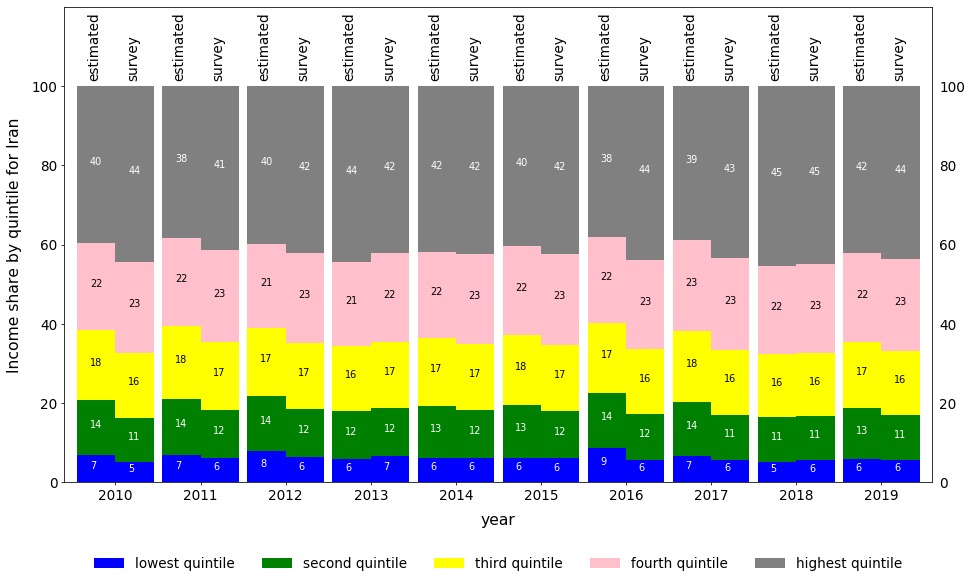

In [86]:
# Iran
ssh = shareIran.round(decimals=0).astype(int).copy()

## plot gini estimated and gini from survey ##

fig=plt.figure(figsize=(16,9))
ax1=fig.add_subplot(1,1,1)

ax1.bar(shareIran.year+0.225, shareIran["1surv"], label="",color= "blue",width=0.45)
ax1.bar(shareIran.year+0.225, shareIran["2surv"], label="", bottom=shareIran["1surv"],color="green",width=0.45)
ax1.bar(shareIran.year+0.225, shareIran["3surv"], label="", bottom=shareIran["1surv"]+shareIran["2surv"],color="yellow",width=0.45)
ax1.bar(shareIran.year+0.225, shareIran["4surv"], label="", bottom=shareIran["1surv"]+shareIran["2surv"]+shareIran["3surv"],color="pink",width=0.45)
ax1.bar(shareIran.year+0.225, shareIran["5surv"], label="", bottom=shareIran["1surv"]+shareIran["2surv"]+shareIran["3surv"]+shareIran["4surv"],color="gray",width=0.45)
    
tt = "surv"
for year in np.arange(1389,1399): 
    ax1.text(year+0.15,shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"1surv"].values[0],color="white")
    ax1.text(year+0.15,shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"2surv"].values[0],color="white")
    ax1.text(year+0.15, shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"3{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"3surv"].values[0],color="black")
    ax1.text(year+0.15, shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"3{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"4{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"4surv"].values[0],color="black")
    ax1.text(year+0.15, shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"3{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"4{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"5{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"5surv"].values[0],color="w")
    

ax1.bar(shareIran.year-0.225, shareIran["1est"], label="lowest quintile",color= "blue",width=0.45)
ax1.bar(shareIran.year-0.225, shareIran["2est"], label="second quintile", bottom=shareIran["1est"],color="green",width=0.45)
ax1.bar(shareIran.year-0.225, shareIran["3est"], label="third quintile", bottom=shareIran["1est"]+shareIran["2est"],color="yellow",width=0.45)
ax1.bar(shareIran.year-0.225, shareIran["4est"], label="fourth quintile", bottom=shareIran["1est"]+shareIran["2est"]+shareIran["3est"],color="pink",width=0.45)
ax1.bar(shareIran.year-0.225, shareIran["5est"], label="highest quintile", bottom=shareIran["1est"]+shareIran["2est"]+shareIran["3est"]+shareIran["4est"],color="gray",width=0.45)

tt = "est"
for year in np.arange(1389,1399): 
    ax1.text(year-0.3,shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"1est"].values[0],color="white")
    ax1.text(year-0.3,shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"2est"].values[0],color="white")
    ax1.text(year-0.3, shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"3{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"3est"].values[0],color="black")
    ax1.text(year-0.3, shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"3{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"4{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"4est"].values[0],color="black")
    ax1.text(year-0.3, shareIran.loc[(shareIran.year==year),f"1{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"2{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"3{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"4{tt}"].values[0] + shareIran.loc[(shareIran.year==year),f"5{tt}"].values[0]/2,
             ssh.loc[(ssh.year==year),"5est"].values[0],color="w")
    

# ax1.grid(axis='y',alpha=0.4)
# # ax1.set_title(f'year {1300+year}')
ax1.set_xlabel('year', fontsize=16, labelpad=10)
ax1.set_ylabel('Income share by quintile for Iran', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1389,1399,1))
ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
ax1.tick_params(labelsize=14)
ax1.legend(loc='upper center',edgecolor='w',prop={'size':14},ncol=5, handlelength=2.2, bbox_to_anchor=(0.5, -0.13))

ax1.set_xlim(1388.4,1398.6)
# plt.legend(patches, labels, loc="center left",edgecolor='gray',prop={'size':14}
#            , bbox_to_anchor=(1.1, 0.5 ))

# ax1.spines['bottom'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# ax1.spines['left'].set_visible(False)
# ax1.spines['right'].set_visible(False)

ax1.set_ylim(-0.00,120)
ax1.set_yticks(np.arange(0.0,110,20))
for year in np.arange(1389,1399):
    ax1.text(year-0.33,102, "estimated" ,color="black", rotation=90,size=14)
    ax1.text(year+0.13,102, "survey" ,color="black", rotation=90,size=14)

plt.tick_params(labelright=True)

plt.show()

# fig.savefig(f'../Figures/Robustness/Income_shares_by_quintile2_Iran_new.pdf',transparent=True,bbox_inches="tight")



# Robustness: House Rent

In [67]:


""" welfare criterion considered for measuring inequality indices """
criterion = 0
"""
    If 0 : Daramad
    If 1 : GHazineh / np.sqrt(tedad)
    If 2 : GHazineh
"""
""" Initialize the Output dataframes """
result = np.zeros(shape=(10,1))
result = pd.DataFrame(result, columns=["year"])
result.year = np.arange(1389,1399)

Iran = result.copy()
alpha_beta_Tehran = result.copy()
tau_x0 = result.copy()

share = np.zeros(shape=(10,6))
share = pd.DataFrame(result, columns=["year","1","2","3","4","5"])
share.year = np.arange(1389,1399)


shareTen=np.zeros(shape=(10,10))
shareTen=pd.DataFrame(result, columns=["year"])
shareTen.year = np.arange(1389,1399)

shareFive=np.zeros(shape=(10,10))
shareFive=pd.DataFrame(result, columns=["year"])
shareFive.year = np.arange(1389,1399)

shareOne=np.zeros(shape=(10,10))
shareOne=pd.DataFrame(result, columns=["year"])
shareOne.year = np.arange(1389,1399)

shareTenIran=np.zeros(shape=(10,10))
shareTenIran=pd.DataFrame(result, columns=["year"])
shareTenIran.year = np.arange(1389,1399)

shareFiveIran=np.zeros(shape=(10,10))
shareFiveIran=pd.DataFrame(result, columns=["year"])
shareFiveIran.year = np.arange(1389,1399)

shareOneIran=np.zeros(shape=(10,10))
shareOneIran=pd.DataFrame(result, columns=["year"])
shareOneIran.year = np.arange(1389,1399)

""" Define new vaiables: """
if   criterion == 0 :
    expenditureTotal['hazinehPerCapita'] = expenditureTotal.realDaramad #/ expenditureTotal.tedad
#     expenditureTotal["weight"] = expenditureTotal.weight * expenditureTotal.tedad

    figuresFolder = "Daramad"

    # elif criterion == 1 :
#     expenditureTotal['hazinehPerCapita'] = expenditureTotal.GHazineh/np.sqrt(expenditureTotal.tedad)
#     figuresFolder = "GHazinehPerCapita"
# elif criterion == 2 :
#     expenditureTotal['hazinehPerCapita'] = expenditureTotal.GHazineh
    
expenditureTotal['LnHazineh']= np.log(expenditureTotal.hazinehPerCapita)

# expenditureTotal['rent']= expenditureTotal['rent'] * 12
expenditureTotal['LnRent']= np.log(expenditureTotal.rent)#/expenditureTotal.area)

"""--------------------------------------------------------------------"""
""" LET'S GO """

different_threshold_of_top_HIES = [100,90,95] #[95]

for tauThreshold in different_threshold_of_top_HIES: 
    for year in np.arange(89,99):

        """
            Estimating theta from survey    
        """
        expenditure = expenditureTotal.loc[(expenditureTotal.year==year),:]

        expenditure = expenditure.loc[(expenditure.hazinehPerCapita.notna())
                                     &(expenditure.weight.notna()),:]

        """ calculating empirical cumulative density function """
        expenditure.sort_values(by=["province","hazinehPerCapita"],inplace=True)
        expenditure['Fy'] = expenditure.groupby('province')['weight'].transform(pd.Series.cumsum)
        expenditure['countProv']=expenditure.groupby('province')['weight'].transform(pd.Series.sum)
        expenditure['Fy'] = expenditure.Fy/expenditure.countProv
        expenditure.drop(columns=["countProv"], inplace=True)

        """-------------------------------------------------"""
        PTotal = 0
        sTotal = 0
        landaTotal = 0
        Sample = pd.DataFrame([])

        for flag, prov in enumerate(province_set):
            provName = next(key for key, value in provinceCodeEng.items() if value == prov)

            Tehran= expenditure[expenditure.province == prov]
            
            
            """-----------------------------------------
                             Theta    
            -----------------------------------------"""
            '''
                calculating theta from data ##
                theta: top income pareto tail index
                for different top share of data
            '''
            space=np.arange(0.8, 0.99, 0.01)
            theta=np.zeros(shape=(19,6))

            if Tehran.shape[0]==0:
                break

            for index,topPercentile in enumerate(space):


                T= Tehran[Tehran.Fy> topPercentile]

                if T.shape[0]==0:
                    break

                T= T.sort_values(by= ['hazinehPerCapita'])
                T.reset_index(inplace=True, drop=True)
                T['F2y']=T.weight.cumsum() 
                T['F2y']=T.F2y / T.weight.sum()
                T.drop(T.tail(1).index,inplace=True)
                T['Xvariable']= -np.log(1-T['F2y'])        

                """-------------------------------------------------"""
                results = mt.reg(
                T,                     # DataFrame
                'LnHazineh',           # Dependent var (string)
                'Xvariable',           # Independent var(s) (string or list of strings)
                addcons=True,
                awt_name='weight'     # Sample weights
                )

                """ save the coefficient to the data frame """
                theta[index,0]=topPercentile
                theta[index,1]= 1/results.beta['Xvariable']
                se=results.se['Xvariable']
                theta[index,4]= se

                theta[index,2]= 1/(results.beta['Xvariable']+ 1.6*se)
                theta[index,3]= 1/(results.beta['Xvariable']- 1.6*se) 
                
                theta[index,5]= T.hazinehPerCapita.min()/1e7

            

            """ plot theta for different top share """ 
            # fig=plt.figure(figsize=(9,6))
            # ax1=fig.add_subplot(1,1,1)
            # ax1.plot(theta[:,0], theta[:,1], color=(0,0,0,1))
            # # hline=ax1.hlines(theta[:,1].mean(), space[0], space[-1] , linestyles='--', color=(0, 0.4 ,1, 0.9))
            # ax1.fill_between(theta[:,0], theta[:,2],theta[:,3], color=(0,0,0,0.192)
            #                 ,linewidth= 1)
            # ax1.grid(axis='y')
            # # ax1.set_title(f'Figure 2:  Pareto tail index estimates for household expenditure per capita in Tehran')
            # ax1.set_xlabel(r'Percentile', fontsize=14,labelpad=10)
            # ax1.set_ylabel(r'$ \theta $ (from survey)' , fontsize=14,labelpad=10)
            # ax1.tick_params(labelsize=13)
            # plt.show()
            # #fig.savefig('figures/khousheh/theta_khousheh2D7.pdf',transparent=True)



            """-----------------------------------------
                calculating alpha from house price data    
            -----------------------------------------"""
    
            new = HouseRentTotal.loc[HouseRentTotal.year==(1300+year),:]
#             HouseRent = HouseRent.loc[(HouseRent.prov=="تهران")]

            new["weight"] = 1
        

            """ define new variables """
            new["LnPrice"] = np.log(new.FullMortgage)
            
            # new.sort_values(by=["prov","FullMortgage"],inplace=True)
            # new['Gy'] = new.groupby('prov')['weight'].transform(pd.Series.cumsum)
            # new['countProv']=new.groupby('prov')['weight'].transform(pd.Series.sum)
            # new['Gy'] = new.Gy/new.countProv
            # new.drop(columns=["countProv"],inplace=True)

            # new = new[new.Gy<=0.9995]
            

            """ 
                calculating alpha from data 
                alpha: top house price data pareto tail index
                for different top share of data
            """
            space=np.arange(0.8, 0.99, 0.01)
            alpha=np.zeros(shape=(19,5))

            for index,topPercentile in enumerate(space):
                
                Rent_Top_Incomes_HIES = Tehran.loc[
                     (Tehran.Fy> (topPercentile-0.02) )
                    &(Tehran.Fy< (topPercentile+0.02) ), "rent"].mean()
            
                # Price_to_Mortgage_Ratio = price_rent_ratio.loc[
                #     (price_rent_ratio.year==(1300+year)),"ratio_mean"].values[0]
                TopRentmean=  Rent_Top_Incomes_HIES * (100/3) / 10000000 
            
                # N=new[new.Gy>topPercentile]
                N = new[new.FullMortgage >= TopRentmean]
                N.sort_values('FullMortgage',inplace=True)
                N.reset_index(drop=True, inplace=True)

                N['G2y']=(N.index+1) / (N['FullMortgage'].count())  
                N.drop(N.tail(1).index,inplace=True)
                N['Xvariable']= -np.log(1-N['G2y'])     
                """ dropping nan, inf from data to avoid error in regression """
                N.replace(np.inf , np.nan,inplace=True)
                N.dropna(subset=['LnPrice', 'Xvariable'], how="all",inplace=True)

                x=N['Xvariable']
                y=N['LnPrice']

                results = sm.OLS(y,sm.add_constant(x),missing='drop').fit()
                alpha[index,0]=topPercentile
                alpha[index,1]= 1/results.params[1]
                se=results.bse[1]
                alpha[index,4]=se
                alpha[index,2]= 1/(results.params[1]+ 1.6*se)
                alpha[index,3]= 1/(results.params[1]- 1.6*se)



            """-----------------------------------------
                    calculating beta from survey    
            -----------------------------------------"""

            space=np.arange(0.8, 0.99, 0.01)
            beta=np.zeros(shape=(19,5))

            for index,topPercentile in enumerate(space):
                
                Rent_Top_Incomes_HIES = Tehran.loc[
                     (Tehran.Fy> (topPercentile-0.02) )
                    &(Tehran.Fy< (topPercentile+0.02) ), "rent"].mean()
                
                top_rent = Tehran[Tehran['rent']>=Rent_Top_Incomes_HIES]
                
                ###### droping 5 highest rent in data 
#                 top_rent.sort_values(by=["rent"], inplace=True)
#                 top_rent.reset_index(inplace=True)
#                 top_rent = top_rent.iloc[0:-6, :]
                
                x=top_rent['LnRent']
                y=top_rent['LnHazineh']

                results = mt.reg(
                top_rent,                 # DataFrame
                'LnHazineh',                 # Dependent var (string)
                'LnRent',                    # Independent var(s) (string or list of strings)
                addcons=True
                ,awt_name='weight'           # Sample weights
                )


                #results = sm.OLS(y,sm.add_constant(x),missing='drop').fit()
                beta[index,0]=topPercentile
                beta[index,1]= results.beta['LnRent']

                se= results.se['LnRent']
                beta[index,4]=se

                beta[index,2]= (results.beta['LnRent']+ 1.6*se)
                beta[index,3]= (results.beta['LnRent']- 1.6*se)



            """-----------------------------------------
                            theta     
            -----------------------------------------"""
            
            theta=pd.DataFrame(data=theta,columns=
                               ['percentile','theta','theta_lower','theta_upper'
                                ,'theta_se','tau'])

            beta=pd.DataFrame(data=beta,columns=
                              ['percentile','beta','beta_lower','beta_upper','beta_se'])
            beta["tau"] = theta["tau"]
            alpha=pd.DataFrame(data=alpha,columns=
                               ['percentile','alpha','alpha_lower','alpha_upper','alpha_se'])
            alpha["tau"] = theta["tau"]
            
            theta_hat=pd.merge(beta,alpha,on=['percentile'])
            theta_hat['theta_hat']=theta_hat.alpha/ theta_hat.beta
            
            theta_hat["tau"] = theta["tau"]

            for i in np.arange(0,len(theta_hat)):
                a=np.random.normal(loc=1/theta_hat.loc[i,'alpha'],scale=theta_hat.loc[i,'alpha_se'],size=1000000)

                b=np.random.normal(loc=theta_hat.loc[i,'beta'],scale=theta_hat.loc[i,'beta_se'],size=1000000)
                d=1/(a*b)
                d=pd.DataFrame(d)

                theta_hat.loc[i,'thetahat_lower']= d.quantile(q=0.05)[0]
                theta_hat.loc[i,'thetahat_upper']= d.quantile(q=0.95)[0]   

                """ thetahat__ : mean e oon thetahat e k ba bootstrap sakhtim!! """
                # theta_hat.loc[i,'thetahat__']= d.mean()[0]




            """
                alpha from new approach: tau -> rent -> house price -> alpha
            """
            tau = tauThreshold * 1e7 #* cpi.loc[(cpi.year==year), : ].cpi.values[0]
            
            lambda_tau = 1 - Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
            
#             Rent_Top_Incomes_HIES = Tehran.loc[
#                  (Tehran.Fy> 1-lambda_tau-0.02)
#                 &(Tehran.Fy< 1-lambda_tau+0.02), "rent"].mean()
            
            Rent_Top_Incomes_HIES = Tehran.loc[
                 (Tehran.hazinehPerCapita> (0.9*tau) )
                &(Tehran.hazinehPerCapita< (1.1*tau) ), "rent"].mean()

            TopRentmean=  Rent_Top_Incomes_HIES * (100/3) / 10000000 
            
            N = new[new.FullMortgage > TopRentmean]
            N["FullMortgage"] = N.FullMortgage / N.area #***************************************
            N["LnPrice"] = np.log(N.FullMortgage)     #***************************************
            N.sort_values('FullMortgage',inplace=True)
            N.reset_index(drop=True, inplace=True)

            N['G2y']=(N.index+1) / (N['FullMortgage'].count())  
            N.drop(N.tail(1).index,inplace=True)
            N['Xvariable']= -np.log(1-N['G2y'])     
            """ dropping nan, inf from data to avoid error in regression """
            N.replace(np.inf , np.nan,inplace=True)
            N.dropna(subset=['LnPrice', 'Xvariable'], how="all",inplace=True)

            x=N['Xvariable']
            y=N['LnPrice']

            results = sm.OLS(y,sm.add_constant(x),missing='drop').fit()

            mianeAlpha = 1/results.params[1]
            seAlpha=results.bse[1]


            """ first Approch theta estimated """
            # miane = theta_hat.loc[(theta_hat.percentile>=0.82)
            #          &(theta_hat.percentile<=0.92),"theta_hat"].quantile(q=0.5)
            top_rent = Tehran.loc[Tehran['FRent']>=0.7,:]

            x=top_rent['LnRent']
            y=top_rent['LnHazineh']

            results = mt.reg(
            top_rent,                 # DataFrame
            'LnHazineh',                 # Dependent var (string)
            'LnRent',                    # Independent var(s) (string or list of strings)
            addcons=True
            ,awt_name='weight'           # Sample weights
            )

            mianeBeta = results.beta['LnRent']
            seBeta = results.se['LnRent']
            
            
            # mianeBeta =  theta_hat.loc[(theta_hat.percentile>=0.80)
            #          &(theta_hat.percentile<=0.95),"beta"].quantile(q=0.5)

            # """ calculating confidence interval for theta second approach """
            # seBeta = theta_hat.loc[(theta_hat.percentile>=0.80)
            #          &(theta_hat.percentile<=0.95),"beta_se"].quantile(q=0.5)

            
            a=np.random.normal(loc=1/mianeAlpha,scale=seAlpha,size=1000000)

            b=np.random.normal(loc= mianeBeta, scale=seBeta, size=1000000)
            d=1/(a*b)
            d=pd.DataFrame(d)

            theta_hat2_lower = d.quantile(q=0.05)[0]
            theta_hat2_upper = d.quantile(q=0.95)[0]   


            """
                Graph Alpha and Beta together
            """
            # fig=plt.figure(figsize=(9,6))

            # ax1=fig.add_subplot(1,1,1)
            # ax1.plot("tau","alpha",data =alpha ,label='alpha',color=(0.0,0.4,0.5))
            # ax1.fill_between(alpha.tau, alpha.alpha_lower,alpha.alpha_upper,label='%90 CI',color=(0.0,0.4,0.5) )

            # ax1.plot("tau","beta",data=beta, color=(0,0,0,1),label="beta")

            # ax1.fill_between(beta.tau, beta.beta_lower,beta.beta_upper, color=(0,0,0,0.192)
            #                 ,linewidth= 1, label="%90 CI")

            # ax1.grid(axis='y',alpha=0.5)
            # ax1.set_xlabel('threshold tau', fontsize=14,labelpad=10)
            # ax1.set_ylabel('coefficient alpha and beta' , fontsize=14,labelpad=10)
            # ax1.tick_params(labelsize=13)
            # # ax1.set_xticks(np.arange(0.8,0.99,0.02))
            # ax1.spines['right'].set_visible(False)
            # ax1.spines['top'].set_visible(False)
            # plt.legend(loc=2,edgecolor='gray',prop={'size':12}, handlelength=2)
            # plt.show()
            # # fig.savefig(f'Figures/{figuresFolder}/Alpha_beta_{figuresFolder}_{year}.pdf',transparent=True,bbox_inches="tight")


            """
                Graph Theta and Theta_hat together
            """    
#             fig=plt.figure(figsize=(9,6))
#             ax1=fig.add_subplot(1,1,1)
#             ax1.plot("tau", "theta"
#                     ,data = theta[theta.percentile<=0.99]
#                     ,color=(0.1,0.1,0.9,0.9)
#                     ,label='theta survey')
#             ax1.fill_between('tau', 'theta_lower', 'theta_upper'
#                             ,data = theta[theta.percentile<=0.99]
#                             ,color=(0.1,0.1,0.9,0.1)
#                             ,linewidth= 1)

#             ax1.plot('tau', 'theta_hat',
#                     data=theta_hat[theta_hat.percentile<=0.99],
#                     color=(0,0.8,0.5,0.8),
#                     label='theta estimated')
#             ax1.fill_between('tau', 'thetahat_lower', 'thetahat_upper'
#                              ,data=theta_hat[theta_hat.percentile<=0.99]
#                              ,color=(0,0.8,0.5,0.15)
#                              ,linewidth= 1)
#             ax1.grid(axis='y',alpha=0.5)
#             ax1.set_ylabel(rf'coefficient theta',
#                            fontsize=15, labelpad=10)
#             ax1.set_xlabel('threshold tau', fontsize=15, labelpad=10)
#             plt.legend(loc='best',edgecolor='gray',prop={'size':12}, handlelength=2.2)
#             ax1.set_ylim(1,5)
#             ax1.set_xlim(80,105)
#             # ax1.set_title(provName+f" {1300+year}")
#             ax1.tick_params(labelsize=13)
#             ax1.spines['right'].set_visible(False)
#             ax1.spines['top'].set_visible(False)
#             plt.show()
#             # fig.savefig(f'Figures/{figuresFolder}/theta_{figuresFolder}_{year}.pdf',transparent=True,bbox_inches="tight")


            """-----------------------------------------
                    gini for the province    
            -----------------------------------------"""
            """ inputs: """
            thetaEstimated = mianeAlpha / mianeBeta
            
            """
             filling the 'alpha_beta_Tehran' output for report
            """
            alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"alpha"] = mianeAlpha
            alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"beta"] = mianeBeta
            alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_hat"] = thetaEstimated
            
            theta["percentile"] = np.round(theta.percentile,decimals=2)
            alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta"] = theta.loc[
                (theta.percentile==0.94),"theta"
            ].values[0]


            
#             if flag == 0 :
#                 tau = tauThreshold #Tehran.loc[(Tehran.Fy>=tauThreshold), "hazinehPerCapita"].min()    
#                 result.loc[(result.year==(1300+year)) , "thresholdTau"]   = tau

            
            """
                Filling the 'tau_x0' ouptut data frame
            """
            tau_x0.loc[tau_x0.year==(1300+year),"tau"] = tau / 1e7
            tau_x0.loc[tau_x0.year==(1300+year),"tau_real"] = (tau / 1e7) * cpi.loc[(cpi.year==year), : ].cpi.values[0]
            tau_x0.loc[tau_x0.year==(1300+year),"R0"]  = Rent_Top_Incomes_HIES * (100/3) / 1e7
            # tau_x0.loc[tau_x0.year==(1300+year),"x0"]  = TopRentmean
            
            
            """ estimating landa """
            T = Tehran.loc[(Tehran.hazinehPerCapita< tau), :]
            T= T.sort_values(by= ['hazinehPerCapita'])
            T['Fy']= T.weight.cumsum() 
            T['Fy']= T.Fy / T.weight.sum()
            results = mt.reg(
                T.loc[(T.Fy>0.95),:],      # DataFrame
                'Fy',                      # Dependent var (string)
                'hazinehPerCapita',        # Independent var(s) (string or list of strings)
                addcons=True
                )

            f1Tau= results.beta['hazinehPerCapita']
            f2Tau= thetaEstimated / tau
            landa= f1Tau / (f1Tau+f2Tau)
            result.loc[(result.year==(1300+year)) , "lambda"+prov]        = landa *100

            landaSurvey = 1-Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
            result.loc[(result.year==(1300+year)) , "lambdaSurvey"+prov]  = landaSurvey *100


            """ estimating s """

            lowIncome=Tehran.loc[(Tehran.hazinehPerCapita < tau ), :]
            topIncome=Tehran.loc[(Tehran.hazinehPerCapita > tau ), :]

            mu1 = np.average(lowIncome.hazinehPerCapita, weights=lowIncome.weight)
            mu2 = (thetaEstimated/(thetaEstimated-1)) * tau

            mu2Survey = np.average(topIncome.hazinehPerCapita, weights=topIncome.weight)

            mu = landa*mu2 + (1-landa)*mu1

            s = landa*mu2/mu
            result.loc[(result.year==(1300+year)) , "s"+prov]             = s *100

            """ s calculated from survey """
            muSurvey = landaSurvey*mu2Survey + (1-landaSurvey)*mu1
            sSurvey = landaSurvey*mu2Survey/muSurvey
            result.loc[(result.year==(1300+year)) , "sSurvey"+prov]       = sSurvey *100


            GiniSurvey = gini(Tehran.hazinehPerCapita, w=Tehran.weight)
            result.loc[(result.year==(1300+year)) , "GiniSurvey"+prov]    = GiniSurvey *100

            Gini1 = gini(lowIncome.hazinehPerCapita, w=lowIncome.weight)
            Gini2 = 1 / (2*thetaEstimated-1)

            Gini = (1-landa)*(1-s)*Gini1 + landa*s*Gini2 + s - landa
            result.loc[(result.year==(1300+year)) , "Gini"+prov+f"_{tauThreshold}"]          = Gini *100


            samples = (np.random.pareto(thetaEstimated, 100000) + 1) * tau
           
            """-----------------------------------------
                    Gini for the whole country    
            -----------------------------------------"""
            if flag == 0:
                GiniIranSurvey =  gini(expenditure.loc[(expenditure.hazinehPerCapita.notna()),:].hazinehPerCapita,
                                       w=expenditure.loc[(expenditure.hazinehPerCapita.notna()),:].weight)
                result.loc[(result.year==(1300+year)) , "GiniIranSurvey"]  = GiniIranSurvey *100


            P = Tehran.weight.sum()/expenditure.weight.sum()
            result.loc[(result.year==(1300+year)) , "P"+prov]  = P #*100

            samples = pd.DataFrame(samples,columns=["hazinehPerCapita"])
            samples["weight"] = P*landa
            Sample = pd.concat([Sample,samples],axis=0)

            PTotal = PTotal + P

            muOstan = np.average(Tehran.hazinehPerCapita, weights=Tehran.weight)
            muKol = np.average(expenditure.hazinehPerCapita, weights=expenditure.weight)
            provShareIncome = Tehran.weight.sum()*muOstan/(muKol*expenditure.weight.sum())

            sTotal = sTotal + provShareIncome*s
            landaTotal = landaTotal + landa*P



            """-----------------------------------------
                    estimating confidence interval for gini second approach    
            -----------------------------------------"""
            # thetaEstimated = theta_hat2_upper 
            # tau = Tehran.loc[(Tehran.Fy>=0.94), "hazinehPerCapita"].min()
            # f2Tau= thetaEstimated / tau
            # landa= f1Tau / (f1Tau+f2Tau)
            # ## estimating s ##
            # mu2 = (thetaEstimated/(thetaEstimated-1)) * tau
            # mu = landa*mu2 + (1-landa)*mu1
            # s = landa*mu2/mu
            # Gini2 = 1 / (2*thetaEstimated-1)
            # Gini = (1-landa)*(1-s)*Gini1 + landa*s*Gini2 + s - landa
            # result.loc[(result.year==(1300+year)) , "Gini_upper"]          = Gini *100

            # thetaEstimated = theta_hat2_lower 
            # tau = Tehran.loc[(Tehran.Fy>=0.94), "hazinehPerCapita"].min()
            # f2Tau= thetaEstimated / tau
            # landa= f1Tau / (f1Tau+f2Tau)
            # ## estimating s ##
            # mu2 = (thetaEstimated/(thetaEstimated-1)) * tau
            # mu = landa*mu2 + (1-landa)*mu1
            # s = landa*mu2/mu
            # Gini2 = 1 / (2*thetaEstimated-1)
            # Gini = (1-landa)*(1-s)*Gini1 + landa*s*Gini2 + s - landa
            # result.loc[(result.year==(1300+year)) , "Gini_lower"]          = Gini *100
            #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

       
    #added
  
            """-----------------------------------------
                estimating each decile share    
            -----------------------------------------"""
            N_sample_size = 100000
            TopIncomesample = (np.random.pareto(thetaEstimated, N_sample_size) + 1) * tau
            TopIncomesample = pd.DataFrame(TopIncomesample,columns=["hazinehPerCapita"])

            sigma_weight_low_income = Tehran.loc[(Tehran.hazinehPerCapita<tau),:].weight.sum()
            TopIncomesample["weight"] = sigma_weight_low_income / ((1/landa - 1) * N_sample_size)

            TehranSample = pd.concat([TopIncomesample, 
                                         Tehran.loc[(Tehran.hazinehPerCapita<tau),["weight","hazinehPerCapita"]] ],axis=0)

            TehranSample= TehranSample.sort_values(by= ['hazinehPerCapita'])
            TehranSample['Fy']= TehranSample.weight.cumsum() 
            TehranSample['Fy']= TehranSample.Fy / TehranSample.weight.sum()
        

    
            """
            ## Save Simulated Data for Tehran
            ###########################################################
            """
            #TehranSample.to_csv(f'/Users/ZShamloo/Dropbox/Iran Inequality Measure, Zahra Shamlou/Data/Simulated Sample/Simulated{year}.csv')
            #TehranSample.to_stata(f'/Users/ZShamloo/Dropbox/Iran Inequality Measure, Zahra Shamlou/Data/Simulated Sample/Simulated{year}.dta')



            
        """
        ## Simulated Data for the whole country
        ###########################################################
        """
        IranSample = pd.concat([TehranSample, 
                                     expenditure.loc[(expenditure.province != 23),["weight","hazinehPerCapita"]] ],axis=0)


        IranSample= IranSample.sort_values(by= ['hazinehPerCapita'])
        IranSample['Fy']= IranSample.weight.cumsum() 
        IranSample['Fy']= IranSample.Fy / IranSample.weight.sum()
  

    

        """
        ## Gini for the whole country
        ###########################################################
        #### Gini ####
        """
        zireTau = expenditure.loc[(expenditure.hazinehPerCapita<tau),:]
        Gini1 = gini(zireTau.hazinehPerCapita, w=zireTau.weight)
        otherProvinces = expenditure.loc[~(expenditure.province.isin(province_set)),:]
        landaOther = otherProvinces.loc[(otherProvinces.hazinehPerCapita>=tau),:].weight.sum()/otherProvinces.weight.sum()
        muOtherProvincesTop   = np.average(otherProvinces.loc[(otherProvinces.hazinehPerCapita>=tau),:].hazinehPerCapita, 
                                           weights=otherProvinces.loc[(otherProvinces.hazinehPerCapita>=tau),:].weight)
        muOtherProvinces = np.average(otherProvinces.hazinehPerCapita, weights=otherProvinces.weight)
        sOther =landaOther*muOtherProvincesTop/muOtherProvinces

        topIncomeOther = otherProvinces.loc[(otherProvinces.hazinehPerCapita>=tau),["hazinehPerCapita","weight"]]
        topIncomeOther["weight"] = landaOther*(1-PTotal)
        Sample = pd.concat([Sample,topIncomeOther],axis=0)
        Gini2 = gini(Sample.hazinehPerCapita, w=Sample.weight)


        muKol = np.average(expenditure.hazinehPerCapita, weights=expenditure.weight)
        otherShare = otherProvinces.weight.sum()*muOtherProvinces/(muKol*expenditure.weight.sum())

        landaTotal = landaTotal + (1-PTotal)*landaOther
        sTotal = sTotal + otherShare*sOther
        GiniIran = ( 
                    (1-landaTotal)*(1-sTotal)*Gini1 
                     + (sTotal)   
                     + landaTotal*sTotal*Gini2
                     - landaTotal
                   )
        result.loc[(result.year==(1300+year)) , f"GiniIran{tauThreshold}"]  = GiniIran *100

        """
            Filling Iran dataframe
        
            calculating empirical cumulative density function
        """
        expenditure["constant"] = 1
        expenditure.sort_values(by=["constant","hazinehPerCapita"],inplace=True)
        expenditure['Fy'] = expenditure.groupby('constant')['weight'].transform(pd.Series.cumsum)
        expenditure['countProv']=expenditure.groupby('constant')['weight'].transform(pd.Series.sum)
        expenditure['Fy'] = expenditure.Fy/expenditure.countProv
        expenditure.drop(columns=["countProv","constant"], inplace=True)


        IranLandaSurvey = 1 - expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].Fy.min()
        Iran.loc[(Iran.year==(1300+year)),"lambdaSurvey"] = IranLandaSurvey *100
        Iran.loc[(Iran.year==(1300+year)),"lambda"] = landaTotal *100

        muTopIran = np.average(expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].hazinehPerCapita,
                               weights=expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].weight)
        sTotalIranSurvey = expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].weight.sum()*muTopIran/(muKol*expenditure.weight.sum())
        Iran.loc[(Iran.year==(1300+year)),"sSurvey"] = sTotalIranSurvey *100
        Iran.loc[(Iran.year==(1300+year)),"s"] = sTotal *100

        Iran.loc[(Iran.year==(1300+year)),"GiniSurvey"] = GiniIranSurvey *100
        Iran.loc[(Iran.year==(1300+year)),"Gini"] = GiniIran *100



            # print("\n \n GiniTehran     = ",GiniTehran,
            #      "\n GiniOtherProvinces = ",GiniOtherProvinces,
            #      "\n muOtherProvinces   = ", muOtherProvinces,
            #      "\n muTehran           = ",muTehran,
            #      "\n muIran             = ",muIran,
            #      "\n S                  = ", S,
            #      "\n GiniIranSurvey     = ",GiniIranSurvey,
            #      "\n GiniIran           = ", GiniIran)







            ###########################################################
            ## calculating other indices
            ###########################################################
            # otherTopIncome = Tehran.loc[(Tehran.Fy>=0.8)&(Tehran.Fy<(1-landa)),:]
            # muOther = np.average(otherTopIncome.hazinehPerCapita, weights= otherTopIncome.weight)

            # muTop20 = (landa*mu2 + (0.2-landa)*muOther)/0.2

            # muLow20 = np.average(Tehran.loc[(Tehran.Fy<0.2),:].hazinehPerCapita,
            #                      weights= Tehran.loc[(Tehran.Fy<0.2),:].weight)

            # Top20toLow20 = muTop20/muLow20
            # result.loc[(result.year==(1300+year)) , "Top20toLow20"] = Top20toLow20

            # muTop20Survey = np.average(Tehran.loc[(Tehran.Fy>=0.8),:].hazinehPerCapita,
            #                      weights= Tehran.loc[(Tehran.Fy>=0.8),:].weight)

            # Top20toLow20Survey = muTop20Survey/muLow20
            # result.loc[(result.year==(1300+year)) , "Top20toLow20Survey"] = Top20toLow20Survey

            # Top20Share = 0.2 * muTop20 / mu
            # result.loc[(result.year==(1300+year)) , "Top20Share"]    = Top20Share

            # Top20ShareSurvey = 0.2*muTop20Survey/ muSurvey
            # result.loc[(result.year==(1300+year)) , "Top20ShareSurvey"] = Top20ShareSurvey



            # ## calculate each 2 deciles share ##
            # ## and fill the sahre data frame ##

            # share.loc[(share.year==(1300+year)),"5"] = Top20Share

            # for i in [1,2,3,4]:
            #     decile = Tehran.loc[(Tehran.Fy<0.2*i)
            #                        &(Tehran.Fy>=0.2*(i-1)), :]
            #     muDecile = np.average(decile.hazinehPerCapita,
            #                          weights= decile.weight)
            #     share.loc[(share.year==(1300+year)), f"{i}"] = 0.2*muDecile/mu




            
            
##added 
        muTehranEst = np.average(TehranSample.hazinehPerCapita, weights= TehranSample.weight)             
              
#          """------------------------------------------------
#                 estimating each 10%    
#         ------------------------------------------------"""
                  
    
        for i in np.arange(1,11):
                halfDecile = TehranSample.loc[(TehranSample.Fy<0.1*i)
                                   &(TehranSample.Fy>=0.1*(i-1)), :]
                muHalfDecile = np.average(halfDecile.hazinehPerCapita,
                                     weights= halfDecile.weight)
                shareTen.loc[(shareTen.year==(1300+year)), f"{i}HalfDecileEst"] = 100*0.1*muHalfDecile/muTehranEst
                shareTen.loc[(shareTen.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*0.1*muHalfDecile/muTehranEst
    
 


        for i in np.arange(1,11):
                halfDecile = Tehran.loc[(Tehran.Fy<0.1*i)
                                   &(Tehran.Fy>=0.1*(i-1)), :]
                muHalfDecile = np.average(halfDecile.hazinehPerCapita,
                                     weights= halfDecile.weight)
                shareTen.loc[(shareTen.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*0.1*muHalfDecile/muSurvey

 
         
#         """------------------------------------------------
#                 estimating each half decile share(each 5%)    
#         ------------------------------------------------"""
                  
    
        for i in np.arange(1,21):
                halfDecile = TehranSample.loc[(TehranSample.Fy<0.05*i)
                                   &(TehranSample.Fy>=0.05*(i-1)), :]
                muHalfDecile = np.average(halfDecile.hazinehPerCapita,
                                     weights= halfDecile.weight)
                shareFive.loc[(shareFive.year==(1300+year)), f"{i}HalfDecileEst"] = 100*0.05*muHalfDecile/muTehranEst
                shareFive.loc[(shareFive.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*0.05*muHalfDecile/muTehranEst
    
 


        for i in np.arange(1,21):
                halfDecile = Tehran.loc[(Tehran.Fy<0.05*i)
                                   &(Tehran.Fy>=0.05*(i-1)), :]
                muHalfDecile = np.average(halfDecile.hazinehPerCapita,
                                     weights= halfDecile.weight)
                shareFive.loc[(shareFive.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*0.05*muHalfDecile/muSurvey

 
     
#         """------------------------------------------------
#                 estimating each 1 p share(each 1%)    
#         ------------------------------------------------"""

   
        for i in np.arange(1,101):
                halfDecile = TehranSample.loc[(TehranSample.Fy<0.01*i)
                                   &(TehranSample.Fy>=0.01*(i-1)), :]
                muHalfDecile = np.average(halfDecile.hazinehPerCapita,
                                     weights= halfDecile.weight)
                shareOne.loc[(shareOne.year==(1300+year)), f"{i}HalfDecileEst"] = 100*0.01*muHalfDecile/muTehranEst
                shareOne.loc[(shareOne.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*0.01*muHalfDecile/muTehranEst
    

        for i in np.arange(1,101):
                halfDecile = Tehran.loc[(Tehran.Fy<0.01*i)
                                   &(Tehran.Fy>=0.01*(i-1)), :]
                muHalfDecile = np.average(halfDecile.hazinehPerCapita,
                                     weights= halfDecile.weight)
                shareOne.loc[(shareOne.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*0.01*muHalfDecile/muSurvey

 


              
#          """------------------------------------------------
#                 estimating each 10%    Iran
#         ------------------------------------------------"""
                  
    
        for i in np.arange(1,11):
                halfDecile = IranSample.loc[(IranSample.Fy<0.1*i)
                                   &(IranSample.Fy>=0.1*(i-1)), :]
                muHalfDecile = np.average(halfDecile.hazinehPerCapita,
                                     weights= halfDecile.weight)
                shareTenIran.loc[(shareTenIran.year==(1300+year)), f"{i}HalfDecileEst"] = 100*0.1*muHalfDecile/muTehranEst
                shareTenIran.loc[(shareTenIran.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*0.1*muHalfDecile/muTehranEst
    
 


        for i in np.arange(1,11):
                halfDecile = expenditure.loc[(expenditure.Fy<0.1*i)
                                   &(expenditure.Fy>=0.1*(i-1)), :]
                muHalfDecile = np.average(halfDecile.hazinehPerCapita,
                                     weights= halfDecile.weight)
                shareTenIran.loc[(shareTenIran.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*0.1*muHalfDecile/muSurvey

 
         
#         """------------------------------------------------
#                 estimating each half decile share(each 5%)    Iran
#         ------------------------------------------------"""
                  
    
        for i in np.arange(1,21):
                halfDecile = IranSample.loc[(IranSample.Fy<0.05*i)
                                   &(IranSample.Fy>=0.05*(i-1)), :]
                muHalfDecile = np.average(halfDecile.hazinehPerCapita,
                                     weights= halfDecile.weight)
                shareFiveIran.loc[(shareFiveIran.year==(1300+year)), f"{i}HalfDecileEst"] = 100*0.05*muHalfDecile/muTehranEst
                shareFiveIran.loc[(shareFiveIran.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*0.05*muHalfDecile/muTehranEst
    
 


        for i in np.arange(1,21):
                halfDecile = expenditure.loc[(expenditure.Fy<0.05*i)
                                   &(expenditure.Fy>=0.05*(i-1)), :]
                muHalfDecile = np.average(halfDecile.hazinehPerCapita,
                                     weights= halfDecile.weight)
                shareFiveIran.loc[(shareFiveIran.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*0.05*muHalfDecile/muSurvey

 
     
#         """------------------------------------------------
#                 estimating each 1 p share(each 1%)    Iran
#         ------------------------------------------------"""

   
        for i in np.arange(1,101):
                halfDecile = IranSample.loc[(IranSample.Fy<0.01*i)
                                   &(IranSample.Fy>=0.01*(i-1)), :]
                muHalfDecile = np.average(halfDecile.hazinehPerCapita,
                                     weights= halfDecile.weight)
                shareOneIran.loc[(shareOneIran.year==(1300+year)), f"{i}HalfDecileEst"] = 100*0.01*muHalfDecile/muTehranEst
                shareOneIran.loc[(shareOneIran.year==(1300+year)), f"{i}HalfDecileEst_thresh_{tauThreshold}"] = 100*0.01*muHalfDecile/muTehranEst
    

        for i in np.arange(1,101):
                halfDecile = expenditure.loc[(expenditure.Fy<0.01*i)
                                   &(expenditure.Fy>=0.01*(i-1)), :]
                muHalfDecile = np.average(halfDecile.hazinehPerCapita,
                                     weights= halfDecile.weight)
                shareOneIran.loc[(shareOneIran.year==(1300+year)), f"{i}HalfDecileSurv"] = 100*0.01*muHalfDecile/muSurvey


      
    
    
    
    
    
    
    
            

new = []
Sample = []
Tehran = []
T = []
N = []
samples = []
expenditure = []
topIncome = []
lowIncome = []
rent = []





In [68]:


# """ welfare criterion considered for measuring inequality indices """
# criterion = 0
# """
#     If 0 : Daramad
#     If 1 : GHazineh / np.sqrt(tedad)
#     If 2 : GHazineh
# """
# """ Initialize the Output dataframes """
# result = np.zeros(shape=(10,1))
# result = pd.DataFrame(result, columns=["year"])
# result.year = np.arange(1389,1399)

# Iran = result.copy()
# alpha_beta_Tehran = result.copy()
# tau_x0 = result.copy()

# share = np.zeros(shape=(10,6))
# share = pd.DataFrame(result, columns=["year","1","2","3","4","5"])
# share.year = np.arange(1389,1399)


# """ Define new vaiables: """
# if   criterion == 0 :
#     expenditureTotal['hazinehPerCapita'] = expenditureTotal.Daramad 
#     figuresFolder = "Daramad"
# elif criterion == 1 :
#     expenditureTotal['hazinehPerCapita'] = expenditureTotal.GHazineh/np.sqrt(expenditureTotal.tedad)
#     figuresFolder = "GHazinehPerCapita"
# elif criterion == 2 :
#     expenditureTotal['hazinehPerCapita'] = expenditureTotal.GHazineh
    
# expenditureTotal['LnHazineh']= np.log(expenditureTotal.hazinehPerCapita)

# # expenditureTotal['rent']= expenditureTotal['rent'] * 12
# expenditureTotal['LnRent']= np.log(expenditureTotal.rent)

# """--------------------------------------------------------------------"""
# """ LET'S GO """

# different_threshold_of_top_HIES = [0.94] #[0.9, 0.92, 0.94]

# for tauThreshold in different_threshold_of_top_HIES: 
#     for year in np.arange(89,99):

#         """
#             Estimating theta from survey    
#         """
#         expenditure = expenditureTotal.loc[(expenditureTotal.year==year),:]

#         expenditure = expenditure.loc[(expenditure.hazinehPerCapita.notna())
#                                      &(expenditure.weight.notna()),:]

#         """ calculating empirical cumulative density function """
#         expenditure.sort_values(by=["province","hazinehPerCapita"],inplace=True)
#         expenditure['Fy'] = expenditure.groupby('province')['weight'].transform(pd.Series.cumsum)
#         expenditure['countProv']=expenditure.groupby('province')['weight'].transform(pd.Series.sum)
#         expenditure['Fy'] = expenditure.Fy/expenditure.countProv
#         expenditure.drop(columns=["countProv"], inplace=True)

#         """-------------------------------------------------"""
#         PTotal = 0
#         sTotal = 0
#         landaTotal = 0
#         Sample = pd.DataFrame([])

#         for flag, prov in enumerate(province_set):
#             provName = next(key for key, value in provinceCodeEng.items() if value == prov)

#             Tehran= expenditure[expenditure.province == prov]
            
            
#             """-----------------------------------------
#                              Theta    
#             -----------------------------------------"""
#             '''
#                 calculating theta from data ##
#                 theta: top income pareto tail index
#                 for different top share of data
#             '''
#             space=np.arange(0.8, 0.99, 0.01)
#             theta=np.zeros(shape=(19,6))

#             if Tehran.shape[0]==0:
#                 break

#             for index,topPercentile in enumerate(space):


#                 T= Tehran[Tehran.Fy> topPercentile]

#                 if T.shape[0]==0:
#                     break

#                 T= T.sort_values(by= ['hazinehPerCapita'])
#                 T.reset_index(inplace=True, drop=True)
#                 T['F2y']=T.weight.cumsum() 
#                 T['F2y']=T.F2y / T.weight.sum()
#                 T.drop(T.tail(1).index,inplace=True)
#                 T['Xvariable']= -np.log(1-T['F2y'])        

#                 """-------------------------------------------------"""
#                 results = mt.reg(
#                 T,                     # DataFrame
#                 'LnHazineh',           # Dependent var (string)
#                 'Xvariable',           # Independent var(s) (string or list of strings)
#                 addcons=True,
#                 awt_name='weight'     # Sample weights
#                 )

#                 """ save the coefficient to the data frame """
#                 theta[index,0]=topPercentile
#                 theta[index,1]= 1/results.beta['Xvariable']
#                 se=results.se['Xvariable']
#                 theta[index,4]= se

#                 theta[index,2]= 1/(results.beta['Xvariable']+ 1.6*se)
#                 theta[index,3]= 1/(results.beta['Xvariable']- 1.6*se) 
                
#                 theta[index,5]= T.hazinehPerCapita.min()/1e7

            

#             """ plot theta for different top share """ 
#             # fig=plt.figure(figsize=(9,6))
#             # ax1=fig.add_subplot(1,1,1)
#             # ax1.plot(theta[:,0], theta[:,1], color=(0,0,0,1))
#             # # hline=ax1.hlines(theta[:,1].mean(), space[0], space[-1] , linestyles='--', color=(0, 0.4 ,1, 0.9))
#             # ax1.fill_between(theta[:,0], theta[:,2],theta[:,3], color=(0,0,0,0.192)
#             #                 ,linewidth= 1)
#             # ax1.grid(axis='y')
#             # # ax1.set_title(f'Figure 2:  Pareto tail index estimates for household expenditure per capita in Tehran')
#             # ax1.set_xlabel(r'Percentile', fontsize=14,labelpad=10)
#             # ax1.set_ylabel(r'$ \theta $ (from survey)' , fontsize=14,labelpad=10)
#             # ax1.tick_params(labelsize=13)
#             # plt.show()
#             # #fig.savefig('figures/khousheh/theta_khousheh2D7.pdf',transparent=True)



#             """-----------------------------------------
#                 calculating alpha from house price data    
#             -----------------------------------------"""
    
#             new = HouseRentTotal.loc[HouseRentTotal.year==(1300+year),:]
# #             HouseRent = HouseRent.loc[(HouseRent.prov=="تهران")]

#             new["weight"] = 1

#             """ define new variables """
#             new["LnPrice"] = np.log(new.FullMortgage)
            
#             # new.sort_values(by=["prov","FullMortgage"],inplace=True)
#             # new['Gy'] = new.groupby('prov')['weight'].transform(pd.Series.cumsum)
#             # new['countProv']=new.groupby('prov')['weight'].transform(pd.Series.sum)
#             # new['Gy'] = new.Gy/new.countProv
#             # new.drop(columns=["countProv"],inplace=True)

#             # new = new[new.Gy<=0.9995]
            

#             """ 
#                 calculating alpha from data 
#                 alpha: top house price data pareto tail index
#                 for different top share of data
#             """
#             space=np.arange(0.8, 0.99, 0.01)
#             alpha=np.zeros(shape=(19,5))

#             for index,topPercentile in enumerate(space):
                
#                 Rent_Top_Incomes_HIES = Tehran.loc[
#                      (Tehran.Fy> (topPercentile-0.02) )
#                     &(Tehran.Fy< (topPercentile+0.02) ), "rent"].mean()
            
#                 # Price_to_Mortgage_Ratio = price_rent_ratio.loc[
#                 #     (price_rent_ratio.year==(1300+year)),"ratio_mean"].values[0]
#                 TopRentmean=  Rent_Top_Incomes_HIES * (100/3) / 10000000 
            
#                 # N=new[new.Gy>topPercentile]
#                 N = new[new.FullMortgage >= TopRentmean]
#                 N.sort_values('FullMortgage',inplace=True)
#                 N.reset_index(drop=True, inplace=True)

#                 N['G2y']=(N.index+1) / (N['FullMortgage'].count())  
#                 N.drop(N.tail(1).index,inplace=True)
#                 N['Xvariable']= -np.log(1-N['G2y'])     
#                 """ dropping nan, inf from data to avoid error in regression """
#                 N.replace(np.inf , np.nan,inplace=True)
#                 N.dropna(subset=['LnPrice', 'Xvariable'], how="all",inplace=True)

#                 x=N['Xvariable']
#                 y=N['LnPrice']

#                 results = sm.OLS(y,sm.add_constant(x),missing='drop').fit()
#                 alpha[index,0]=topPercentile
#                 alpha[index,1]= 1/results.params[1]
#                 se=results.bse[1]
#                 alpha[index,4]=se
#                 alpha[index,2]= 1/(results.params[1]+ 1.6*se)
#                 alpha[index,3]= 1/(results.params[1]- 1.6*se)



#             """-----------------------------------------
#                     calculating beta from survey    
#             -----------------------------------------"""

#             space=np.arange(0.8, 0.99, 0.01)
#             beta=np.zeros(shape=(19,5))

#             for index,topPercentile in enumerate(space):
                
#                 Rent_Top_Incomes_HIES = Tehran.loc[
#                      (Tehran.Fy> (topPercentile-0.02) )
#                     &(Tehran.Fy< (topPercentile+0.02) ), "rent"].mean()
                
#                 x=Tehran[Tehran['rent']>=Rent_Top_Incomes_HIES]['LnRent']
#                 y=Tehran[Tehran['rent']>=Rent_Top_Incomes_HIES]['LnHazineh']

#                 results = mt.reg(
#                 Tehran[(Tehran['rent']>=Rent_Top_Incomes_HIES)
#                           ],                 # DataFrame
#                 'LnHazineh',                 # Dependent var (string)
#                 'LnRent',                    # Independent var(s) (string or list of strings)
#                 addcons=True
#                 ,awt_name='weight'           # Sample weights
#                 )


#                 #results = sm.OLS(y,sm.add_constant(x),missing='drop').fit()
#                 beta[index,0]=topPercentile
#                 beta[index,1]= results.beta['LnRent']

#                 se= results.se['LnRent']
#                 beta[index,4]=se

#                 beta[index,2]= (results.beta['LnRent']+ 1.6*se)
#                 beta[index,3]= (results.beta['LnRent']- 1.6*se)



#             """-----------------------------------------
#                             theta     
#             -----------------------------------------"""
            
#             theta=pd.DataFrame(data=theta,columns=
#                                ['percentile','theta','theta_lower','theta_upper'
#                                 ,'theta_se','tau'])

#             beta=pd.DataFrame(data=beta,columns=
#                               ['percentile','beta','beta_lower','beta_upper','beta_se'])
#             beta["tau"] = theta["tau"]
#             alpha=pd.DataFrame(data=alpha,columns=
#                                ['percentile','alpha','alpha_lower','alpha_upper','alpha_se'])
#             alpha["tau"] = theta["tau"]
            
#             theta_hat=pd.merge(beta,alpha,on=['percentile'])
#             theta_hat['theta_hat']=theta_hat.alpha/ theta_hat.beta
            
#             theta_hat["tau"] = theta["tau"]

#             for i in np.arange(0,len(theta_hat)):
#                 a=np.random.normal(loc=1/theta_hat.loc[i,'alpha'],scale=theta_hat.loc[i,'alpha_se'],size=1000000)

#                 b=np.random.normal(loc=theta_hat.loc[i,'beta'],scale=theta_hat.loc[i,'beta_se'],size=1000000)
#                 d=1/(a*b)
#                 d=pd.DataFrame(d)

#                 theta_hat.loc[i,'thetahat_lower']= d.quantile(q=0.05)[0]
#                 theta_hat.loc[i,'thetahat_upper']= d.quantile(q=0.95)[0]   

#                 """ thetahat__ : mean e oon thetahat e k ba bootstrap sakhtim!! """
#                 # theta_hat.loc[i,'thetahat__']= d.mean()[0]




#             """
#                 alpha from new approach: tau -> rent -> house price -> alpha
#             """

#             Rent_Top_Incomes_HIES = Tehran.loc[
#                  (Tehran.Fy> tauThreshold-0.02)
#                 &(Tehran.Fy< tauThreshold+0.02), "rent"].mean()

#             TopRentmean=  Rent_Top_Incomes_HIES * (100/3) / 10000000 
            
#             N = new[new.FullMortgage > TopRentmean]
#             N.sort_values('FullMortgage',inplace=True)
#             N.reset_index(drop=True, inplace=True)

#             N['G2y']=(N.index+1) / (N['FullMortgage'].count())  
#             N.drop(N.tail(1).index,inplace=True)
#             N['Xvariable']= -np.log(1-N['G2y'])     
#             """ dropping nan, inf from data to avoid error in regression """
#             N.replace(np.inf , np.nan,inplace=True)
#             N.dropna(subset=['LnPrice', 'Xvariable'], how="all",inplace=True)

#             x=N['Xvariable']
#             y=N['LnPrice']

#             results = sm.OLS(y,sm.add_constant(x),missing='drop').fit()

#             mianeAlpha = 1/results.params[1]
#             seAlpha=results.bse[1]


#             """ first Approch theta estimated """
#             # miane = theta_hat.loc[(theta_hat.percentile>=0.82)
#             #          &(theta_hat.percentile<=0.92),"theta_hat"].quantile(q=0.5)

#             mianeBeta =  theta_hat.loc[(theta_hat.percentile>=0.80)
#                      &(theta_hat.percentile<=0.95),"beta"].quantile(q=0.5)

#             """ calculating confidence interval for theta second approach """
#             seBeta = theta_hat.loc[(theta_hat.percentile>=0.80)
#                      &(theta_hat.percentile<=0.95),"beta_se"].quantile(q=0.5)

#             a=np.random.normal(loc=1/mianeAlpha,scale=seAlpha,size=1000000)

#             b=np.random.normal(loc= mianeBeta, scale=seBeta, size=1000000)
#             d=1/(a*b)
#             d=pd.DataFrame(d)

#             theta_hat2_lower = d.quantile(q=0.05)[0]
#             theta_hat2_upper = d.quantile(q=0.95)[0]   


#             """
#                 Graph Alpha and Beta together
#             """
#             # fig=plt.figure(figsize=(9,6))

#             # ax1=fig.add_subplot(1,1,1)
#             # ax1.plot("tau","alpha",data =alpha ,label='alpha',color=(0.0,0.4,0.5))
#             # ax1.fill_between(alpha.tau, alpha.alpha_lower,alpha.alpha_upper,label='%90 CI',color=(0.0,0.4,0.5) )

#             # ax1.plot("tau","beta",data=beta, color=(0,0,0,1),label="beta")

#             # ax1.fill_between(beta.tau, beta.beta_lower,beta.beta_upper, color=(0,0,0,0.192)
#             #                 ,linewidth= 1, label="%90 CI")

#             # ax1.grid(axis='y',alpha=0.5)
#             # ax1.set_xlabel('threshold tau', fontsize=14,labelpad=10)
#             # ax1.set_ylabel('coefficient alpha and beta' , fontsize=14,labelpad=10)
#             # ax1.tick_params(labelsize=13)
#             # # ax1.set_xticks(np.arange(0.8,0.99,0.02))
#             # ax1.spines['right'].set_visible(False)
#             # ax1.spines['top'].set_visible(False)
#             # plt.legend(loc=2,edgecolor='gray',prop={'size':12}, handlelength=2)
#             # plt.show()
#             # # fig.savefig(f'Figures/{figuresFolder}/Alpha_beta_{figuresFolder}_{year}.pdf',transparent=True,bbox_inches="tight")


#             """
#                 Graph Theta and Theta_hat together
#             """    
#             fig=plt.figure(figsize=(9,6))
#             ax1=fig.add_subplot(1,1,1)
#             ax1.plot("tau", "theta"
#                     ,data = theta[theta.percentile<=0.99]
#                     ,color=(0.1,0.1,0.9,0.9)
#                     ,label='theta survey')
#             ax1.fill_between('tau', 'theta_lower', 'theta_upper'
#                             ,data = theta[theta.percentile<=0.99]
#                             ,color=(0.1,0.1,0.9,0.1)
#                             ,linewidth= 1)

#             ax1.plot('tau', 'theta_hat',
#                     data=theta_hat[theta_hat.percentile<=0.99],
#                     color=(0,0.8,0.5,0.8),
#                     label='theta estimated')
#             ax1.fill_between('tau', 'thetahat_lower', 'thetahat_upper'
#                              ,data=theta_hat[theta_hat.percentile<=0.99]
#                              ,color=(0,0.8,0.5,0.15)
#                              ,linewidth= 1)
#             ax1.grid(axis='y',alpha=0.5)
#             ax1.set_ylabel(rf'coefficient theta',
#                            fontsize=15, labelpad=10)
#             ax1.set_xlabel('threshold tau', fontsize=15, labelpad=10)
#             plt.legend(loc='best',edgecolor='gray',prop={'size':12}, handlelength=2.2)
#             ax1.set_ylim(1,5)
#             # ax1.set_title(provName+f" {1300+year}")
#             ax1.tick_params(labelsize=13)
#             ax1.spines['right'].set_visible(False)
#             ax1.spines['top'].set_visible(False)
#             plt.show()
#             # fig.savefig(f'Figures/{figuresFolder}/theta_{figuresFolder}_{year}.pdf',transparent=True,bbox_inches="tight")


#             """-----------------------------------------
#                     gini for the province    
#             -----------------------------------------"""
#             """ inputs: """
#             thetaEstimated = mianeAlpha / mianeBeta
            
#             """
#              filling the 'alpha_beta_Tehran' output for report
#             """
#             alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"alpha"] = mianeAlpha
#             alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"beta"] = mianeBeta
#             alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta_hat"] = thetaEstimated
            
#             theta["percentile"] = np.round(theta.percentile,decimals=2)
#             alpha_beta_Tehran.loc[alpha_beta_Tehran.year==(1300+year),"theta"] = theta.loc[
#                 (theta.percentile==0.94),"theta"
#             ].values[0]


            
#             if flag == 0 :
#                 tau = Tehran.loc[(Tehran.Fy>=tauThreshold), "hazinehPerCapita"].min()    
#                 result.loc[(result.year==(1300+year)) , "thresholdTau"]   = tau

            
#             """
#                 Filling the 'tau_x0' ouptut data frame
#             """
#             tau_x0.loc[tau_x0.year==(1300+year),"tau"] = tau / 1e7
#             tau_x0.loc[tau_x0.year==(1300+year),"tau_real"] = (tau / 1e7) / cpi.loc[(cpi.year==year), : ].cpi.values[0]
#             tau_x0.loc[tau_x0.year==(1300+year),"R0"]  = Rent_Top_Incomes_HIES * (100/3) / 1e7
#             # tau_x0.loc[tau_x0.year==(1300+year),"x0"]  = TopRentmean
            
            
#             """ estimating landa """
#             T = Tehran.loc[(Tehran.hazinehPerCapita< tau), :]
#             T= T.sort_values(by= ['hazinehPerCapita'])
#             T['Fy']= T.weight.cumsum() 
#             T['Fy']= T.Fy / T.weight.sum()
#             results = mt.reg(
#                 T.loc[(T.Fy>0.95),:],      # DataFrame
#                 'Fy',                      # Dependent var (string)
#                 'hazinehPerCapita',        # Independent var(s) (string or list of strings)
#                 addcons=True
#                 )

#             f1Tau= results.beta['hazinehPerCapita']
#             f2Tau= thetaEstimated / tau
#             landa= f1Tau / (f1Tau+f2Tau)
#             result.loc[(result.year==(1300+year)) , "lambda"+prov]        = landa *100

#             landaSurvey = 1-Tehran.loc[(Tehran.hazinehPerCapita>=tau),:].Fy.min()
#             result.loc[(result.year==(1300+year)) , "lambdaSurvey"+prov]  = landaSurvey *100


#             """ estimating s """

#             lowIncome=Tehran.loc[(Tehran.hazinehPerCapita < tau ), :]
#             topIncome=Tehran.loc[(Tehran.hazinehPerCapita > tau ), :]

#             mu1 = np.average(lowIncome.hazinehPerCapita, weights=lowIncome.weight)
#             mu2 = (thetaEstimated/(thetaEstimated-1)) * tau

#             mu2Survey = np.average(topIncome.hazinehPerCapita, weights=topIncome.weight)

#             mu = landa*mu2 + (1-landa)*mu1

#             s = landa*mu2/mu
#             result.loc[(result.year==(1300+year)) , "s"+prov]             = s *100

#             """ s calculated from survey """
#             muSurvey = landaSurvey*mu2Survey + (1-landaSurvey)*mu1
#             sSurvey = landaSurvey*mu2Survey/muSurvey
#             result.loc[(result.year==(1300+year)) , "sSurvey"+prov]       = sSurvey *100


#             GiniSurvey = gini(Tehran.hazinehPerCapita, w=Tehran.weight)
#             result.loc[(result.year==(1300+year)) , "GiniSurvey"+prov]    = GiniSurvey *100

#             Gini1 = gini(lowIncome.hazinehPerCapita, w=lowIncome.weight)
#             Gini2 = 1 / (2*thetaEstimated-1)

#             Gini = (1-landa)*(1-s)*Gini1 + landa*s*Gini2 + s - landa
#             result.loc[(result.year==(1300+year)) , "Gini"+prov+f"_{tauThreshold}"]          = Gini *100


#             samples = (np.random.pareto(thetaEstimated, 100000) + 1) * tau
           
#             """-----------------------------------------
#                     Gini for the whole country    
#             -----------------------------------------"""
#             if flag == 0:
#                 GiniIranSurvey =  gini(expenditure.loc[(expenditure.hazinehPerCapita.notna()),:].hazinehPerCapita,
#                                        w=expenditure.loc[(expenditure.hazinehPerCapita.notna()),:].weight)
#                 result.loc[(result.year==(1300+year)) , "GiniIranSurvey"]  = GiniIranSurvey *100


#             P = Tehran.weight.sum()/expenditure.weight.sum()
#             result.loc[(result.year==(1300+year)) , "P"+prov]  = P #*100

#             samples = pd.DataFrame(samples,columns=["hazinehPerCapita"])
#             samples["weight"] = P*landa
#             Sample = pd.concat([Sample,samples],axis=0)

#             PTotal = PTotal + P

#             muOstan = np.average(Tehran.hazinehPerCapita, weights=Tehran.weight)
#             muKol = np.average(expenditure.hazinehPerCapita, weights=expenditure.weight)
#             provShareIncome = Tehran.weight.sum()*muOstan/(muKol*expenditure.weight.sum())

#             sTotal = sTotal + provShareIncome*s
#             landaTotal = landaTotal + landa*P



#             """-----------------------------------------
#                     estimating confidence interval for gini second approach    
#             -----------------------------------------"""
#             # thetaEstimated = theta_hat2_upper 
#             # tau = Tehran.loc[(Tehran.Fy>=0.94), "hazinehPerCapita"].min()
#             # f2Tau= thetaEstimated / tau
#             # landa= f1Tau / (f1Tau+f2Tau)
#             # ## estimating s ##
#             # mu2 = (thetaEstimated/(thetaEstimated-1)) * tau
#             # mu = landa*mu2 + (1-landa)*mu1
#             # s = landa*mu2/mu
#             # Gini2 = 1 / (2*thetaEstimated-1)
#             # Gini = (1-landa)*(1-s)*Gini1 + landa*s*Gini2 + s - landa
#             # result.loc[(result.year==(1300+year)) , "Gini_upper"]          = Gini *100

#             # thetaEstimated = theta_hat2_lower 
#             # tau = Tehran.loc[(Tehran.Fy>=0.94), "hazinehPerCapita"].min()
#             # f2Tau= thetaEstimated / tau
#             # landa= f1Tau / (f1Tau+f2Tau)
#             # ## estimating s ##
#             # mu2 = (thetaEstimated/(thetaEstimated-1)) * tau
#             # mu = landa*mu2 + (1-landa)*mu1
#             # s = landa*mu2/mu
#             # Gini2 = 1 / (2*thetaEstimated-1)
#             # Gini = (1-landa)*(1-s)*Gini1 + landa*s*Gini2 + s - landa
#             # result.loc[(result.year==(1300+year)) , "Gini_lower"]          = Gini *100
#             #@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@


#         """
#         ## Gini for the whole country
#         ###########################################################
#         #### Gini ####
#         """
#         zireTau = expenditure.loc[(expenditure.hazinehPerCapita<tau),:]
#         Gini1 = gini(zireTau.hazinehPerCapita, w=zireTau.weight)
#         otherProvinces = expenditure.loc[~(expenditure.province.isin(province_set)),:]
#         landaOther = otherProvinces.loc[(otherProvinces.hazinehPerCapita>=tau),:].weight.sum()/otherProvinces.weight.sum()
#         muOtherProvincesTop   = np.average(otherProvinces.loc[(otherProvinces.hazinehPerCapita>=tau),:].hazinehPerCapita, 
#                                            weights=otherProvinces.loc[(otherProvinces.hazinehPerCapita>=tau),:].weight)
#         muOtherProvinces = np.average(otherProvinces.hazinehPerCapita, weights=otherProvinces.weight)
#         sOther =landaOther*muOtherProvincesTop/muOtherProvinces

#         topIncomeOther = otherProvinces.loc[(otherProvinces.hazinehPerCapita>=tau),["hazinehPerCapita","weight"]]
#         topIncomeOther["weight"] = landaOther*(1-PTotal)
#         Sample = pd.concat([Sample,topIncomeOther],axis=0)
#         Gini2 = gini(Sample.hazinehPerCapita, w=Sample.weight)


#         muKol = np.average(expenditure.hazinehPerCapita, weights=expenditure.weight)
#         otherShare = otherProvinces.weight.sum()*muOtherProvinces/(muKol*expenditure.weight.sum())

#         landaTotal = landaTotal + (1-PTotal)*landaOther
#         sTotal = sTotal + otherShare*sOther
#         GiniIran = ( 
#                     (1-landaTotal)*(1-sTotal)*Gini1 
#                      + (sTotal)   
#                      + landaTotal*sTotal*Gini2
#                      - landaTotal
#                    )
#         result.loc[(result.year==(1300+year)) , f"GiniIran{tauThreshold}"]  = GiniIran *100

#         """
#             Filling Iran dataframe
        
#             calculating empirical cumulative density function
#         """
#         expenditure["constant"] = 1
#         expenditure.sort_values(by=["constant","hazinehPerCapita"],inplace=True)
#         expenditure['Fy'] = expenditure.groupby('constant')['weight'].transform(pd.Series.cumsum)
#         expenditure['countProv']=expenditure.groupby('constant')['weight'].transform(pd.Series.sum)
#         expenditure['Fy'] = expenditure.Fy/expenditure.countProv
#         expenditure.drop(columns=["countProv","constant"], inplace=True)


#         IranLandaSurvey = 1 - expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].Fy.min()
#         Iran.loc[(Iran.year==(1300+year)),"lambdaSurvey"] = IranLandaSurvey *100
#         Iran.loc[(Iran.year==(1300+year)),"lambda"] = landaTotal *100

#         muTopIran = np.average(expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].hazinehPerCapita,
#                                weights=expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].weight)
#         sTotalIranSurvey = expenditure.loc[(expenditure.hazinehPerCapita>=tau),:].weight.sum()*muTopIran/(muKol*expenditure.weight.sum())
#         Iran.loc[(Iran.year==(1300+year)),"sSurvey"] = sTotalIranSurvey *100
#         Iran.loc[(Iran.year==(1300+year)),"s"] = sTotal *100

#         Iran.loc[(Iran.year==(1300+year)),"GiniSurvey"] = GiniIranSurvey *100
#         Iran.loc[(Iran.year==(1300+year)),"Gini"] = GiniIran *100



#             # print("\n \n GiniTehran     = ",GiniTehran,
#             #      "\n GiniOtherProvinces = ",GiniOtherProvinces,
#             #      "\n muOtherProvinces   = ", muOtherProvinces,
#             #      "\n muTehran           = ",muTehran,
#             #      "\n muIran             = ",muIran,
#             #      "\n S                  = ", S,
#             #      "\n GiniIranSurvey     = ",GiniIranSurvey,
#             #      "\n GiniIran           = ", GiniIran)







#             ###########################################################
#             ## calculating other indices
#             ###########################################################
#             # otherTopIncome = Tehran.loc[(Tehran.Fy>=0.8)&(Tehran.Fy<(1-landa)),:]
#             # muOther = np.average(otherTopIncome.hazinehPerCapita, weights= otherTopIncome.weight)

#             # muTop20 = (landa*mu2 + (0.2-landa)*muOther)/0.2

#             # muLow20 = np.average(Tehran.loc[(Tehran.Fy<0.2),:].hazinehPerCapita,
#             #                      weights= Tehran.loc[(Tehran.Fy<0.2),:].weight)

#             # Top20toLow20 = muTop20/muLow20
#             # result.loc[(result.year==(1300+year)) , "Top20toLow20"] = Top20toLow20

#             # muTop20Survey = np.average(Tehran.loc[(Tehran.Fy>=0.8),:].hazinehPerCapita,
#             #                      weights= Tehran.loc[(Tehran.Fy>=0.8),:].weight)

#             # Top20toLow20Survey = muTop20Survey/muLow20
#             # result.loc[(result.year==(1300+year)) , "Top20toLow20Survey"] = Top20toLow20Survey

#             # Top20Share = 0.2 * muTop20 / mu
#             # result.loc[(result.year==(1300+year)) , "Top20Share"]    = Top20Share

#             # Top20ShareSurvey = 0.2*muTop20Survey/ muSurvey
#             # result.loc[(result.year==(1300+year)) , "Top20ShareSurvey"] = Top20ShareSurvey



#             # ## calculate each 2 deciles share ##
#             # ## and fill the sahre data frame ##

#             # share.loc[(share.year==(1300+year)),"5"] = Top20Share

#             # for i in [1,2,3,4]:
#             #     decile = Tehran.loc[(Tehran.Fy<0.2*i)
#             #                        &(Tehran.Fy>=0.2*(i-1)), :]
#             #     muDecile = np.average(decile.hazinehPerCapita,
#             #                          weights= decile.weight)
#             #     share.loc[(share.year==(1300+year)), f"{i}"] = 0.2*muDecile/mu





# new = []
# Sample = []
# Tehran = []
# T = []
# N = []
# samples = []
# expenditure = []
# topIncome = []
# lowIncome = []
# rent = []





In [69]:
result

,year,lambda23,lambdaSurvey23,s23,sSurvey23,GiniSurvey23,Gini23_100,GiniIranSurvey,P23,GiniIran100,Gini23_90,GiniIran90,Gini23_95,GiniIran95
0,1389,8.97,4.89,39.70,17.26,35.32,50.20,38.77,0.22,42.72,46.88,41.81,48.05,42.15
1,1390,9.12,3.40,31.93,11.04,31.11,41.37,34.94,0.18,37.33,39.30,36.86,40.48,37.13
2,1391,8.29,4.71,27.98,14.21,31.52,39.95,35.38,0.18,37.56,36.97,36.74,37.93,37.01
3,1392,8.03,3.79,28.07,13.03,32.53,39.14,35.11,0.17,36.94,39.05,36.90,38.86,36.87
4,1393,8.54,2.86,27.03,9.61,31.22,37.46,35.65,0.17,37.42,38.04,37.62,37.46,37.44
5,1394,7.91,2.94,24.18,8.94,30.71,35.78,35.82,0.17,37.21,35.52,37.19,36.07,37.30
6,1395,7.04,7.33,23.76,22.01,34.47,37.71,37.68,0.17,38.52,35.62,37.88,36.19,38.05
7,1396,9.38,6.10,25.10,16.50,32.12,34.72,37.38,0.18,38.17,34.14,38.00,34.77,38.19
8,1397,9.57,7.32,27.57,20.81,35.08,37.98,38.70,0.18,39.59,36.96,39.23,37.52,39.44
9,1398,6.87,4.39,20.14,14.17,33.06,35.08,37.76,0.18,38.48,34.09,38.17,34.40,38.29


In [70]:
output = result[["year","lambdaSurvey23","lambda23","sSurvey23","s23","GiniSurvey23",f"Gini23_{different_threshold_of_top_HIES[0]}"]]
output.columns = Iran.columns
# print(output.to_latex(header=True,index=False))
output

,year,lambdaSurvey,lambda,sSurvey,s,GiniSurvey,Gini
0,1389,4.89,8.97,17.26,39.70,35.32,50.20
1,1390,3.40,9.12,11.04,31.93,31.11,41.37
2,1391,4.71,8.29,14.21,27.98,31.52,39.95
3,1392,3.79,8.03,13.03,28.07,32.53,39.14
4,1393,2.86,8.54,9.61,27.03,31.22,37.46
5,1394,2.94,7.91,8.94,24.18,30.71,35.78
6,1395,7.33,7.04,22.01,23.76,34.47,37.71
7,1396,6.10,9.38,16.50,25.10,32.12,34.72
8,1397,7.32,9.57,20.81,27.57,35.08,37.98
9,1398,4.39,6.87,14.17,20.14,33.06,35.08


In [71]:
output["gap"] = output.Gini-output.GiniSurvey
output.gap.mean()

6.225520584119497

In [72]:
Iran
# print(Iran.to_latex(header=True,index=False))

,year,lambdaSurvey,lambda,sSurvey,s,GiniSurvey,Gini
0,1389,1.93,2.82,9.31,15.99,38.77,42.15
1,1390,1.25,2.26,5.80,10.86,34.94,37.13
2,1391,1.48,2.11,7.53,11.04,35.38,37.01
3,1392,1.07,1.79,5.66,9.60,35.11,36.87
4,1393,1.01,2.00,5.44,9.95,35.65,37.44
5,1394,1.13,1.98,5.65,9.49,35.82,37.30
6,1395,1.96,1.90,9.54,9.95,37.68,38.05
7,1396,1.92,2.50,8.34,10.67,37.38,38.19
8,1397,1.95,2.34,9.51,11.37,38.70,39.44
9,1398,1.21,1.65,6.40,8.05,37.76,38.29


In [73]:
Iran["gap"] = Iran.Gini-Iran.GiniSurvey
print(Iran.gap.mean())
Iran.drop(columns=["gap"],inplace=True)

1.465634424328443


<br></br>

the output for microsoft final word report

<br></br>

In [74]:
tau_x0

,year,tau,tau_real,R0
0,1389,95.00,31.53,38.95
1,1390,95.00,38.30,51.67
2,1391,95.00,50.00,71.00
3,1392,95.00,67.37,80.87
4,1393,95.00,77.85,85.85
5,1394,95.00,87.13,112.67
6,1395,95.00,95.00,107.06
7,1396,95.00,104.12,122.17
8,1397,95.00,130.44,135.06
9,1398,95.00,176.04,190.99


In [75]:
""" 
    year alpha beta theta_hat theta
"""
summary_statistics = alpha_beta_Tehran.round(decimals=2)
summary_statistics.to_clipboard(index=False,header=None)
alpha_beta_Tehran

,year,alpha,beta,theta_hat,theta
0,1389,1.38,0.79,1.73,3.35
1,1390,1.64,0.73,2.24,3.86
2,1391,1.87,0.75,2.49,6.52
3,1392,2.08,0.83,2.50,3.44
4,1393,1.96,0.68,2.88,3.94
5,1394,2.26,0.71,3.18,4.57
6,1395,2.24,0.82,2.75,3.78
7,1396,2.32,0.65,3.56,4.72
8,1397,2.39,0.76,3.13,4.06
9,1398,2.65,0.73,3.64,3.49


In [76]:
""" 
    year landa_survey landa s_survey s
"""
result_word_report = pd.merge(
    result[["year","lambdaSurvey23","lambda23","sSurvey23","s23"]]
    ,Iran[["year","lambdaSurvey","lambda","sSurvey","s"]]
    ,on=["year"]
)

summary_statistics = result_word_report.round(decimals=2)
summary_statistics.to_clipboard(index=False,header=None)

result_word_report

,year,lambdaSurvey23,lambda23,sSurvey23,s23,lambdaSurvey,lambda,sSurvey,s
0,1389,4.89,8.97,17.26,39.70,1.93,2.82,9.31,15.99
1,1390,3.40,9.12,11.04,31.93,1.25,2.26,5.80,10.86
2,1391,4.71,8.29,14.21,27.98,1.48,2.11,7.53,11.04
3,1392,3.79,8.03,13.03,28.07,1.07,1.79,5.66,9.60
4,1393,2.86,8.54,9.61,27.03,1.01,2.00,5.44,9.95
5,1394,2.94,7.91,8.94,24.18,1.13,1.98,5.65,9.49
6,1395,7.33,7.04,22.01,23.76,1.96,1.90,9.54,9.95
7,1396,6.10,9.38,16.50,25.10,1.92,2.50,8.34,10.67
8,1397,7.32,9.57,20.81,27.57,1.95,2.34,9.51,11.37
9,1398,4.39,6.87,14.17,20.14,1.21,1.65,6.40,8.05


**income share for top 1, 5, 10% Tehran**

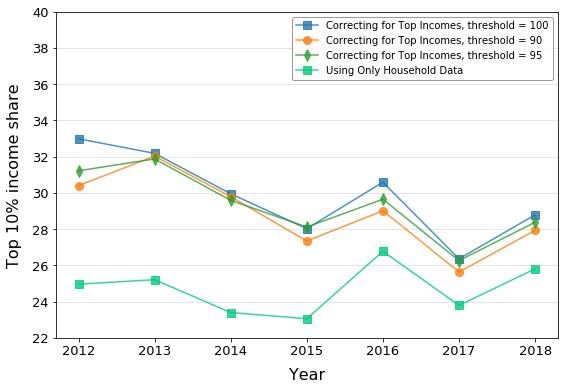

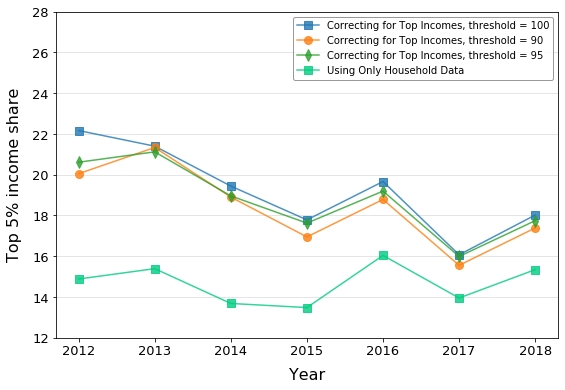

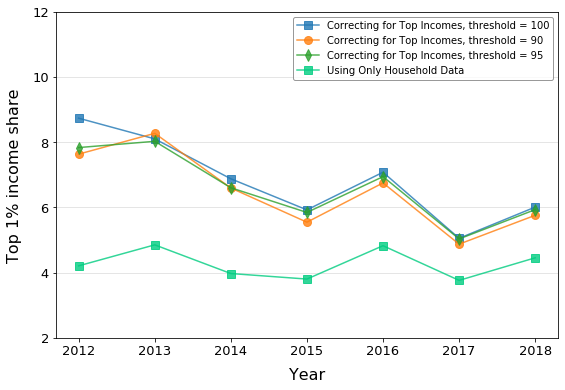

In [77]:
# plot 10P estimated and from survey ##
fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)

for nmr,tauThreshold in enumerate(different_threshold_of_top_HIES):
    ax1.plot("year", f"10HalfDecileEst_thresh_{tauThreshold}", 'o-',
        data= shareTen[(shareTen['year'] >= 1391) & (shareTen['year'] <= 1397)],
        label=f"Correcting for Top Incomes, threshold = {tauThreshold}",
#         marker = markerShape[0],
        marker = markerShape[nmr+1],
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)


ax1.plot("year", f"10HalfDecileSurv", 'o-',
        data= shareTen[(shareTen['year'] >= 1391) & (shareTen['year'] <= 1397)],
#        color=(0.1,0.1,0.9,0.9),
        color=(0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"Using Only Household Data",
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Top 10% income share', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1391,1398,1))
ax1.set_xticklabels(np.arange(1391+621,1398+621,1))
ax1.tick_params(labelsize=13)
ax1.set_ylim(22,40)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2)

plt.show()
fig.savefig(f'../Figures/Robustness/Income_shares_by_10percent_Tehran_rent.pdf',transparent=True,bbox_inches="tight")






# plot 5P estimated and from survey ##

fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)

for nmr,tauThreshold in enumerate(different_threshold_of_top_HIES):
    ax1.plot("year", f"20HalfDecileEst_thresh_{tauThreshold}", 'o-',
        data= shareFive[(shareFive['year'] >= 1391) & (shareFive['year'] <= 1397)],
        label=f"Correcting for Top Incomes, threshold = {tauThreshold}",
#         marker = markerShape[0],
        marker = markerShape[nmr+1],
#        linestyle=ll[nmr] ,
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)


ax1.plot("year", f"20HalfDecileSurv", 'o-',
        data= shareFive[(shareFive['year'] >= 1391) & (shareFive['year'] <= 1397)],
#        color=(0.1,0.1,0.9,0.9),
        color=(0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"Using Only Household Data",
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Top 5% income share', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1391,1398,1))
ax1.set_xticklabels(np.arange(1391+621,1398+621,1))
ax1.tick_params(labelsize=13)
ax1.set_ylim(12,28)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2)

plt.show()
fig.savefig(f'../Figures/Robustness/Income_shares_by_5percent_Tehran_rent.pdf',transparent=True,bbox_inches="tight")



# plot 1P estimated and from survey ##
fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)

for nmr,tauThreshold in enumerate(different_threshold_of_top_HIES):
    ax1.plot("year", f"100HalfDecileEst_thresh_{tauThreshold}", 'o-',
#         data= shareOne[1398>=shareFive.year>=1391],
        data= shareOne[(shareOne['year'] >= 1391) & (shareOne['year'] <= 1397)],

        label=f"Correcting for Top Incomes, threshold = {tauThreshold}",
#         marker = markerShape[0],
        marker = markerShape[nmr+1],
#        linestyle=ll[nmr] ,
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)


ax1.plot("year", f"100HalfDecileSurv", 'o-',
        data= shareOne[(shareOne['year'] >= 1391) & (shareOne['year'] <= 1397)],
#        color=(0.1,0.1,0.9,0.9),
        color=(0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"Using Only Household Data",
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Top 1% income share', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1391,1398,1))
ax1.set_xticklabels(np.arange(1391+621,1398+621,1))
ax1.tick_params(labelsize=13)
ax1.set_ylim(2,12)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2)

plt.show()
fig.savefig(f'../Figures/Robustness/Income_shares_by_1percent_Tehran_rent.pdf',transparent=True,bbox_inches="tight")





**income share for top 1, 5, 10% Iran**

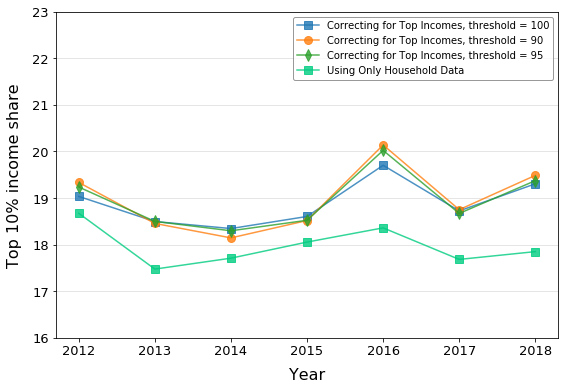

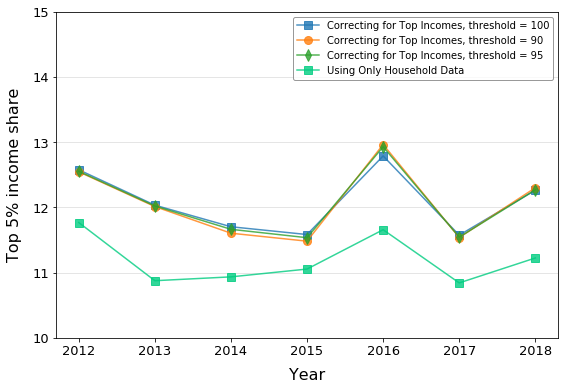

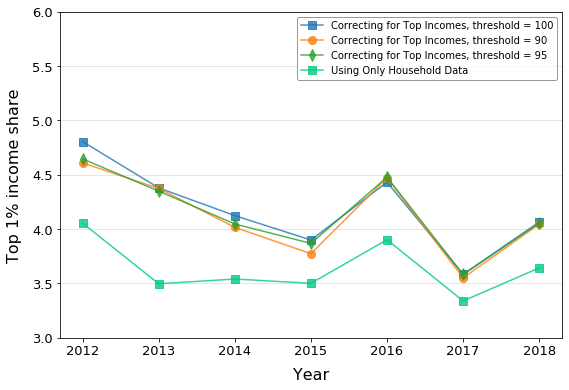

In [78]:
# plot 10P estimated and from survey ##
fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)

for nmr,tauThreshold in enumerate(different_threshold_of_top_HIES):
    ax1.plot("year", f"10HalfDecileEst_thresh_{tauThreshold}", 'o-',
        data= shareTenIran[(shareTen['year'] >= 1391) & (shareTen['year'] <= 1397)],
        label=f"Correcting for Top Incomes, threshold = {tauThreshold}",
#         marker = markerShape[0],
        marker = markerShape[nmr+1],
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)


ax1.plot("year", f"10HalfDecileSurv", 'o-',
        data= shareTenIran[(shareTen['year'] >= 1391) & (shareTen['year'] <= 1397)],
#        color=(0.1,0.1,0.9,0.9),
        color=(0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"Using Only Household Data",
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Top 10% income share', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1391,1398,1))
ax1.set_xticklabels(np.arange(1391+621,1398+621,1))
ax1.tick_params(labelsize=13)
ax1.set_ylim(16,23)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2)

plt.show()
fig.savefig(f'../Figures/Robustness/Income_shares_by_10percent_Iran_rent.pdf',transparent=True,bbox_inches="tight")






# plot 5P estimated and from survey ##

fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)

for nmr,tauThreshold in enumerate(different_threshold_of_top_HIES):
    ax1.plot("year", f"20HalfDecileEst_thresh_{tauThreshold}", 'o-',
        data= shareFiveIran[(shareFive['year'] >= 1391) & (shareFive['year'] <= 1397)],
        label=f"Correcting for Top Incomes, threshold = {tauThreshold}",
#         marker = markerShape[0],
        marker = markerShape[nmr+1],
#        linestyle=ll[nmr] ,
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)


ax1.plot("year", f"20HalfDecileSurv", 'o-',
        data= shareFiveIran[(shareFive['year'] >= 1391) & (shareFive['year'] <= 1397)],
#        color=(0.1,0.1,0.9,0.9),
        color=(0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"Using Only Household Data",
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Top 5% income share', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1391,1398,1))
ax1.set_xticklabels(np.arange(1391+621,1398+621,1))
ax1.tick_params(labelsize=13)
ax1.set_ylim(10,15)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2)

plt.show()
fig.savefig(f'../Figures/Robustness/Income_shares_by_5percent_Iran_rent.pdf',transparent=True,bbox_inches="tight")



# plot 1P estimated and from survey ##
fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)

for nmr,tauThreshold in enumerate(different_threshold_of_top_HIES):
    ax1.plot("year", f"100HalfDecileEst_thresh_{tauThreshold}", 'o-',
        data= shareOneIran[(shareOne['year'] >= 1391) & (shareOne['year'] <= 1397)],
        label=f"Correcting for Top Incomes, threshold = {tauThreshold}",
#         marker = markerShape[0],
        marker = markerShape[nmr+1],
#        linestyle=ll[nmr] ,
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)


ax1.plot("year", f"100HalfDecileSurv", 'o-',
        data= shareOneIran[(shareOne['year'] >= 1391) & (shareOne['year'] <= 1397)],
#        color=(0.1,0.1,0.9,0.9),
        color=(0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"Using Only Household Data",
        linewidth=1.5,
        markersize= 8,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Top 1% income share', fontsize=16, labelpad=10)
ax1.set_xticks(np.arange(1391,1398,1))
ax1.set_xticklabels(np.arange(1391+621,1398+621,1))
ax1.tick_params(labelsize=13)
ax1.set_ylim(3,6)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2)

plt.show()
fig.savefig(f'../Figures/Robustness/Income_shares_by_1percent_Iran_rent.pdf',transparent=True,bbox_inches="tight")





<br>

<br>

**Gini coefficient of whole country**



In [ ]:
Gini_House_Price.year = np.arange(1389,1399,1)
Gini_House_Price

In [ ]:
## plot gini estimated and gini from survey ##

fig=plt.figure(figsize=(9,6))
ax1=fig.add_subplot(1,1,1)


ax1.plot('year', 'GiniIranSurvey', 's-',
        data= result,
        color=(0.1,0.1,0.9,0.9),
        label='Gini_Survey',
        marker = markerShape[0],
        linewidth=1,
        markersize= 7,
        alpha=0.8)


ax1.plot("year", f"GiniIran{different_threshold_of_top_HIES[0]}", 'o-',
        data= result[result.year>139],
#         color= (0,0.8,0.5,0.8),
        marker = markerShape[2],
        label= f"Gini estimated with rent price",
        linestyle="dotted",
        linewidth=2,
        markersize= 7,
        alpha=0.8)

ax1.plot("year", f"Gini_y", 'o-',
        data= Gini_House_Price,
        color= (0,0.8,0.5,0.8),
        marker = markerShape[1],
        label= f"Gini estimated with house price",
        linestyle="dashed",
        linewidth=2,
        markersize= 8,
        alpha=0.8)

ax1.grid(axis='y',alpha=0.4)
# ax1.set_title(f'year {1300+year}')
ax1.set_xlabel('Year', fontsize=16, labelpad=10)
ax1.set_ylabel('Gini Index',
               fontsize=16, labelpad=10)
ax1.legend(loc='best')
# ax1.set_ylim(0.314,0.445)
# ax1.set_yticks(np.arange(0.32,0.45,0.02))
ax1.set_title("Iran",fontsize=19)
ax1.set_xticks(np.arange(1389,1399,1))
ax1.set_xticklabels(np.arange(1389+621,1399+621,1))
ax1.tick_params(labelsize=13)
ax1.legend(loc='best',edgecolor='gray',prop={'size':10}, handlelength=2.2)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

plt.show()

#fig.savefig(f'/Users/ZShamloo/Dropbox/Iran Inequality Measure, Zahra Shamlou/Figures/Robustness/Iran3.pdf',transparent=True,bbox_inches="tight")
#fig.savefig(f'../Figures/Robustness/Iran3.pdf',transparent=True,bbox_inches="tight")




<br></br>
<br></br>

**Gini coefficient of Tehran Province**

<br></br>
<br></br>

In [ ]:
## plot gini estimated and gini from survey ##
prov = "23"

for prov in province_set:
    provName = next(key for key, value in provinceCodeEng.items() if value == prov)
    
    fig=plt.figure(figsize=(9,6))
    ax1=fig.add_subplot(1,1,1)


    ax1.plot('year', 'GiniSurvey'+prov, 'x-',
            data= result,
            color=(0.1,0.1,0.9,0.9),
            label='Gini_Survey',
            markersize= 7,
            alpha=0.8)

    ax1.plot("year", "Gini"+prov+f"_{different_threshold_of_top_HIES[0]}", 'o-',
            data= result.loc[result.year>139,:],
#             color= (0,0.8,0.5,0.8),
            label= "Gini Estimated with rent data",
            linestyle="dotted",
            linewidth=2,
            markersize= 7,
            alpha=0.8)
    
    ax1.plot("year", "Gini_x", 's-',
            data= Gini_House_Price,
            color= (0,0.8,0.5,0.8),
            label= "Gini Estimated with house price",
            linestyle="dashed",
            linewidth=2,
            markersize= 8,
            alpha=0.8)

#     ax1.fill_between('year', 'Gini_lower', 'Gini_upper'
#                      ,data= result
#                      ,color=(0,0.8,0.5,0.15)
#                      ,linewidth= 1)

    ax1.grid(axis='y',alpha=0.4)
    # ax1.set_title(f'year {1300+year}')
    ax1.set_xlabel('Year', fontsize=16, labelpad=10)
    ax1.set_ylabel('Gini Index',
                   fontsize=16, labelpad=10)
    ax1.legend(loc='best')
    # ax1.set_ylim(0.314,0.445)
    # ax1.set_yticks(np.arange(0.32,0.45,0.02))
    ax1.set_xticks(np.arange(1389,1399,1))
    ax1.set_xticklabels(np.arange(1389+621,1399+621,1))

    # ax1.set_xticklabels(np.arange(0.8,0.98,0.02)*100)
    ax1.set_title("Tehran",fontsize=19)
    ax1.tick_params(labelsize=13)
    ax1.legend(loc='best',edgecolor='gray',prop={'size':13}, handlelength=2.2)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
#     ax1.set_yticks(np.arange(30,55.6,2.5))
    plt.show()
    
#fig.savefig(f'/Users/ZShamloo/Dropbox/Iran Inequality Measure, Zahra Shamlou/Figures/Robustness/Tehran3.pdf',transparent=True,bbox_inches="tight")
# fig.savefig(f'../Figures/Robustness/Tehran3.pdf',transparent=True,bbox_inches="tight")


In [ ]:
result

NameError: name 'rentTotal' is not defined

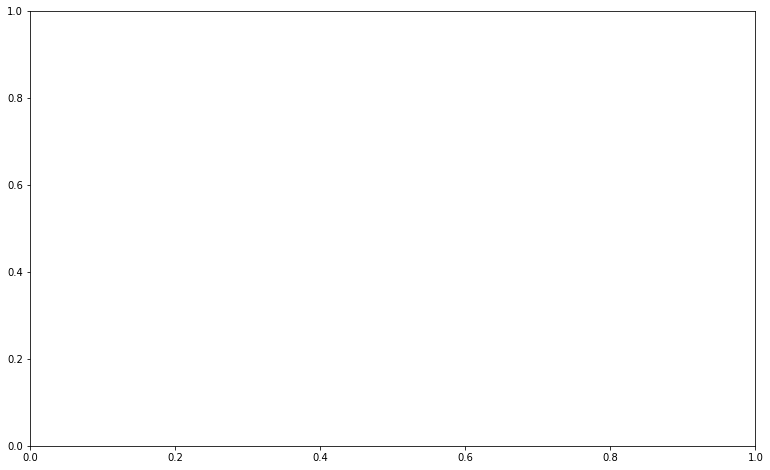

In [293]:
## input year and urban area to calcluate ##

urban = 1

fig=plt.figure(figsize=(13,8))
ax1=fig.add_subplot(1,1,1)
    
for year in np.arange(90,99,1):
    
    ########################################
    ##    estimating theta from survey    ##
    ########################################
    expenditure = expenditureTotal.loc[(expenditureTotal.year==year)
                                      &(expenditureTotal.urban==urban),:]

    # define new vaiables:
    expenditure['hazinehPerCapita']= expenditure.Daramad #GHazineh/np.sqrt(expenditure.tedad)
    expenditure['LnHazineh']= np.log(expenditure.hazinehPerCapita)
    expenditure['province']= expenditure.household.astype(str).str[1:3]

    # calculating empirical cumulative density function
    expenditure.sort_values(by=["province","hazinehPerCapita"],inplace=True)
    expenditure['Fy'] = expenditure.groupby('province')['weight'].transform(pd.Series.cumsum)
    expenditure['countProv']=expenditure.groupby('province')['weight'].transform(pd.Series.sum)
    expenditure['Fy'] = expenditure.Fy/expenditure.countProv
    expenditure.drop(columns=["countProv"], inplace=True)


    #############################################
    ##     calculating beta from survey        ##
    #############################################
    rent = rentTotal.loc[(rentTotal.year==year)]
#                     &(rentTotal.urban==urban),:]


    rent= rent.loc[(rent.DYCOL01 < 43000) , ['Address','DYCOL01' ,'DYCOL04']]
    rent.columns=['household','ownership' ,'rent']
    rent = rent.groupby(by=["household"]).agg({"rent":"sum"}).reset_index()

    #data cleaning
    rent['rent']= rent['rent'] * 12
    rent['LnRent']= np.log(rent.rent)
    # merge two data set by household number :
    rent = pd.merge(rent, expenditure, on=['household'], how='inner')

    rent.sort_values(by=["province","rent"],inplace=True)
    rent['Fy'] = rent.groupby('province')['weight'].transform(pd.Series.cumsum)
    rent['countProv']=rent.groupby('province')['weight'].transform(pd.Series.sum)
    rent['Fy'] = rent.Fy/rent.countProv
    rent.drop(columns=["countProv"],inplace=True)


    # Extracting Tehran :
    rentTehran= rent[rent.province.isin(["30"])]

    space=np.arange(0.8, 0.99, 0.01)
    beta=np.zeros(shape=(19,5))

    for index,topPercentile in enumerate(space):

        x=rentTehran[rentTehran['Fy']>=topPercentile]['LnRent']
        y=rentTehran[rentTehran['Fy']>=topPercentile]['LnHazineh']

        results = mt.reg(
        rentTehran[(rentTehran['Fy']>=topPercentile)
                  ],                     # DataFrame
        'LnHazineh',                      # Dependent var (string)
        'LnRent',                      # Independent var(s) (string or list of strings)
        addcons=True
        ,awt_name='weight'    # Sample weights
        )


    #     results = sm.OLS(y,sm.add_constant(x),missing='drop').fit()
        beta[index,0]=topPercentile
        beta[index,1]= results.beta['LnRent']

        se= results.se['LnRent']
        beta[index,4]=se

        beta[index,2]= (results.beta['LnRent']+ 1.6*se)
        beta[index,3]= (results.beta['LnRent']- 1.6*se)

    #***********************
    #***      Beta       ***
    #***********************
    
    # plot beta ##

    ax1.plot(beta[:,0], beta[:,1]
#              ,"-s"
#              ,markersize = 9
             , linewidth = 2.5
             , label=f"beta {year}")
    
    
ax1.grid(axis='y',alpha=0.5)
#     ax1.set_title(f'Pareto tail for Tehran house prices in {1300+year')
ax1.set_xlabel('percentile', fontsize=18,labelpad=10)
ax1.set_ylabel('coefficient beta' , fontsize=18,labelpad=0)
ax1.tick_params(labelsize=16)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_ylim(0,1.25)
plt.legend(loc="lower left",edgecolor='w',prop={'size':13}, handlelength=1.5,ncol=2)
plt.show() 
    
# fig.savefig('Figures/beta All Year.pdf',transparent=True,bbox_inches="tight")



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
x_m, alpha = 1, 3.
#drawing samples from distribution
samples = (np.random.pareto(alpha, 1000) + 1) * x_m
count, bins, _ = plt.hist(samples, 100, normed=True)
fit = alpha*x_m**alpha / bins**(alpha+1)
plt.plot(bins, max(count)*fit/max(fit), linewidth=2, color='r')
plt.xlabel('bins', fontsize=15)
plt.ylabel('probability density', fontsize=15)
plt.title('Probability Density Function', fontsize=15)
plt.grid(b=True, color='grey', alpha=0.3, linestyle='-.', linewidth=2)
plt.rcParams['figure.figsize'] = [8, 8]
plt.show()

In [ ]:
theta = 3
tau = 1e7
samples = (np.random.pareto(theta, 10) + 1) * tau
samples

In [ ]:
samples = (np.random.pareto(theta, 10) + 1) * tau
samples = pd.DataFrame(samples,columns=["data"])
samples

In [ ]:
gini(samples)

In [ ]:
1 / (2*theta-1)

In [ ]:
tehran   10 5  
isfahan  5  4  4/
ghom     3  1  

# Pareto Parameter Estimation

In [13]:
loop = 5000
result = np.zeros(shape=(loop,1))
result = pd.DataFrame(result, columns=["year"])
result.order = np.arange(1,loop+1)

for enum in range(0,loop+1):

    tau = 100
    theta = 3
    N = 1000
    sample = (np.random.pareto(theta, N) + 1) * tau
    sample = pd.DataFrame(sample,columns=["value"])
    sample["lnValue"] = np.log(sample.value)
    sample["weight"] = 1

    sample.sort_values('value',inplace=True)
    sample.reset_index(drop=True, inplace=True)

    sample['G2y'] = sample.weight.cumsum()
    sample['G2y'] = sample.G2y / sample.weight.sum()


    # new estimation method with Maximum Likelihood ------------------------------
    # Fit Pareto distribution to the variable
    loc = sample.value.min()
    n = sample.shape[0]
    theta_estimate_ML = (n) / (sample.lnValue.sum() - n*np.log(loc))
    # print(theta_estimate_ML) 

    # ----------------------------------------------------------------------------
    # estimation with OLS 
    # N['G2y']=(N.index+1) / (N['totalPrice'].count())  
    sample.drop(sample.tail(1).index,inplace=True)
    sample['Xvariable']= -np.log(1-sample['G2y'])     
    
    x= sample['Xvariable']
    y= sample['lnValue']

    results = sm.OLS(y,sm.add_constant(x),missing='drop').fit()

    theta_estimate_ols = 1/results.params[1]
    # print(theta_estimate_ols)

    result.loc[(result.order==enum),"ML"] = theta_estimate_ML
    result.loc[(result.order==enum),"ML_error"] = (theta_estimate_ML- theta)/theta * 100

    result.loc[(result.order==enum),"OLS"] = theta_estimate_ols
    result.loc[(result.order==enum),"OLS_error"] = (theta_estimate_ols- theta)/theta * 100


# sample

In [14]:
result.mean()

year        0.000
ML          3.007
ML_error    0.219
OLS         3.035
OLS_error   1.169
dtype: float64